# Dot Plot of Neuromodulator Receptor Expression in the Basolateral Amygdala (MERFISH)

This notebook uses **MERFISH spatial transcriptomics** data from the Allen Brain Cell
(ABC) Atlas to visualize neuromodulator receptor expression across cell types in the
**basolateral amygdala (BLA)** of the mouse brain.

### Key Advantage over 10x Data
Unlike the 10x snRNA-seq data (which only has coarse dissection regions like CTXsp),
MERFISH cells are registered to the **Allen Common Coordinate Framework (CCF)**, providing
fine parcellation down to BLA substructures (BLAa, BLAp, BLAv). This means:
- **All cell types are BLA-localized**, including interneurons
- No need for the hybrid approach used in the 10x notebook
- Glia (astrocytes, microglia) are also BLA-specific

### MERFISH Gene Panel Limitation
The MERFISH panel contains 550 genes — a targeted subset of the transcriptome.
Of the 28 neuromodulator receptor genes analyzed in the 10x notebooks, **11 are
available** in the MERFISH panel:
- **Serotonin (5)**: Htr1b, Htr1d, Htr2a, Htr3a, Htr7
- **Norepinephrine (2)**: Adra1a, Adra1b
- **Dopamine (4)**: Drd1, Drd2, Drd3, Drd5

### Prerequisites
- Internet connection (for downloading data from AWS S3)
- Packages: `abc_atlas_access`, `anndata`, `scanpy`, `pandas`, `numpy`, `matplotlib`

In [1]:
import pandas as pd
import numpy as np
import re
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
from pathlib import Path

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

## 1. Initialize the ABC Atlas Cache

In [2]:
download_base = Path('../../data/abc_atlas')
abc_cache = AbcProjectCache.from_s3_cache(download_base)

print(f"Current manifest: {abc_cache.current_manifest}")

Current manifest: releases/20251031/manifest.json


## 2. Load Cell Metadata with CCF Parcellation

The MERFISH-CCF dataset provides cell metadata already joined with both
the WMB taxonomy (subclass, supertype, etc.) and CCF spatial parcellation
(parcellation_structure = BLA, parcellation_substructure = BLAa/BLAp/BLAv).

In [3]:
# Load MERFISH cell metadata with CCF parcellation annotations
ccf_meta = abc_cache.get_metadata_dataframe(
    directory='MERFISH-C57BL6J-638850-CCF',
    file_name='cell_metadata_with_parcellation_annotation',
    dtype={'cell_label': str}
)
ccf_meta.set_index('cell_label', inplace=True)
print(f"Total MERFISH cells with CCF: {len(ccf_meta):,}")

Total MERFISH cells with CCF: 3,739,961


## 3. Identify BLA Cells

Filter to cells within the **basolateral amygdala (BLA)** using CCF parcellation.
This includes all three BLA substructures: BLAa (anterior), BLAp (posterior),
and BLAv (ventral).

In [4]:
# Filter to BLA by CCF parcellation
bla_cells = ccf_meta[ccf_meta['parcellation_structure'] == 'BLA'].copy()
print(f"BLA cells: {len(bla_cells):,}")

print(f"\nBLA substructures:")
for sub, count in bla_cells.groupby('parcellation_substructure', observed=True).size().items():
    print(f"  {sub}: {count:,} cells")

print(f"\nAll BLA subclasses:")
for sc_name, count in bla_cells.groupby('subclass', observed=True).size().sort_values(ascending=False).items():
    print(f"  {sc_name}: {count:,} cells")

BLA cells: 13,233

BLA substructures:
  BLAa: 5,933 cells
  BLAp: 4,647 cells
  BLAv: 2,653 cells

All BLA subclasses:
  014 LA-BLA-BMA-PA Glut: 4,484 cells
  319 Astro-TE NN: 1,832 cells
  333 Endo NN: 973 cells
  013 COAp Grxcr2 Glut: 595 cells
  327 Oligo NN: 531 cells
  064 STR-PAL Chst9 Gaba: 495 cells
  009 L2/3 IT PIR-ENTl Glut: 421 cells
  326 OPC NN: 413 cells
  003 L5/6 IT TPE-ENT Glut: 404 cells
  053 Sst Gaba: 369 cells
  052 Pvalb Gaba: 322 cells
  113 MEA-COA-BMA Ccdc42 Glut: 321 cells
  046 Vip Gaba: 280 cells
  334 Microglia NN: 265 cells
  331 Peri NN: 206 cells
  047 Sncg Gaba: 144 cells
  049 Lamp5 Gaba: 137 cells
  114 COAa-PAA-MEA Barhl2 Glut: 133 cells
  012 MEA Slc17a7 Glut: 125 cells
  054 STR Prox1 Lhx6 Gaba: 121 cells
  051 Pvalb chandelier Gaba: 84 cells
  080 CEA-AAA-BST Six3 Sp9 Gaba: 69 cells
  332 SMC NN: 46 cells
  050 Lamp5 Lhx6 Gaba: 45 cells
  016 CA1-ProS Glut: 45 cells
  318 Astro-NT NN: 37 cells
  048 RHP-COA Ndnf Gaba: 34 cells
  002 IT EP-CLA Glu

In [5]:
# Select neuronal + glial subclasses with sufficient cells
# BLA excitatory neurons
bla_excitatory = [
    '014 LA-BLA-BMA-PA Glut',
    '113 MEA-COA-BMA Ccdc42 Glut',
]

# BLA interneurons — now truly BLA-localized via CCF!
bla_interneurons = [
    '052 Pvalb Gaba',
    '051 Pvalb chandelier Gaba',
    '053 Sst Gaba',
    '046 Vip Gaba',
    '047 Sncg Gaba',
    '049 Lamp5 Gaba',
]

# Glia
bla_glia = [
    '319 Astro-TE NN',
    '334 Microglia NN',
]

# Verify subclasses exist in BLA and have sufficient cells (>=40)
bla_subclass_counts = bla_cells.groupby('subclass', observed=True).size()
all_selected = bla_excitatory + bla_interneurons + bla_glia
all_selected = [s for s in all_selected if s in bla_subclass_counts.index and bla_subclass_counts[s] >= 40]

bla_selected = bla_cells[bla_cells['subclass'].isin(all_selected)].copy()

print(f"Selected BLA cell types ({len(all_selected)} subclasses, {len(bla_selected):,} cells):")
for sc_name, count in bla_selected.groupby('subclass', observed=True).size().sort_values(ascending=False).items():
    tag = ''
    if sc_name in bla_excitatory:
        tag = ' [excitatory]'
    elif sc_name in bla_interneurons:
        tag = ' [interneuron]'
    elif sc_name in bla_glia:
        tag = ' [glia]'
    print(f"  {sc_name}: {count:,} cells{tag}")

Selected BLA cell types (10 subclasses, 8,238 cells):
  014 LA-BLA-BMA-PA Glut: 4,484 cells [excitatory]
  319 Astro-TE NN: 1,832 cells [glia]
  053 Sst Gaba: 369 cells [interneuron]
  052 Pvalb Gaba: 322 cells [interneuron]
  113 MEA-COA-BMA Ccdc42 Glut: 321 cells [excitatory]
  046 Vip Gaba: 280 cells [interneuron]
  334 Microglia NN: 265 cells [glia]
  047 Sncg Gaba: 144 cells [interneuron]
  049 Lamp5 Gaba: 137 cells [interneuron]
  051 Pvalb chandelier Gaba: 84 cells [interneuron]


## 4. Define Receptor Gene Lists

Of the 28 neuromodulator receptor genes, 11 are in the MERFISH 550-gene panel.

In [6]:
# Load MERFISH gene panel
gene = abc_cache.get_metadata_dataframe(
    directory='MERFISH-C57BL6J-638850',
    file_name='gene'
)
gene.set_index('gene_identifier', inplace=True)
print(f"MERFISH gene panel: {len(gene)} genes")

# Receptor genes available in MERFISH
serotonin_receptors = ['Htr1b', 'Htr1d', 'Htr2a', 'Htr3a', 'Htr7']
norepinephrine_receptors = ['Adra1a', 'Adra1b']
dopamine_receptors = ['Drd1', 'Drd2', 'Drd3', 'Drd5']

all_receptors = serotonin_receptors + norepinephrine_receptors + dopamine_receptors

# Verify availability
available_genes = gene[gene['gene_symbol'].isin(all_receptors)]
receptor_genes = [g for g in all_receptors if g in set(available_genes['gene_symbol'])]
gene_ensembl_ids = available_genes.index.tolist()

print(f"\nReceptor genes in MERFISH panel: {len(receptor_genes)}/11")
print(f"  Serotonin: {[g for g in serotonin_receptors if g in receptor_genes]}")
print(f"  Norepinephrine: {[g for g in norepinephrine_receptors if g in receptor_genes]}")
print(f"  Dopamine: {[g for g in dopamine_receptors if g in receptor_genes]}")

# Note missing genes compared to 10x analysis
all_28 = [
    'Htr1a','Htr1b','Htr1d','Htr1f','Htr2a','Htr2b','Htr2c','Htr3a','Htr3b','Htr4','Htr5a','Htr5b','Htr6','Htr7',
    'Adra1a','Adra1b','Adra1d','Adra2a','Adra2b','Adra2c','Adrb1','Adrb2','Adrb3',
    'Drd1','Drd2','Drd3','Drd4','Drd5'
]
missing = [g for g in all_28 if g not in receptor_genes]
print(f"\nNot in MERFISH panel ({len(missing)}): {missing}")

MERFISH gene panel: 550 genes

Receptor genes in MERFISH panel: 11/11
  Serotonin: ['Htr1b', 'Htr1d', 'Htr2a', 'Htr3a', 'Htr7']
  Norepinephrine: ['Adra1a', 'Adra1b']
  Dopamine: ['Drd1', 'Drd2', 'Drd3', 'Drd5']

Not in MERFISH panel (17): ['Htr1a', 'Htr1f', 'Htr2b', 'Htr2c', 'Htr3b', 'Htr4', 'Htr5a', 'Htr5b', 'Htr6', 'Adra1d', 'Adra2a', 'Adra2b', 'Adra2c', 'Adrb1', 'Adrb2', 'Adrb3', 'Drd4']


## 5. Load Expression Data

Load the MERFISH expression matrix (~7 GB, 550 genes × 3.9M cells) and
extract the 11 receptor genes for BLA cells.

In [7]:
import os

# Download and open the MERFISH expression matrix
file_path = abc_cache.get_file_path(
    directory='MERFISH-C57BL6J-638850',
    file_name='C57BL6J-638850/log2'
)
print(f"Loading MERFISH expression from: {file_path}")
print(f"File size: {os.path.getsize(file_path) / 1e9:.1f} GB")

adata = anndata.read_h5ad(file_path, backed='r')
print(f"Expression matrix: {adata.shape[0]:,} cells x {adata.shape[1]} genes")

# Find indices for BLA cells and receptor genes
gene_mask = adata.var.index.isin(gene_ensembl_ids)
cell_mask = adata.obs.index.isin(bla_selected.index)

cell_idx = np.where(cell_mask)[0]
gene_idx = np.where(gene_mask)[0]

print(f"BLA cells found: {len(cell_idx):,}")
print(f"Receptor genes found: {len(gene_idx)}")

# Extract subset into memory
subset = adata[cell_idx, gene_idx].to_memory()
gene_filtered = adata.var[gene_mask]

expression_data = subset.to_df()
expression_data.columns = gene_filtered['gene_symbol'].values
expression_data = expression_data[receptor_genes]

adata.file.close()
del adata

print(f"\nExtracted expression: {expression_data.shape[0]:,} cells x {expression_data.shape[1]} genes")

C57BL6J-638850-log2.h5ad:   0%|          | 0.00/7.63G [00:00<?, ?MB/s]

C57BL6J-638850-log2.h5ad:   0%|          | 1.02k/7.63G [00:00<357:31:58, 5.93kMB/s]

C57BL6J-638850-log2.h5ad:   0%|          | 141k/7.63G [00:00<3:37:10, 585kMB/s]    

C57BL6J-638850-log2.h5ad:   0%|          | 959k/7.63G [00:00<40:14, 3.16MMB/s] 

C57BL6J-638850-log2.h5ad:   0%|          | 3.17M/7.63G [00:00<14:30, 8.76MMB/s]

C57BL6J-638850-log2.h5ad:   0%|          | 7.75M/7.63G [00:00<06:19, 20.1MMB/s]

C57BL6J-638850-log2.h5ad:   0%|          | 14.3M/7.63G [00:00<03:44, 33.9MMB/s]

C57BL6J-638850-log2.h5ad:   0%|          | 20.5M/7.63G [00:00<02:59, 42.5MMB/s]

C57BL6J-638850-log2.h5ad:   0%|          | 26.0M/7.63G [00:00<02:44, 46.1MMB/s]

C57BL6J-638850-log2.h5ad:   0%|          | 31.8M/7.63G [00:01<02:32, 49.8MMB/s]

C57BL6J-638850-log2.h5ad:   1%|          | 38.1M/7.63G [00:01<02:20, 53.8MMB/s]

C57BL6J-638850-log2.h5ad:   1%|          | 43.7M/7.63G [00:01<02:42, 46.7MMB/s]

C57BL6J-638850-log2.h5ad:   1%|          | 50.3M/7.63G [00:01<03:02, 41.6MMB/s]

C57BL6J-638850-log2.h5ad:   1%|          | 56.8M/7.63G [00:01<02:40, 47.1MMB/s]

C57BL6J-638850-log2.h5ad:   1%|          | 61.9M/7.63G [00:01<03:13, 39.0MMB/s]

C57BL6J-638850-log2.h5ad:   1%|          | 67.7M/7.63G [00:01<02:54, 43.4MMB/s]

C57BL6J-638850-log2.h5ad:   1%|          | 73.2M/7.63G [00:01<02:43, 46.1MMB/s]

C57BL6J-638850-log2.h5ad:   1%|          | 78.2M/7.63G [00:02<02:50, 44.4MMB/s]

C57BL6J-638850-log2.h5ad:   1%|          | 83.9M/7.63G [00:02<02:54, 43.3MMB/s]

C57BL6J-638850-log2.h5ad:   1%|          | 91.4M/7.63G [00:02<02:26, 51.3MMB/s]

C57BL6J-638850-log2.h5ad:   1%|▏         | 96.8M/7.63G [00:02<02:49, 44.4MMB/s]

C57BL6J-638850-log2.h5ad:   1%|▏         | 103M/7.63G [00:02<02:32, 49.4MMB/s] 

C57BL6J-638850-log2.h5ad:   1%|▏         | 109M/7.63G [00:02<02:26, 51.2MMB/s]

C57BL6J-638850-log2.h5ad:   2%|▏         | 116M/7.63G [00:02<02:14, 55.9MMB/s]

C57BL6J-638850-log2.h5ad:   2%|▏         | 122M/7.63G [00:02<02:27, 50.9MMB/s]

C57BL6J-638850-log2.h5ad:   2%|▏         | 127M/7.63G [00:03<03:36, 34.7MMB/s]

C57BL6J-638850-log2.h5ad:   2%|▏         | 134M/7.63G [00:03<02:58, 41.9MMB/s]

C57BL6J-638850-log2.h5ad:   2%|▏         | 139M/7.63G [00:03<03:12, 38.9MMB/s]

C57BL6J-638850-log2.h5ad:   2%|▏         | 144M/7.63G [00:03<03:29, 35.7MMB/s]

C57BL6J-638850-log2.h5ad:   2%|▏         | 151M/7.63G [00:03<03:02, 40.9MMB/s]

C57BL6J-638850-log2.h5ad:   2%|▏         | 158M/7.63G [00:03<02:34, 48.3MMB/s]

C57BL6J-638850-log2.h5ad:   2%|▏         | 164M/7.63G [00:03<02:31, 49.2MMB/s]

C57BL6J-638850-log2.h5ad:   2%|▏         | 171M/7.63G [00:04<02:14, 55.2MMB/s]

C57BL6J-638850-log2.h5ad:   2%|▏         | 178M/7.63G [00:04<02:04, 59.9MMB/s]

C57BL6J-638850-log2.h5ad:   2%|▏         | 185M/7.63G [00:04<02:17, 54.0MMB/s]

C57BL6J-638850-log2.h5ad:   3%|▎         | 192M/7.63G [00:04<02:07, 58.3MMB/s]

C57BL6J-638850-log2.h5ad:   3%|▎         | 198M/7.63G [00:04<02:06, 58.9MMB/s]

C57BL6J-638850-log2.h5ad:   3%|▎         | 204M/7.63G [00:04<02:15, 54.7MMB/s]

C57BL6J-638850-log2.h5ad:   3%|▎         | 211M/7.63G [00:04<02:06, 58.5MMB/s]

C57BL6J-638850-log2.h5ad:   3%|▎         | 218M/7.63G [00:04<01:58, 62.5MMB/s]

C57BL6J-638850-log2.h5ad:   3%|▎         | 224M/7.63G [00:04<02:03, 59.7MMB/s]

C57BL6J-638850-log2.h5ad:   3%|▎         | 232M/7.63G [00:05<01:54, 64.7MMB/s]

C57BL6J-638850-log2.h5ad:   3%|▎         | 239M/7.63G [00:05<01:52, 65.7MMB/s]

C57BL6J-638850-log2.h5ad:   3%|▎         | 246M/7.63G [00:05<02:15, 54.7MMB/s]

C57BL6J-638850-log2.h5ad:   3%|▎         | 252M/7.63G [00:05<02:18, 53.1MMB/s]

C57BL6J-638850-log2.h5ad:   3%|▎         | 258M/7.63G [00:05<02:19, 52.9MMB/s]

C57BL6J-638850-log2.h5ad:   3%|▎         | 264M/7.63G [00:05<02:35, 47.3MMB/s]

C57BL6J-638850-log2.h5ad:   4%|▎         | 269M/7.63G [00:05<03:06, 39.4MMB/s]

C57BL6J-638850-log2.h5ad:   4%|▎         | 275M/7.63G [00:06<02:48, 43.6MMB/s]

C57BL6J-638850-log2.h5ad:   4%|▎         | 280M/7.63G [00:06<03:03, 40.0MMB/s]

C57BL6J-638850-log2.h5ad:   4%|▎         | 284M/7.63G [00:06<03:23, 36.0MMB/s]

C57BL6J-638850-log2.h5ad:   4%|▍         | 288M/7.63G [00:06<03:28, 35.3MMB/s]

C57BL6J-638850-log2.h5ad:   4%|▍         | 294M/7.63G [00:06<02:59, 40.8MMB/s]

C57BL6J-638850-log2.h5ad:   4%|▍         | 298M/7.63G [00:06<03:11, 38.3MMB/s]

C57BL6J-638850-log2.h5ad:   4%|▍         | 302M/7.63G [00:06<03:07, 39.2MMB/s]

C57BL6J-638850-log2.h5ad:   4%|▍         | 310M/7.63G [00:06<02:28, 49.3MMB/s]

C57BL6J-638850-log2.h5ad:   4%|▍         | 315M/7.63G [00:07<02:51, 42.7MMB/s]

C57BL6J-638850-log2.h5ad:   4%|▍         | 319M/7.63G [00:07<03:18, 36.8MMB/s]

C57BL6J-638850-log2.h5ad:   4%|▍         | 327M/7.63G [00:07<02:48, 43.3MMB/s]

C57BL6J-638850-log2.h5ad:   4%|▍         | 333M/7.63G [00:07<02:33, 47.6MMB/s]

C57BL6J-638850-log2.h5ad:   4%|▍         | 338M/7.63G [00:07<02:59, 40.6MMB/s]

C57BL6J-638850-log2.h5ad:   5%|▍         | 345M/7.63G [00:07<02:33, 47.5MMB/s]

C57BL6J-638850-log2.h5ad:   5%|▍         | 352M/7.63G [00:07<02:35, 46.7MMB/s]

C57BL6J-638850-log2.h5ad:   5%|▍         | 360M/7.63G [00:07<02:14, 54.0MMB/s]

C57BL6J-638850-log2.h5ad:   5%|▍         | 366M/7.63G [00:08<02:16, 53.2MMB/s]

C57BL6J-638850-log2.h5ad:   5%|▍         | 371M/7.63G [00:08<02:34, 47.1MMB/s]

C57BL6J-638850-log2.h5ad:   5%|▍         | 377M/7.63G [00:08<02:34, 47.0MMB/s]

C57BL6J-638850-log2.h5ad:   5%|▌         | 384M/7.63G [00:08<02:42, 44.6MMB/s]

C57BL6J-638850-log2.h5ad:   5%|▌         | 389M/7.63G [00:08<03:02, 39.6MMB/s]

C57BL6J-638850-log2.h5ad:   5%|▌         | 394M/7.63G [00:08<03:21, 35.9MMB/s]

C57BL6J-638850-log2.h5ad:   5%|▌         | 402M/7.63G [00:08<02:40, 45.0MMB/s]

C57BL6J-638850-log2.h5ad:   5%|▌         | 407M/7.63G [00:09<02:50, 42.4MMB/s]

C57BL6J-638850-log2.h5ad:   5%|▌         | 412M/7.63G [00:09<03:11, 37.6MMB/s]

C57BL6J-638850-log2.h5ad:   5%|▌         | 419M/7.63G [00:09<02:51, 42.0MMB/s]

C57BL6J-638850-log2.h5ad:   6%|▌         | 427M/7.63G [00:09<02:24, 49.7MMB/s]

C57BL6J-638850-log2.h5ad:   6%|▌         | 432M/7.63G [00:09<02:39, 45.2MMB/s]

C57BL6J-638850-log2.h5ad:   6%|▌         | 438M/7.63G [00:09<02:31, 47.5MMB/s]

C57BL6J-638850-log2.h5ad:   6%|▌         | 445M/7.63G [00:09<02:39, 45.1MMB/s]

C57BL6J-638850-log2.h5ad:   6%|▌         | 452M/7.63G [00:10<02:16, 52.5MMB/s]

C57BL6J-638850-log2.h5ad:   6%|▌         | 458M/7.63G [00:10<02:26, 49.0MMB/s]

C57BL6J-638850-log2.h5ad:   6%|▌         | 463M/7.63G [00:10<02:57, 40.4MMB/s]

C57BL6J-638850-log2.h5ad:   6%|▌         | 470M/7.63G [00:10<02:40, 44.6MMB/s]

C57BL6J-638850-log2.h5ad:   6%|▋         | 478M/7.63G [00:10<02:15, 52.9MMB/s]

C57BL6J-638850-log2.h5ad:   6%|▋         | 484M/7.63G [00:10<02:09, 55.1MMB/s]

C57BL6J-638850-log2.h5ad:   6%|▋         | 490M/7.63G [00:10<02:15, 52.7MMB/s]

C57BL6J-638850-log2.h5ad:   6%|▋         | 495M/7.63G [00:10<02:32, 46.7MMB/s]

C57BL6J-638850-log2.h5ad:   7%|▋         | 503M/7.63G [00:11<02:12, 53.7MMB/s]

C57BL6J-638850-log2.h5ad:   7%|▋         | 509M/7.63G [00:11<02:22, 50.0MMB/s]

C57BL6J-638850-log2.h5ad:   7%|▋         | 514M/7.63G [00:11<03:15, 36.5MMB/s]

C57BL6J-638850-log2.h5ad:   7%|▋         | 520M/7.63G [00:11<02:51, 41.4MMB/s]

C57BL6J-638850-log2.h5ad:   7%|▋         | 527M/7.63G [00:11<02:27, 48.1MMB/s]

C57BL6J-638850-log2.h5ad:   7%|▋         | 533M/7.63G [00:11<02:49, 42.0MMB/s]

C57BL6J-638850-log2.h5ad:   7%|▋         | 537M/7.63G [00:11<02:50, 41.7MMB/s]

C57BL6J-638850-log2.h5ad:   7%|▋         | 543M/7.63G [00:12<02:36, 45.4MMB/s]

C57BL6J-638850-log2.h5ad:   7%|▋         | 548M/7.63G [00:12<02:56, 40.0MMB/s]

C57BL6J-638850-log2.h5ad:   7%|▋         | 553M/7.63G [00:12<03:00, 39.2MMB/s]

C57BL6J-638850-log2.h5ad:   7%|▋         | 557M/7.63G [00:12<03:23, 34.8MMB/s]

C57BL6J-638850-log2.h5ad:   7%|▋         | 562M/7.63G [00:12<03:09, 37.2MMB/s]

C57BL6J-638850-log2.h5ad:   7%|▋         | 568M/7.63G [00:12<02:45, 42.6MMB/s]

C57BL6J-638850-log2.h5ad:   8%|▊         | 572M/7.63G [00:12<03:34, 32.9MMB/s]

C57BL6J-638850-log2.h5ad:   8%|▊         | 578M/7.63G [00:13<03:04, 38.1MMB/s]

C57BL6J-638850-log2.h5ad:   8%|▊         | 584M/7.63G [00:13<02:49, 41.6MMB/s]

C57BL6J-638850-log2.h5ad:   8%|▊         | 588M/7.63G [00:13<02:42, 43.3MMB/s]

C57BL6J-638850-log2.h5ad:   8%|▊         | 594M/7.63G [00:13<03:02, 38.6MMB/s]

C57BL6J-638850-log2.h5ad:   8%|▊         | 598M/7.63G [00:13<03:27, 33.9MMB/s]

C57BL6J-638850-log2.h5ad:   8%|▊         | 602M/7.63G [00:13<03:18, 35.3MMB/s]

C57BL6J-638850-log2.h5ad:   8%|▊         | 606M/7.63G [00:13<03:29, 33.5MMB/s]

C57BL6J-638850-log2.h5ad:   8%|▊         | 612M/7.63G [00:13<02:59, 39.0MMB/s]

C57BL6J-638850-log2.h5ad:   8%|▊         | 616M/7.63G [00:14<03:00, 38.9MMB/s]

C57BL6J-638850-log2.h5ad:   8%|▊         | 621M/7.63G [00:14<02:40, 43.7MMB/s]

C57BL6J-638850-log2.h5ad:   8%|▊         | 627M/7.63G [00:14<02:29, 46.9MMB/s]

C57BL6J-638850-log2.h5ad:   8%|▊         | 632M/7.63G [00:14<03:03, 38.1MMB/s]

C57BL6J-638850-log2.h5ad:   8%|▊         | 638M/7.63G [00:14<02:58, 39.2MMB/s]

C57BL6J-638850-log2.h5ad:   8%|▊         | 644M/7.63G [00:14<02:37, 44.5MMB/s]

C57BL6J-638850-log2.h5ad:   9%|▊         | 649M/7.63G [00:14<02:28, 47.0MMB/s]

C57BL6J-638850-log2.h5ad:   9%|▊         | 656M/7.63G [00:14<02:13, 52.1MMB/s]

C57BL6J-638850-log2.h5ad:   9%|▊         | 661M/7.63G [00:14<02:10, 53.3MMB/s]

C57BL6J-638850-log2.h5ad:   9%|▉         | 668M/7.63G [00:15<02:03, 56.5MMB/s]

C57BL6J-638850-log2.h5ad:   9%|▉         | 674M/7.63G [00:15<02:06, 54.9MMB/s]

C57BL6J-638850-log2.h5ad:   9%|▉         | 679M/7.63G [00:15<02:04, 55.6MMB/s]

C57BL6J-638850-log2.h5ad:   9%|▉         | 685M/7.63G [00:15<02:01, 57.2MMB/s]

C57BL6J-638850-log2.h5ad:   9%|▉         | 691M/7.63G [00:15<01:59, 57.9MMB/s]

C57BL6J-638850-log2.h5ad:   9%|▉         | 698M/7.63G [00:15<01:56, 59.3MMB/s]

C57BL6J-638850-log2.h5ad:   9%|▉         | 704M/7.63G [00:15<01:56, 59.7MMB/s]

C57BL6J-638850-log2.h5ad:   9%|▉         | 710M/7.63G [00:15<01:54, 60.3MMB/s]

C57BL6J-638850-log2.h5ad:   9%|▉         | 716M/7.63G [00:15<01:54, 60.5MMB/s]

C57BL6J-638850-log2.h5ad:   9%|▉         | 722M/7.63G [00:15<01:53, 61.0MMB/s]

C57BL6J-638850-log2.h5ad:  10%|▉         | 729M/7.63G [00:16<01:51, 61.6MMB/s]

C57BL6J-638850-log2.h5ad:  10%|▉         | 735M/7.63G [00:16<01:53, 61.0MMB/s]

C57BL6J-638850-log2.h5ad:  10%|▉         | 741M/7.63G [00:16<01:51, 62.0MMB/s]

C57BL6J-638850-log2.h5ad:  10%|▉         | 748M/7.63G [00:16<01:52, 61.2MMB/s]

C57BL6J-638850-log2.h5ad:  10%|▉         | 754M/7.63G [00:16<01:51, 61.8MMB/s]

C57BL6J-638850-log2.h5ad:  10%|▉         | 760M/7.63G [00:16<02:01, 56.7MMB/s]

C57BL6J-638850-log2.h5ad:  10%|█         | 766M/7.63G [00:16<01:58, 57.8MMB/s]

C57BL6J-638850-log2.h5ad:  10%|█         | 772M/7.63G [00:16<02:01, 56.3MMB/s]

C57BL6J-638850-log2.h5ad:  10%|█         | 779M/7.63G [00:16<01:56, 58.6MMB/s]

C57BL6J-638850-log2.h5ad:  10%|█         | 784M/7.63G [00:17<01:56, 58.7MMB/s]

C57BL6J-638850-log2.h5ad:  10%|█         | 791M/7.63G [00:17<01:54, 59.5MMB/s]

C57BL6J-638850-log2.h5ad:  10%|█         | 797M/7.63G [00:17<02:07, 53.6MMB/s]

C57BL6J-638850-log2.h5ad:  11%|█         | 803M/7.63G [00:17<02:00, 56.6MMB/s]

C57BL6J-638850-log2.h5ad:  11%|█         | 809M/7.63G [00:17<02:12, 51.5MMB/s]

C57BL6J-638850-log2.h5ad:  11%|█         | 815M/7.63G [00:17<02:06, 53.8MMB/s]

C57BL6J-638850-log2.h5ad:  11%|█         | 821M/7.63G [00:17<02:08, 53.0MMB/s]

C57BL6J-638850-log2.h5ad:  11%|█         | 826M/7.63G [00:17<02:24, 47.2MMB/s]

C57BL6J-638850-log2.h5ad:  11%|█         | 831M/7.63G [00:18<02:45, 41.1MMB/s]

C57BL6J-638850-log2.h5ad:  11%|█         | 837M/7.63G [00:18<02:39, 42.6MMB/s]

C57BL6J-638850-log2.h5ad:  11%|█         | 841M/7.63G [00:18<02:56, 38.4MMB/s]

C57BL6J-638850-log2.h5ad:  11%|█         | 847M/7.63G [00:18<02:39, 42.6MMB/s]

C57BL6J-638850-log2.h5ad:  11%|█         | 854M/7.63G [00:18<02:21, 47.8MMB/s]

C57BL6J-638850-log2.h5ad:  11%|█▏        | 859M/7.63G [00:18<02:26, 46.1MMB/s]

C57BL6J-638850-log2.h5ad:  11%|█▏        | 864M/7.63G [00:18<02:23, 47.2MMB/s]

C57BL6J-638850-log2.h5ad:  11%|█▏        | 871M/7.63G [00:18<02:10, 52.0MMB/s]

C57BL6J-638850-log2.h5ad:  11%|█▏        | 876M/7.63G [00:18<02:22, 47.3MMB/s]

C57BL6J-638850-log2.h5ad:  12%|█▏        | 881M/7.63G [00:19<02:55, 38.5MMB/s]

C57BL6J-638850-log2.h5ad:  12%|█▏        | 887M/7.63G [00:19<02:31, 44.5MMB/s]

C57BL6J-638850-log2.h5ad:  12%|█▏        | 892M/7.63G [00:19<02:58, 37.7MMB/s]

C57BL6J-638850-log2.h5ad:  12%|█▏        | 898M/7.63G [00:19<02:52, 39.0MMB/s]

C57BL6J-638850-log2.h5ad:  12%|█▏        | 904M/7.63G [00:19<02:28, 45.2MMB/s]

C57BL6J-638850-log2.h5ad:  12%|█▏        | 910M/7.63G [00:19<02:16, 49.2MMB/s]

C57BL6J-638850-log2.h5ad:  12%|█▏        | 916M/7.63G [00:19<02:09, 51.9MMB/s]

C57BL6J-638850-log2.h5ad:  12%|█▏        | 922M/7.63G [00:19<02:02, 54.6MMB/s]

C57BL6J-638850-log2.h5ad:  12%|█▏        | 928M/7.63G [00:20<02:08, 52.1MMB/s]

C57BL6J-638850-log2.h5ad:  12%|█▏        | 933M/7.63G [00:20<02:38, 42.4MMB/s]

C57BL6J-638850-log2.h5ad:  12%|█▏        | 940M/7.63G [00:20<02:51, 39.1MMB/s]

C57BL6J-638850-log2.h5ad:  12%|█▏        | 946M/7.63G [00:20<02:29, 44.8MMB/s]

C57BL6J-638850-log2.h5ad:  12%|█▏        | 951M/7.63G [00:20<02:29, 44.8MMB/s]

C57BL6J-638850-log2.h5ad:  13%|█▎        | 956M/7.63G [00:20<02:50, 39.1MMB/s]

C57BL6J-638850-log2.h5ad:  13%|█▎        | 960M/7.63G [00:20<03:05, 35.9MMB/s]

C57BL6J-638850-log2.h5ad:  13%|█▎        | 965M/7.63G [00:21<02:55, 37.9MMB/s]

C57BL6J-638850-log2.h5ad:  13%|█▎        | 971M/7.63G [00:21<02:30, 44.4MMB/s]

C57BL6J-638850-log2.h5ad:  13%|█▎        | 976M/7.63G [00:21<02:31, 43.8MMB/s]

C57BL6J-638850-log2.h5ad:  13%|█▎        | 981M/7.63G [00:21<02:27, 45.0MMB/s]

C57BL6J-638850-log2.h5ad:  13%|█▎        | 986M/7.63G [00:21<02:39, 41.7MMB/s]

C57BL6J-638850-log2.h5ad:  13%|█▎        | 992M/7.63G [00:21<02:40, 41.2MMB/s]

C57BL6J-638850-log2.h5ad:  13%|█▎        | 998M/7.63G [00:21<02:33, 43.2MMB/s]

C57BL6J-638850-log2.h5ad:  13%|█▎        | 1.00G/7.63G [00:21<02:44, 40.2MMB/s]

C57BL6J-638850-log2.h5ad:  13%|█▎        | 1.01G/7.63G [00:22<02:54, 38.0MMB/s]

C57BL6J-638850-log2.h5ad:  13%|█▎        | 1.01G/7.63G [00:22<03:01, 36.4MMB/s]

C57BL6J-638850-log2.h5ad:  13%|█▎        | 1.01G/7.63G [00:22<03:06, 35.5MMB/s]

C57BL6J-638850-log2.h5ad:  13%|█▎        | 1.02G/7.63G [00:22<03:03, 36.0MMB/s]

C57BL6J-638850-log2.h5ad:  13%|█▎        | 1.02G/7.63G [00:22<03:11, 34.4MMB/s]

C57BL6J-638850-log2.h5ad:  13%|█▎        | 1.03G/7.63G [00:22<03:14, 33.9MMB/s]

C57BL6J-638850-log2.h5ad:  13%|█▎        | 1.03G/7.63G [00:22<03:08, 35.0MMB/s]

C57BL6J-638850-log2.h5ad:  14%|█▎        | 1.03G/7.63G [00:22<03:16, 33.5MMB/s]

C57BL6J-638850-log2.h5ad:  14%|█▎        | 1.04G/7.63G [00:23<03:52, 28.3MMB/s]

C57BL6J-638850-log2.h5ad:  14%|█▎        | 1.04G/7.63G [00:23<03:28, 31.5MMB/s]

C57BL6J-638850-log2.h5ad:  14%|█▎        | 1.04G/7.63G [00:23<03:40, 29.8MMB/s]

C57BL6J-638850-log2.h5ad:  14%|█▎        | 1.05G/7.63G [00:23<03:51, 28.4MMB/s]

C57BL6J-638850-log2.h5ad:  14%|█▍        | 1.05G/7.63G [00:23<04:02, 27.2MMB/s]

C57BL6J-638850-log2.h5ad:  14%|█▍        | 1.05G/7.63G [00:23<04:09, 26.4MMB/s]

C57BL6J-638850-log2.h5ad:  14%|█▍        | 1.06G/7.63G [00:23<04:11, 26.1MMB/s]

C57BL6J-638850-log2.h5ad:  14%|█▍        | 1.06G/7.63G [00:23<04:12, 26.0MMB/s]

C57BL6J-638850-log2.h5ad:  14%|█▍        | 1.06G/7.63G [00:24<04:12, 26.0MMB/s]

C57BL6J-638850-log2.h5ad:  14%|█▍        | 1.07G/7.63G [00:24<04:11, 26.1MMB/s]

C57BL6J-638850-log2.h5ad:  14%|█▍        | 1.07G/7.63G [00:24<04:09, 26.3MMB/s]

C57BL6J-638850-log2.h5ad:  14%|█▍        | 1.07G/7.63G [00:24<04:00, 27.2MMB/s]

C57BL6J-638850-log2.h5ad:  14%|█▍        | 1.07G/7.63G [00:24<04:08, 26.3MMB/s]

C57BL6J-638850-log2.h5ad:  14%|█▍        | 1.08G/7.63G [00:24<04:09, 26.3MMB/s]

C57BL6J-638850-log2.h5ad:  14%|█▍        | 1.08G/7.63G [00:24<04:05, 26.7MMB/s]

C57BL6J-638850-log2.h5ad:  14%|█▍        | 1.08G/7.63G [00:24<03:52, 28.2MMB/s]

C57BL6J-638850-log2.h5ad:  14%|█▍        | 1.09G/7.63G [00:24<04:02, 27.0MMB/s]

C57BL6J-638850-log2.h5ad:  14%|█▍        | 1.09G/7.63G [00:25<04:03, 26.8MMB/s]

C57BL6J-638850-log2.h5ad:  14%|█▍        | 1.09G/7.63G [00:25<03:59, 27.2MMB/s]

C57BL6J-638850-log2.h5ad:  14%|█▍        | 1.09G/7.63G [00:25<04:03, 26.8MMB/s]

C57BL6J-638850-log2.h5ad:  14%|█▍        | 1.10G/7.63G [00:25<03:49, 28.4MMB/s]

C57BL6J-638850-log2.h5ad:  14%|█▍        | 1.10G/7.63G [00:25<03:59, 27.3MMB/s]

C57BL6J-638850-log2.h5ad:  14%|█▍        | 1.10G/7.63G [00:25<03:57, 27.5MMB/s]

C57BL6J-638850-log2.h5ad:  15%|█▍        | 1.11G/7.63G [00:25<03:55, 27.7MMB/s]

C57BL6J-638850-log2.h5ad:  15%|█▍        | 1.11G/7.63G [00:25<03:54, 27.8MMB/s]

C57BL6J-638850-log2.h5ad:  15%|█▍        | 1.11G/7.63G [00:25<03:54, 27.7MMB/s]

C57BL6J-638850-log2.h5ad:  15%|█▍        | 1.12G/7.63G [00:25<03:50, 28.2MMB/s]

C57BL6J-638850-log2.h5ad:  15%|█▍        | 1.12G/7.63G [00:26<03:53, 27.9MMB/s]

C57BL6J-638850-log2.h5ad:  15%|█▍        | 1.12G/7.63G [00:26<03:50, 28.2MMB/s]

C57BL6J-638850-log2.h5ad:  15%|█▍        | 1.12G/7.63G [00:26<03:50, 28.2MMB/s]

C57BL6J-638850-log2.h5ad:  15%|█▍        | 1.13G/7.63G [00:26<03:48, 28.5MMB/s]

C57BL6J-638850-log2.h5ad:  15%|█▍        | 1.13G/7.63G [00:26<03:50, 28.2MMB/s]

C57BL6J-638850-log2.h5ad:  15%|█▍        | 1.13G/7.63G [00:26<03:45, 28.7MMB/s]

C57BL6J-638850-log2.h5ad:  15%|█▍        | 1.14G/7.63G [00:26<03:46, 28.6MMB/s]

C57BL6J-638850-log2.h5ad:  15%|█▍        | 1.14G/7.63G [00:26<03:45, 28.8MMB/s]

C57BL6J-638850-log2.h5ad:  15%|█▍        | 1.14G/7.63G [00:26<03:46, 28.7MMB/s]

C57BL6J-638850-log2.h5ad:  15%|█▌        | 1.14G/7.63G [00:26<03:45, 28.8MMB/s]

C57BL6J-638850-log2.h5ad:  15%|█▌        | 1.15G/7.63G [00:27<03:45, 28.8MMB/s]

C57BL6J-638850-log2.h5ad:  15%|█▌        | 1.15G/7.63G [00:27<03:42, 29.1MMB/s]

C57BL6J-638850-log2.h5ad:  15%|█▌        | 1.15G/7.63G [00:27<03:46, 28.6MMB/s]

C57BL6J-638850-log2.h5ad:  15%|█▌        | 1.16G/7.63G [00:27<03:43, 29.0MMB/s]

C57BL6J-638850-log2.h5ad:  15%|█▌        | 1.16G/7.63G [00:27<03:44, 28.8MMB/s]

C57BL6J-638850-log2.h5ad:  15%|█▌        | 1.16G/7.63G [00:27<03:41, 29.2MMB/s]

C57BL6J-638850-log2.h5ad:  15%|█▌        | 1.17G/7.63G [00:27<03:42, 29.0MMB/s]

C57BL6J-638850-log2.h5ad:  15%|█▌        | 1.17G/7.63G [00:27<03:42, 29.0MMB/s]

C57BL6J-638850-log2.h5ad:  15%|█▌        | 1.17G/7.63G [00:27<03:43, 28.9MMB/s]

C57BL6J-638850-log2.h5ad:  15%|█▌        | 1.17G/7.63G [00:27<03:39, 29.4MMB/s]

C57BL6J-638850-log2.h5ad:  15%|█▌        | 1.18G/7.63G [00:28<03:39, 29.4MMB/s]

C57BL6J-638850-log2.h5ad:  15%|█▌        | 1.18G/7.63G [00:28<03:41, 29.2MMB/s]

C57BL6J-638850-log2.h5ad:  16%|█▌        | 1.18G/7.63G [00:28<03:39, 29.4MMB/s]

C57BL6J-638850-log2.h5ad:  16%|█▌        | 1.19G/7.63G [00:28<03:39, 29.4MMB/s]

C57BL6J-638850-log2.h5ad:  16%|█▌        | 1.19G/7.63G [00:28<03:39, 29.3MMB/s]

C57BL6J-638850-log2.h5ad:  16%|█▌        | 1.19G/7.63G [00:28<03:37, 29.7MMB/s]

C57BL6J-638850-log2.h5ad:  16%|█▌        | 1.20G/7.63G [00:28<03:40, 29.1MMB/s]

C57BL6J-638850-log2.h5ad:  16%|█▌        | 1.20G/7.63G [00:28<03:38, 29.4MMB/s]

C57BL6J-638850-log2.h5ad:  16%|█▌        | 1.20G/7.63G [00:28<03:41, 29.0MMB/s]

C57BL6J-638850-log2.h5ad:  16%|█▌        | 1.20G/7.63G [00:29<03:38, 29.4MMB/s]

C57BL6J-638850-log2.h5ad:  16%|█▌        | 1.21G/7.63G [00:29<03:39, 29.3MMB/s]

C57BL6J-638850-log2.h5ad:  16%|█▌        | 1.21G/7.63G [00:29<03:36, 29.7MMB/s]

C57BL6J-638850-log2.h5ad:  16%|█▌        | 1.21G/7.63G [00:29<03:37, 29.5MMB/s]

C57BL6J-638850-log2.h5ad:  16%|█▌        | 1.22G/7.63G [00:29<03:37, 29.5MMB/s]

C57BL6J-638850-log2.h5ad:  16%|█▌        | 1.22G/7.63G [00:29<03:39, 29.3MMB/s]

C57BL6J-638850-log2.h5ad:  16%|█▌        | 1.22G/7.63G [00:29<03:36, 29.6MMB/s]

C57BL6J-638850-log2.h5ad:  16%|█▌        | 1.23G/7.63G [00:29<03:38, 29.3MMB/s]

C57BL6J-638850-log2.h5ad:  16%|█▌        | 1.23G/7.63G [00:29<03:37, 29.4MMB/s]

C57BL6J-638850-log2.h5ad:  16%|█▌        | 1.23G/7.63G [00:29<03:37, 29.4MMB/s]

C57BL6J-638850-log2.h5ad:  16%|█▌        | 1.23G/7.63G [00:30<03:35, 29.6MMB/s]

C57BL6J-638850-log2.h5ad:  16%|█▌        | 1.24G/7.63G [00:30<03:38, 29.2MMB/s]

C57BL6J-638850-log2.h5ad:  16%|█▋        | 1.24G/7.63G [00:30<03:36, 29.6MMB/s]

C57BL6J-638850-log2.h5ad:  16%|█▋        | 1.24G/7.63G [00:30<03:38, 29.2MMB/s]

C57BL6J-638850-log2.h5ad:  16%|█▋        | 1.25G/7.63G [00:30<03:39, 29.1MMB/s]

C57BL6J-638850-log2.h5ad:  16%|█▋        | 1.25G/7.63G [00:30<03:33, 29.9MMB/s]

C57BL6J-638850-log2.h5ad:  16%|█▋        | 1.25G/7.63G [00:30<03:42, 28.7MMB/s]

C57BL6J-638850-log2.h5ad:  16%|█▋        | 1.26G/7.63G [00:30<03:33, 29.9MMB/s]

C57BL6J-638850-log2.h5ad:  17%|█▋        | 1.26G/7.63G [00:30<03:36, 29.4MMB/s]

C57BL6J-638850-log2.h5ad:  17%|█▋        | 1.26G/7.63G [00:30<03:37, 29.2MMB/s]

C57BL6J-638850-log2.h5ad:  17%|█▋        | 1.27G/7.63G [00:31<03:34, 29.6MMB/s]

C57BL6J-638850-log2.h5ad:  17%|█▋        | 1.27G/7.63G [00:31<03:41, 28.7MMB/s]

C57BL6J-638850-log2.h5ad:  17%|█▋        | 1.27G/7.63G [00:31<03:29, 30.3MMB/s]

C57BL6J-638850-log2.h5ad:  17%|█▋        | 1.27G/7.63G [00:31<03:35, 29.5MMB/s]

C57BL6J-638850-log2.h5ad:  17%|█▋        | 1.28G/7.63G [00:31<03:34, 29.6MMB/s]

C57BL6J-638850-log2.h5ad:  17%|█▋        | 1.28G/7.63G [00:31<03:35, 29.4MMB/s]

C57BL6J-638850-log2.h5ad:  17%|█▋        | 1.28G/7.63G [00:31<03:37, 29.1MMB/s]

C57BL6J-638850-log2.h5ad:  17%|█▋        | 1.29G/7.63G [00:31<03:29, 30.3MMB/s]

C57BL6J-638850-log2.h5ad:  17%|█▋        | 1.29G/7.63G [00:31<03:38, 28.9MMB/s]

C57BL6J-638850-log2.h5ad:  17%|█▋        | 1.29G/7.63G [00:32<03:31, 29.9MMB/s]

C57BL6J-638850-log2.h5ad:  17%|█▋        | 1.30G/7.63G [00:32<03:34, 29.6MMB/s]

C57BL6J-638850-log2.h5ad:  17%|█▋        | 1.30G/7.63G [00:32<03:32, 29.7MMB/s]

C57BL6J-638850-log2.h5ad:  17%|█▋        | 1.30G/7.63G [00:32<03:35, 29.3MMB/s]

C57BL6J-638850-log2.h5ad:  17%|█▋        | 1.31G/7.63G [00:32<03:33, 29.6MMB/s]

C57BL6J-638850-log2.h5ad:  17%|█▋        | 1.31G/7.63G [00:32<03:34, 29.4MMB/s]

C57BL6J-638850-log2.h5ad:  17%|█▋        | 1.31G/7.63G [00:32<03:32, 29.7MMB/s]

C57BL6J-638850-log2.h5ad:  17%|█▋        | 1.31G/7.63G [00:32<03:34, 29.4MMB/s]

C57BL6J-638850-log2.h5ad:  17%|█▋        | 1.32G/7.63G [00:32<03:33, 29.5MMB/s]

C57BL6J-638850-log2.h5ad:  17%|█▋        | 1.32G/7.63G [00:32<03:34, 29.4MMB/s]

C57BL6J-638850-log2.h5ad:  17%|█▋        | 1.32G/7.63G [00:33<03:35, 29.2MMB/s]

C57BL6J-638850-log2.h5ad:  17%|█▋        | 1.33G/7.63G [00:33<03:29, 30.0MMB/s]

C57BL6J-638850-log2.h5ad:  17%|█▋        | 1.33G/7.63G [00:33<03:38, 28.9MMB/s]

C57BL6J-638850-log2.h5ad:  17%|█▋        | 1.33G/7.63G [00:33<03:28, 30.2MMB/s]

C57BL6J-638850-log2.h5ad:  18%|█▊        | 1.34G/7.63G [00:33<03:31, 29.7MMB/s]

C57BL6J-638850-log2.h5ad:  18%|█▊        | 1.34G/7.63G [00:33<04:09, 25.3MMB/s]

C57BL6J-638850-log2.h5ad:  18%|█▊        | 1.34G/7.63G [00:33<03:40, 28.4MMB/s]

C57BL6J-638850-log2.h5ad:  18%|█▊        | 1.35G/7.63G [00:33<04:28, 23.4MMB/s]

C57BL6J-638850-log2.h5ad:  18%|█▊        | 1.35G/7.63G [00:34<05:03, 20.7MMB/s]

C57BL6J-638850-log2.h5ad:  18%|█▊        | 1.35G/7.63G [00:34<05:35, 18.7MMB/s]

C57BL6J-638850-log2.h5ad:  18%|█▊        | 1.35G/7.63G [00:34<05:49, 18.0MMB/s]

C57BL6J-638850-log2.h5ad:  18%|█▊        | 1.35G/7.63G [00:34<06:17, 16.6MMB/s]

C57BL6J-638850-log2.h5ad:  18%|█▊        | 1.36G/7.63G [00:34<06:23, 16.4MMB/s]

C57BL6J-638850-log2.h5ad:  18%|█▊        | 1.36G/7.63G [00:34<06:25, 16.3MMB/s]

C57BL6J-638850-log2.h5ad:  18%|█▊        | 1.36G/7.63G [00:34<06:25, 16.3MMB/s]

C57BL6J-638850-log2.h5ad:  18%|█▊        | 1.36G/7.63G [00:35<06:24, 16.3MMB/s]

C57BL6J-638850-log2.h5ad:  18%|█▊        | 1.36G/7.63G [00:35<06:07, 17.1MMB/s]

C57BL6J-638850-log2.h5ad:  18%|█▊        | 1.37G/7.63G [00:35<06:11, 16.8MMB/s]

C57BL6J-638850-log2.h5ad:  18%|█▊        | 1.37G/7.63G [00:35<06:27, 16.2MMB/s]

C57BL6J-638850-log2.h5ad:  18%|█▊        | 1.37G/7.63G [00:35<06:05, 17.1MMB/s]

C57BL6J-638850-log2.h5ad:  18%|█▊        | 1.37G/7.63G [00:35<06:10, 16.9MMB/s]

C57BL6J-638850-log2.h5ad:  18%|█▊        | 1.37G/7.63G [00:35<06:22, 16.3MMB/s]

C57BL6J-638850-log2.h5ad:  18%|█▊        | 1.38G/7.63G [00:35<06:00, 17.3MMB/s]

C57BL6J-638850-log2.h5ad:  18%|█▊        | 1.38G/7.63G [00:35<06:06, 17.0MMB/s]

C57BL6J-638850-log2.h5ad:  18%|█▊        | 1.38G/7.63G [00:35<06:17, 16.5MMB/s]

C57BL6J-638850-log2.h5ad:  18%|█▊        | 1.38G/7.63G [00:36<05:54, 17.6MMB/s]

C57BL6J-638850-log2.h5ad:  18%|█▊        | 1.38G/7.63G [00:36<06:02, 17.2MMB/s]

C57BL6J-638850-log2.h5ad:  18%|█▊        | 1.38G/7.63G [00:36<06:12, 16.7MMB/s]

C57BL6J-638850-log2.h5ad:  18%|█▊        | 1.39G/7.63G [00:36<05:49, 17.9MMB/s]

C57BL6J-638850-log2.h5ad:  18%|█▊        | 1.39G/7.63G [00:36<05:59, 17.4MMB/s]

C57BL6J-638850-log2.h5ad:  18%|█▊        | 1.39G/7.63G [00:36<06:04, 17.1MMB/s]

C57BL6J-638850-log2.h5ad:  18%|█▊        | 1.39G/7.63G [00:36<05:46, 18.0MMB/s]

C57BL6J-638850-log2.h5ad:  18%|█▊        | 1.39G/7.63G [00:36<05:56, 17.5MMB/s]

C57BL6J-638850-log2.h5ad:  18%|█▊        | 1.40G/7.63G [00:36<06:02, 17.2MMB/s]

C57BL6J-638850-log2.h5ad:  18%|█▊        | 1.40G/7.63G [00:37<05:42, 18.2MMB/s]

C57BL6J-638850-log2.h5ad:  18%|█▊        | 1.40G/7.63G [00:37<05:52, 17.6MMB/s]

C57BL6J-638850-log2.h5ad:  18%|█▊        | 1.40G/7.63G [00:37<05:56, 17.5MMB/s]

C57BL6J-638850-log2.h5ad:  18%|█▊        | 1.40G/7.63G [00:37<05:41, 18.2MMB/s]

C57BL6J-638850-log2.h5ad:  18%|█▊        | 1.41G/7.63G [00:37<05:57, 17.4MMB/s]

C57BL6J-638850-log2.h5ad:  18%|█▊        | 1.41G/7.63G [00:37<05:44, 18.1MMB/s]

C57BL6J-638850-log2.h5ad:  18%|█▊        | 1.41G/7.63G [00:37<05:48, 17.8MMB/s]

C57BL6J-638850-log2.h5ad:  19%|█▊        | 1.41G/7.63G [00:37<05:50, 17.8MMB/s]

C57BL6J-638850-log2.h5ad:  19%|█▊        | 1.41G/7.63G [00:37<05:45, 18.0MMB/s]

C57BL6J-638850-log2.h5ad:  19%|█▊        | 1.41G/7.63G [00:38<05:51, 17.7MMB/s]

C57BL6J-638850-log2.h5ad:  19%|█▊        | 1.42G/7.63G [00:38<05:32, 18.7MMB/s]

C57BL6J-638850-log2.h5ad:  19%|█▊        | 1.42G/7.63G [00:38<05:47, 17.9MMB/s]

C57BL6J-638850-log2.h5ad:  19%|█▊        | 1.42G/7.63G [00:38<05:51, 17.7MMB/s]

C57BL6J-638850-log2.h5ad:  19%|█▊        | 1.42G/7.63G [00:38<05:32, 18.7MMB/s]

C57BL6J-638850-log2.h5ad:  19%|█▊        | 1.42G/7.63G [00:38<05:50, 17.7MMB/s]

C57BL6J-638850-log2.h5ad:  19%|█▊        | 1.43G/7.63G [00:38<05:46, 17.9MMB/s]

C57BL6J-638850-log2.h5ad:  19%|█▊        | 1.43G/7.63G [00:38<05:38, 18.3MMB/s]

C57BL6J-638850-log2.h5ad:  19%|█▉        | 1.43G/7.63G [00:38<05:55, 17.4MMB/s]

C57BL6J-638850-log2.h5ad:  19%|█▉        | 1.43G/7.63G [00:38<05:36, 18.4MMB/s]

C57BL6J-638850-log2.h5ad:  19%|█▉        | 1.43G/7.63G [00:39<05:42, 18.1MMB/s]

C57BL6J-638850-log2.h5ad:  19%|█▉        | 1.44G/7.63G [00:39<05:41, 18.1MMB/s]

C57BL6J-638850-log2.h5ad:  19%|█▉        | 1.44G/7.63G [00:39<05:42, 18.0MMB/s]

C57BL6J-638850-log2.h5ad:  19%|█▉        | 1.44G/7.63G [00:39<05:41, 18.1MMB/s]

C57BL6J-638850-log2.h5ad:  19%|█▉        | 1.44G/7.63G [00:39<05:46, 17.9MMB/s]

C57BL6J-638850-log2.h5ad:  19%|█▉        | 1.44G/7.63G [00:39<05:43, 18.0MMB/s]

C57BL6J-638850-log2.h5ad:  19%|█▉        | 1.45G/7.63G [00:39<05:29, 18.8MMB/s]

C57BL6J-638850-log2.h5ad:  19%|█▉        | 1.45G/7.63G [00:39<05:46, 17.9MMB/s]

C57BL6J-638850-log2.h5ad:  19%|█▉        | 1.45G/7.63G [00:39<05:38, 18.2MMB/s]

C57BL6J-638850-log2.h5ad:  19%|█▉        | 1.45G/7.63G [00:40<05:42, 18.0MMB/s]

C57BL6J-638850-log2.h5ad:  19%|█▉        | 1.45G/7.63G [00:40<05:40, 18.1MMB/s]

C57BL6J-638850-log2.h5ad:  19%|█▉        | 1.45G/7.63G [00:40<05:41, 18.0MMB/s]

C57BL6J-638850-log2.h5ad:  19%|█▉        | 1.46G/7.63G [00:40<05:39, 18.2MMB/s]

C57BL6J-638850-log2.h5ad:  19%|█▉        | 1.46G/7.63G [00:40<05:41, 18.0MMB/s]

C57BL6J-638850-log2.h5ad:  19%|█▉        | 1.46G/7.63G [00:40<05:40, 18.1MMB/s]

C57BL6J-638850-log2.h5ad:  19%|█▉        | 1.46G/7.63G [00:40<05:41, 18.0MMB/s]

C57BL6J-638850-log2.h5ad:  19%|█▉        | 1.46G/7.63G [00:40<05:39, 18.2MMB/s]

C57BL6J-638850-log2.h5ad:  19%|█▉        | 1.47G/7.63G [00:40<05:41, 18.0MMB/s]

C57BL6J-638850-log2.h5ad:  19%|█▉        | 1.47G/7.63G [00:40<05:40, 18.1MMB/s]

C57BL6J-638850-log2.h5ad:  19%|█▉        | 1.47G/7.63G [00:41<05:41, 18.0MMB/s]

C57BL6J-638850-log2.h5ad:  19%|█▉        | 1.47G/7.63G [00:41<05:39, 18.2MMB/s]

C57BL6J-638850-log2.h5ad:  19%|█▉        | 1.47G/7.63G [00:41<05:41, 18.0MMB/s]

C57BL6J-638850-log2.h5ad:  19%|█▉        | 1.48G/7.63G [00:41<05:39, 18.1MMB/s]

C57BL6J-638850-log2.h5ad:  19%|█▉        | 1.48G/7.63G [00:41<05:40, 18.0MMB/s]

C57BL6J-638850-log2.h5ad:  19%|█▉        | 1.48G/7.63G [00:41<05:37, 18.2MMB/s]

C57BL6J-638850-log2.h5ad:  19%|█▉        | 1.48G/7.63G [00:41<05:39, 18.1MMB/s]

C57BL6J-638850-log2.h5ad:  19%|█▉        | 1.48G/7.63G [00:41<05:37, 18.2MMB/s]

C57BL6J-638850-log2.h5ad:  19%|█▉        | 1.48G/7.63G [00:41<05:34, 18.3MMB/s]

C57BL6J-638850-log2.h5ad:  19%|█▉        | 1.49G/7.63G [00:41<05:34, 18.3MMB/s]

C57BL6J-638850-log2.h5ad:  20%|█▉        | 1.49G/7.63G [00:42<05:34, 18.3MMB/s]

C57BL6J-638850-log2.h5ad:  20%|█▉        | 1.49G/7.63G [00:42<05:33, 18.4MMB/s]

C57BL6J-638850-log2.h5ad:  20%|█▉        | 1.49G/7.63G [00:42<05:30, 18.5MMB/s]

C57BL6J-638850-log2.h5ad:  20%|█▉        | 1.49G/7.63G [00:42<05:30, 18.6MMB/s]

C57BL6J-638850-log2.h5ad:  20%|█▉        | 1.50G/7.63G [00:42<05:32, 18.4MMB/s]

C57BL6J-638850-log2.h5ad:  20%|█▉        | 1.50G/7.63G [00:42<05:28, 18.7MMB/s]

C57BL6J-638850-log2.h5ad:  20%|█▉        | 1.50G/7.63G [00:42<05:30, 18.5MMB/s]

C57BL6J-638850-log2.h5ad:  20%|█▉        | 1.50G/7.63G [00:42<05:24, 18.9MMB/s]

C57BL6J-638850-log2.h5ad:  20%|█▉        | 1.50G/7.63G [00:42<05:28, 18.6MMB/s]

C57BL6J-638850-log2.h5ad:  20%|█▉        | 1.51G/7.63G [00:42<05:24, 18.8MMB/s]

C57BL6J-638850-log2.h5ad:  20%|█▉        | 1.51G/7.63G [00:43<05:27, 18.7MMB/s]

C57BL6J-638850-log2.h5ad:  20%|█▉        | 1.51G/7.63G [00:43<05:23, 18.9MMB/s]

C57BL6J-638850-log2.h5ad:  20%|█▉        | 1.51G/7.63G [00:43<05:26, 18.7MMB/s]

C57BL6J-638850-log2.h5ad:  20%|█▉        | 1.51G/7.63G [00:43<05:22, 18.9MMB/s]

C57BL6J-638850-log2.h5ad:  20%|█▉        | 1.52G/7.63G [00:43<05:23, 18.9MMB/s]

C57BL6J-638850-log2.h5ad:  20%|█▉        | 1.52G/7.63G [00:43<05:20, 19.1MMB/s]

C57BL6J-638850-log2.h5ad:  20%|█▉        | 1.52G/7.63G [00:43<05:20, 19.0MMB/s]

C57BL6J-638850-log2.h5ad:  20%|█▉        | 1.52G/7.63G [00:43<05:17, 19.2MMB/s]

C57BL6J-638850-log2.h5ad:  20%|█▉        | 1.52G/7.63G [00:43<05:19, 19.1MMB/s]

C57BL6J-638850-log2.h5ad:  20%|█▉        | 1.52G/7.63G [00:44<05:17, 19.2MMB/s]

C57BL6J-638850-log2.h5ad:  20%|██        | 1.53G/7.63G [00:44<05:17, 19.2MMB/s]

C57BL6J-638850-log2.h5ad:  20%|██        | 1.53G/7.63G [00:44<05:16, 19.3MMB/s]

C57BL6J-638850-log2.h5ad:  20%|██        | 1.53G/7.63G [00:44<05:16, 19.3MMB/s]

C57BL6J-638850-log2.h5ad:  20%|██        | 1.53G/7.63G [00:44<05:12, 19.5MMB/s]

C57BL6J-638850-log2.h5ad:  20%|██        | 1.53G/7.63G [00:44<05:14, 19.4MMB/s]

C57BL6J-638850-log2.h5ad:  20%|██        | 1.54G/7.63G [00:44<05:13, 19.4MMB/s]

C57BL6J-638850-log2.h5ad:  20%|██        | 1.54G/7.63G [00:44<05:11, 19.6MMB/s]

C57BL6J-638850-log2.h5ad:  20%|██        | 1.54G/7.63G [00:44<05:08, 19.7MMB/s]

C57BL6J-638850-log2.h5ad:  20%|██        | 1.54G/7.63G [00:44<05:11, 19.5MMB/s]

C57BL6J-638850-log2.h5ad:  20%|██        | 1.54G/7.63G [00:45<05:09, 19.7MMB/s]

C57BL6J-638850-log2.h5ad:  20%|██        | 1.55G/7.63G [00:45<05:10, 19.6MMB/s]

C57BL6J-638850-log2.h5ad:  20%|██        | 1.55G/7.63G [00:45<05:07, 19.8MMB/s]

C57BL6J-638850-log2.h5ad:  20%|██        | 1.55G/7.63G [00:45<05:07, 19.7MMB/s]

C57BL6J-638850-log2.h5ad:  20%|██        | 1.55G/7.63G [00:45<05:04, 20.0MMB/s]

C57BL6J-638850-log2.h5ad:  20%|██        | 1.56G/7.63G [00:45<05:04, 19.9MMB/s]

C57BL6J-638850-log2.h5ad:  20%|██        | 1.56G/7.63G [00:45<04:58, 20.3MMB/s]

C57BL6J-638850-log2.h5ad:  20%|██        | 1.56G/7.63G [00:45<05:03, 20.0MMB/s]

C57BL6J-638850-log2.h5ad:  20%|██        | 1.56G/7.63G [00:45<04:57, 20.4MMB/s]

C57BL6J-638850-log2.h5ad:  20%|██        | 1.56G/7.63G [00:45<04:57, 20.4MMB/s]

C57BL6J-638850-log2.h5ad:  21%|██        | 1.57G/7.63G [00:46<04:52, 20.7MMB/s]

C57BL6J-638850-log2.h5ad:  21%|██        | 1.57G/7.63G [00:46<04:54, 20.6MMB/s]

C57BL6J-638850-log2.h5ad:  21%|██        | 1.57G/7.63G [00:46<04:46, 21.1MMB/s]

C57BL6J-638850-log2.h5ad:  21%|██        | 1.57G/7.63G [00:46<04:49, 20.9MMB/s]

C57BL6J-638850-log2.h5ad:  21%|██        | 1.57G/7.63G [00:46<04:43, 21.3MMB/s]

C57BL6J-638850-log2.h5ad:  21%|██        | 1.58G/7.63G [00:46<04:45, 21.2MMB/s]

C57BL6J-638850-log2.h5ad:  21%|██        | 1.58G/7.63G [00:46<04:38, 21.7MMB/s]

C57BL6J-638850-log2.h5ad:  21%|██        | 1.58G/7.63G [00:46<04:41, 21.4MMB/s]

C57BL6J-638850-log2.h5ad:  21%|██        | 1.58G/7.63G [00:46<04:34, 22.0MMB/s]

C57BL6J-638850-log2.h5ad:  21%|██        | 1.59G/7.63G [00:46<04:37, 21.8MMB/s]

C57BL6J-638850-log2.h5ad:  21%|██        | 1.59G/7.63G [00:47<04:29, 22.4MMB/s]

C57BL6J-638850-log2.h5ad:  21%|██        | 1.59G/7.63G [00:47<04:32, 22.2MMB/s]

C57BL6J-638850-log2.h5ad:  21%|██        | 1.59G/7.63G [00:47<04:27, 22.6MMB/s]

C57BL6J-638850-log2.h5ad:  21%|██        | 1.59G/7.63G [00:47<04:27, 22.5MMB/s]

C57BL6J-638850-log2.h5ad:  21%|██        | 1.60G/7.63G [00:47<04:20, 23.2MMB/s]

C57BL6J-638850-log2.h5ad:  21%|██        | 1.60G/7.63G [00:47<04:22, 22.9MMB/s]

C57BL6J-638850-log2.h5ad:  21%|██        | 1.60G/7.63G [00:47<04:14, 23.7MMB/s]

C57BL6J-638850-log2.h5ad:  21%|██        | 1.60G/7.63G [00:47<04:17, 23.4MMB/s]

C57BL6J-638850-log2.h5ad:  21%|██        | 1.61G/7.63G [00:47<04:10, 24.1MMB/s]

C57BL6J-638850-log2.h5ad:  21%|██        | 1.61G/7.63G [00:47<04:12, 23.9MMB/s]

C57BL6J-638850-log2.h5ad:  21%|██        | 1.61G/7.63G [00:48<04:04, 24.6MMB/s]

C57BL6J-638850-log2.h5ad:  21%|██        | 1.61G/7.63G [00:48<04:06, 24.4MMB/s]

C57BL6J-638850-log2.h5ad:  21%|██        | 1.62G/7.63G [00:48<03:59, 25.1MMB/s]

C57BL6J-638850-log2.h5ad:  21%|██        | 1.62G/7.63G [00:48<04:01, 24.9MMB/s]

C57BL6J-638850-log2.h5ad:  21%|██▏       | 1.62G/7.63G [00:48<03:53, 25.7MMB/s]

C57BL6J-638850-log2.h5ad:  21%|██▏       | 1.63G/7.63G [00:48<03:58, 25.2MMB/s]

C57BL6J-638850-log2.h5ad:  21%|██▏       | 1.63G/7.63G [00:48<03:51, 26.0MMB/s]

C57BL6J-638850-log2.h5ad:  21%|██▏       | 1.63G/7.63G [00:48<03:50, 26.0MMB/s]

C57BL6J-638850-log2.h5ad:  21%|██▏       | 1.63G/7.63G [00:48<03:45, 26.6MMB/s]

C57BL6J-638850-log2.h5ad:  21%|██▏       | 1.64G/7.63G [00:49<03:43, 26.9MMB/s]

C57BL6J-638850-log2.h5ad:  21%|██▏       | 1.64G/7.63G [00:49<03:40, 27.2MMB/s]

C57BL6J-638850-log2.h5ad:  22%|██▏       | 1.64G/7.63G [00:49<03:38, 27.4MMB/s]

C57BL6J-638850-log2.h5ad:  22%|██▏       | 1.65G/7.63G [00:49<03:34, 27.9MMB/s]

C57BL6J-638850-log2.h5ad:  22%|██▏       | 1.65G/7.63G [00:49<03:32, 28.2MMB/s]

C57BL6J-638850-log2.h5ad:  22%|██▏       | 1.65G/7.63G [00:49<03:27, 28.8MMB/s]

C57BL6J-638850-log2.h5ad:  22%|██▏       | 1.65G/7.63G [00:49<03:29, 28.5MMB/s]

C57BL6J-638850-log2.h5ad:  22%|██▏       | 1.66G/7.63G [00:49<03:23, 29.3MMB/s]

C57BL6J-638850-log2.h5ad:  22%|██▏       | 1.66G/7.63G [00:49<03:23, 29.4MMB/s]

C57BL6J-638850-log2.h5ad:  22%|██▏       | 1.66G/7.63G [00:49<03:17, 30.2MMB/s]

C57BL6J-638850-log2.h5ad:  22%|██▏       | 1.67G/7.63G [00:50<03:18, 30.1MMB/s]

C57BL6J-638850-log2.h5ad:  22%|██▏       | 1.67G/7.63G [00:50<03:12, 30.9MMB/s]

C57BL6J-638850-log2.h5ad:  22%|██▏       | 1.67G/7.63G [00:50<03:13, 30.7MMB/s]

C57BL6J-638850-log2.h5ad:  22%|██▏       | 1.68G/7.63G [00:50<03:06, 31.9MMB/s]

C57BL6J-638850-log2.h5ad:  22%|██▏       | 1.68G/7.63G [00:50<03:08, 31.6MMB/s]

C57BL6J-638850-log2.h5ad:  22%|██▏       | 1.68G/7.63G [00:50<03:04, 32.3MMB/s]

C57BL6J-638850-log2.h5ad:  22%|██▏       | 1.69G/7.63G [00:50<02:59, 33.0MMB/s]

C57BL6J-638850-log2.h5ad:  22%|██▏       | 1.69G/7.63G [00:50<02:58, 33.3MMB/s]

C57BL6J-638850-log2.h5ad:  22%|██▏       | 1.69G/7.63G [00:50<02:57, 33.4MMB/s]

C57BL6J-638850-log2.h5ad:  22%|██▏       | 1.70G/7.63G [00:50<02:52, 34.4MMB/s]

C57BL6J-638850-log2.h5ad:  22%|██▏       | 1.70G/7.63G [00:51<02:52, 34.3MMB/s]

C57BL6J-638850-log2.h5ad:  22%|██▏       | 1.70G/7.63G [00:51<02:45, 35.7MMB/s]

C57BL6J-638850-log2.h5ad:  22%|██▏       | 1.71G/7.63G [00:51<02:47, 35.3MMB/s]

C57BL6J-638850-log2.h5ad:  22%|██▏       | 1.71G/7.63G [00:51<02:42, 36.5MMB/s]

C57BL6J-638850-log2.h5ad:  22%|██▏       | 1.72G/7.63G [00:51<02:43, 36.2MMB/s]

C57BL6J-638850-log2.h5ad:  23%|██▎       | 1.72G/7.63G [00:51<02:37, 37.5MMB/s]

C57BL6J-638850-log2.h5ad:  23%|██▎       | 1.72G/7.63G [00:51<02:39, 37.1MMB/s]

C57BL6J-638850-log2.h5ad:  23%|██▎       | 1.73G/7.63G [00:51<02:33, 38.5MMB/s]

C57BL6J-638850-log2.h5ad:  23%|██▎       | 1.73G/7.63G [00:51<02:34, 38.2MMB/s]

C57BL6J-638850-log2.h5ad:  23%|██▎       | 1.74G/7.63G [00:51<02:29, 39.5MMB/s]

C57BL6J-638850-log2.h5ad:  23%|██▎       | 1.74G/7.63G [00:52<02:29, 39.4MMB/s]

C57BL6J-638850-log2.h5ad:  23%|██▎       | 1.74G/7.63G [00:52<02:25, 40.3MMB/s]

C57BL6J-638850-log2.h5ad:  23%|██▎       | 1.75G/7.63G [00:52<02:26, 40.3MMB/s]

C57BL6J-638850-log2.h5ad:  23%|██▎       | 1.75G/7.63G [00:52<02:21, 41.5MMB/s]

C57BL6J-638850-log2.h5ad:  23%|██▎       | 1.76G/7.63G [00:52<02:19, 42.1MMB/s]

C57BL6J-638850-log2.h5ad:  23%|██▎       | 1.76G/7.63G [00:52<02:16, 42.9MMB/s]

C57BL6J-638850-log2.h5ad:  23%|██▎       | 1.77G/7.63G [00:52<02:15, 43.3MMB/s]

C57BL6J-638850-log2.h5ad:  23%|██▎       | 1.77G/7.63G [00:52<02:12, 44.3MMB/s]

C57BL6J-638850-log2.h5ad:  23%|██▎       | 1.78G/7.63G [00:52<02:12, 44.1MMB/s]

C57BL6J-638850-log2.h5ad:  23%|██▎       | 1.78G/7.63G [00:52<02:07, 45.7MMB/s]

C57BL6J-638850-log2.h5ad:  23%|██▎       | 1.79G/7.63G [00:53<02:08, 45.4MMB/s]

C57BL6J-638850-log2.h5ad:  23%|██▎       | 1.79G/7.63G [00:53<02:03, 47.3MMB/s]

C57BL6J-638850-log2.h5ad:  24%|██▎       | 1.80G/7.63G [00:53<02:04, 47.0MMB/s]

C57BL6J-638850-log2.h5ad:  24%|██▎       | 1.80G/7.63G [00:53<02:00, 48.5MMB/s]

C57BL6J-638850-log2.h5ad:  24%|██▎       | 1.81G/7.63G [00:53<02:01, 48.0MMB/s]

C57BL6J-638850-log2.h5ad:  24%|██▎       | 1.81G/7.63G [00:53<01:56, 50.1MMB/s]

C57BL6J-638850-log2.h5ad:  24%|██▍       | 1.82G/7.63G [00:53<01:57, 49.5MMB/s]

C57BL6J-638850-log2.h5ad:  24%|██▍       | 1.82G/7.63G [00:53<02:08, 45.2MMB/s]

C57BL6J-638850-log2.h5ad:  24%|██▍       | 1.83G/7.63G [00:53<02:04, 46.7MMB/s]

C57BL6J-638850-log2.h5ad:  24%|██▍       | 1.83G/7.63G [00:54<02:11, 44.0MMB/s]

C57BL6J-638850-log2.h5ad:  24%|██▍       | 1.84G/7.63G [00:54<02:18, 41.9MMB/s]

C57BL6J-638850-log2.h5ad:  24%|██▍       | 1.84G/7.63G [00:54<02:23, 40.4MMB/s]

C57BL6J-638850-log2.h5ad:  24%|██▍       | 1.84G/7.63G [00:54<02:18, 41.6MMB/s]

C57BL6J-638850-log2.h5ad:  24%|██▍       | 1.85G/7.63G [00:54<02:23, 40.2MMB/s]

C57BL6J-638850-log2.h5ad:  24%|██▍       | 1.85G/7.63G [00:54<02:25, 39.6MMB/s]

C57BL6J-638850-log2.h5ad:  24%|██▍       | 1.86G/7.63G [00:54<02:22, 40.6MMB/s]

C57BL6J-638850-log2.h5ad:  24%|██▍       | 1.86G/7.63G [00:54<02:24, 39.9MMB/s]

C57BL6J-638850-log2.h5ad:  24%|██▍       | 1.87G/7.63G [00:54<02:17, 41.9MMB/s]

C57BL6J-638850-log2.h5ad:  25%|██▍       | 1.87G/7.63G [00:55<02:20, 40.9MMB/s]

C57BL6J-638850-log2.h5ad:  25%|██▍       | 1.87G/7.63G [00:55<02:17, 41.9MMB/s]

C57BL6J-638850-log2.h5ad:  25%|██▍       | 1.88G/7.63G [00:55<02:18, 41.4MMB/s]

C57BL6J-638850-log2.h5ad:  25%|██▍       | 1.88G/7.63G [00:55<02:17, 41.7MMB/s]

C57BL6J-638850-log2.h5ad:  25%|██▍       | 1.89G/7.63G [00:55<03:18, 28.9MMB/s]

C57BL6J-638850-log2.h5ad:  25%|██▍       | 1.89G/7.63G [00:55<02:50, 33.7MMB/s]

C57BL6J-638850-log2.h5ad:  25%|██▍       | 1.90G/7.63G [00:55<02:48, 33.9MMB/s]

C57BL6J-638850-log2.h5ad:  25%|██▍       | 1.90G/7.63G [00:55<02:39, 35.9MMB/s]

C57BL6J-638850-log2.h5ad:  25%|██▍       | 1.91G/7.63G [00:56<02:25, 39.2MMB/s]

C57BL6J-638850-log2.h5ad:  25%|██▌       | 1.91G/7.63G [00:56<02:24, 39.6MMB/s]

C57BL6J-638850-log2.h5ad:  25%|██▌       | 1.92G/7.63G [00:56<02:14, 42.5MMB/s]

C57BL6J-638850-log2.h5ad:  25%|██▌       | 1.92G/7.63G [00:56<02:16, 41.9MMB/s]

C57BL6J-638850-log2.h5ad:  25%|██▌       | 1.92G/7.63G [00:56<02:07, 44.6MMB/s]

C57BL6J-638850-log2.h5ad:  25%|██▌       | 1.93G/7.63G [00:56<02:09, 43.8MMB/s]

C57BL6J-638850-log2.h5ad:  25%|██▌       | 1.93G/7.63G [00:56<02:09, 44.1MMB/s]

C57BL6J-638850-log2.h5ad:  25%|██▌       | 1.94G/7.63G [00:56<02:03, 46.0MMB/s]

C57BL6J-638850-log2.h5ad:  25%|██▌       | 1.94G/7.63G [00:56<02:06, 45.0MMB/s]

C57BL6J-638850-log2.h5ad:  26%|██▌       | 1.95G/7.63G [00:56<01:59, 47.5MMB/s]

C57BL6J-638850-log2.h5ad:  26%|██▌       | 1.95G/7.63G [00:57<02:02, 46.3MMB/s]

C57BL6J-638850-log2.h5ad:  26%|██▌       | 1.96G/7.63G [00:57<02:02, 46.3MMB/s]

C57BL6J-638850-log2.h5ad:  26%|██▌       | 1.96G/7.63G [00:57<01:59, 47.2MMB/s]

C57BL6J-638850-log2.h5ad:  26%|██▌       | 1.97G/7.63G [00:57<01:59, 47.3MMB/s]

C57BL6J-638850-log2.h5ad:  26%|██▌       | 1.97G/7.63G [00:57<01:59, 47.1MMB/s]

C57BL6J-638850-log2.h5ad:  26%|██▌       | 1.98G/7.63G [00:57<01:58, 47.8MMB/s]

C57BL6J-638850-log2.h5ad:  26%|██▌       | 1.98G/7.63G [00:57<01:58, 47.7MMB/s]

C57BL6J-638850-log2.h5ad:  26%|██▌       | 1.99G/7.63G [00:57<01:57, 48.1MMB/s]

C57BL6J-638850-log2.h5ad:  26%|██▌       | 1.99G/7.63G [00:57<01:57, 48.1MMB/s]

C57BL6J-638850-log2.h5ad:  26%|██▌       | 2.00G/7.63G [00:58<01:54, 49.2MMB/s]

C57BL6J-638850-log2.h5ad:  26%|██▋       | 2.00G/7.63G [00:58<01:55, 48.6MMB/s]

C57BL6J-638850-log2.h5ad:  26%|██▋       | 2.01G/7.63G [00:58<02:05, 44.8MMB/s]

C57BL6J-638850-log2.h5ad:  26%|██▋       | 2.01G/7.63G [00:58<02:40, 35.0MMB/s]

C57BL6J-638850-log2.h5ad:  26%|██▋       | 2.02G/7.63G [00:58<02:21, 39.6MMB/s]

C57BL6J-638850-log2.h5ad:  27%|██▋       | 2.02G/7.63G [00:58<03:05, 30.2MMB/s]

C57BL6J-638850-log2.h5ad:  27%|██▋       | 2.03G/7.63G [00:58<02:47, 33.4MMB/s]

C57BL6J-638850-log2.h5ad:  27%|██▋       | 2.03G/7.63G [00:59<03:01, 30.9MMB/s]

C57BL6J-638850-log2.h5ad:  27%|██▋       | 2.04G/7.63G [00:59<02:44, 33.9MMB/s]

C57BL6J-638850-log2.h5ad:  27%|██▋       | 2.04G/7.63G [00:59<02:44, 33.9MMB/s]

C57BL6J-638850-log2.h5ad:  27%|██▋       | 2.04G/7.63G [00:59<02:31, 36.9MMB/s]

C57BL6J-638850-log2.h5ad:  27%|██▋       | 2.05G/7.63G [00:59<02:15, 41.3MMB/s]

C57BL6J-638850-log2.h5ad:  27%|██▋       | 2.05G/7.63G [00:59<02:09, 43.1MMB/s]

C57BL6J-638850-log2.h5ad:  27%|██▋       | 2.06G/7.63G [00:59<02:16, 40.9MMB/s]

C57BL6J-638850-log2.h5ad:  27%|██▋       | 2.06G/7.63G [00:59<02:04, 44.6MMB/s]

C57BL6J-638850-log2.h5ad:  27%|██▋       | 2.07G/7.63G [00:59<02:02, 45.4MMB/s]

C57BL6J-638850-log2.h5ad:  27%|██▋       | 2.07G/7.63G [01:00<02:10, 42.4MMB/s]

C57BL6J-638850-log2.h5ad:  27%|██▋       | 2.08G/7.63G [01:00<01:59, 46.3MMB/s]

C57BL6J-638850-log2.h5ad:  27%|██▋       | 2.08G/7.63G [01:00<02:12, 41.9MMB/s]

C57BL6J-638850-log2.h5ad:  27%|██▋       | 2.09G/7.63G [01:00<02:02, 45.2MMB/s]

C57BL6J-638850-log2.h5ad:  27%|██▋       | 2.10G/7.63G [01:00<02:00, 46.0MMB/s]

C57BL6J-638850-log2.h5ad:  28%|██▊       | 2.10G/7.63G [01:00<01:53, 48.5MMB/s]

C57BL6J-638850-log2.h5ad:  28%|██▊       | 2.11G/7.63G [01:00<01:52, 48.9MMB/s]

C57BL6J-638850-log2.h5ad:  28%|██▊       | 2.11G/7.63G [01:00<01:49, 50.2MMB/s]

C57BL6J-638850-log2.h5ad:  28%|██▊       | 2.12G/7.63G [01:00<01:58, 46.7MMB/s]

C57BL6J-638850-log2.h5ad:  28%|██▊       | 2.12G/7.63G [01:00<01:58, 46.7MMB/s]

C57BL6J-638850-log2.h5ad:  28%|██▊       | 2.13G/7.63G [01:01<01:59, 46.0MMB/s]

C57BL6J-638850-log2.h5ad:  28%|██▊       | 2.13G/7.63G [01:01<01:57, 46.6MMB/s]

C57BL6J-638850-log2.h5ad:  28%|██▊       | 2.14G/7.63G [01:01<01:50, 49.7MMB/s]

C57BL6J-638850-log2.h5ad:  28%|██▊       | 2.14G/7.63G [01:01<01:55, 47.6MMB/s]

C57BL6J-638850-log2.h5ad:  28%|██▊       | 2.15G/7.63G [01:01<01:52, 48.6MMB/s]

C57BL6J-638850-log2.h5ad:  28%|██▊       | 2.15G/7.63G [01:01<02:03, 44.3MMB/s]

C57BL6J-638850-log2.h5ad:  28%|██▊       | 2.16G/7.63G [01:01<02:03, 44.2MMB/s]

C57BL6J-638850-log2.h5ad:  28%|██▊       | 2.16G/7.63G [01:01<01:55, 47.4MMB/s]

C57BL6J-638850-log2.h5ad:  28%|██▊       | 2.17G/7.63G [01:01<01:54, 47.8MMB/s]

C57BL6J-638850-log2.h5ad:  28%|██▊       | 2.17G/7.63G [01:02<01:48, 50.1MMB/s]

C57BL6J-638850-log2.h5ad:  29%|██▊       | 2.18G/7.63G [01:02<01:49, 49.9MMB/s]

C57BL6J-638850-log2.h5ad:  29%|██▊       | 2.18G/7.63G [01:02<02:22, 38.3MMB/s]

C57BL6J-638850-log2.h5ad:  29%|██▊       | 2.19G/7.63G [01:02<02:12, 40.9MMB/s]

C57BL6J-638850-log2.h5ad:  29%|██▊       | 2.19G/7.63G [01:02<02:02, 44.4MMB/s]

C57BL6J-638850-log2.h5ad:  29%|██▉       | 2.20G/7.63G [01:02<02:05, 43.4MMB/s]

C57BL6J-638850-log2.h5ad:  29%|██▉       | 2.20G/7.63G [01:02<01:57, 46.2MMB/s]

C57BL6J-638850-log2.h5ad:  29%|██▉       | 2.21G/7.63G [01:02<01:54, 47.2MMB/s]

C57BL6J-638850-log2.h5ad:  29%|██▉       | 2.21G/7.63G [01:02<01:55, 46.9MMB/s]

C57BL6J-638850-log2.h5ad:  29%|██▉       | 2.22G/7.63G [01:03<01:59, 45.4MMB/s]

C57BL6J-638850-log2.h5ad:  29%|██▉       | 2.22G/7.63G [01:03<01:56, 46.5MMB/s]

C57BL6J-638850-log2.h5ad:  29%|██▉       | 2.23G/7.63G [01:03<01:49, 49.3MMB/s]

C57BL6J-638850-log2.h5ad:  29%|██▉       | 2.23G/7.63G [01:03<01:50, 48.9MMB/s]

C57BL6J-638850-log2.h5ad:  29%|██▉       | 2.24G/7.63G [01:03<01:46, 50.8MMB/s]

C57BL6J-638850-log2.h5ad:  29%|██▉       | 2.24G/7.63G [01:03<01:46, 50.5MMB/s]

C57BL6J-638850-log2.h5ad:  29%|██▉       | 2.25G/7.63G [01:03<01:43, 52.1MMB/s]

C57BL6J-638850-log2.h5ad:  30%|██▉       | 2.26G/7.63G [01:03<01:44, 51.4MMB/s]

C57BL6J-638850-log2.h5ad:  30%|██▉       | 2.26G/7.63G [01:03<01:42, 52.3MMB/s]

C57BL6J-638850-log2.h5ad:  30%|██▉       | 2.27G/7.63G [01:04<01:43, 51.9MMB/s]

C57BL6J-638850-log2.h5ad:  30%|██▉       | 2.27G/7.63G [01:04<01:47, 50.0MMB/s]

C57BL6J-638850-log2.h5ad:  30%|██▉       | 2.28G/7.63G [01:04<02:09, 41.4MMB/s]

C57BL6J-638850-log2.h5ad:  30%|██▉       | 2.28G/7.63G [01:04<02:21, 37.7MMB/s]

C57BL6J-638850-log2.h5ad:  30%|██▉       | 2.29G/7.63G [01:04<02:06, 42.2MMB/s]

C57BL6J-638850-log2.h5ad:  30%|███       | 2.29G/7.63G [01:04<02:15, 39.4MMB/s]

C57BL6J-638850-log2.h5ad:  30%|███       | 2.30G/7.63G [01:04<02:08, 41.5MMB/s]

C57BL6J-638850-log2.h5ad:  30%|███       | 2.30G/7.63G [01:04<01:57, 45.4MMB/s]

C57BL6J-638850-log2.h5ad:  30%|███       | 2.31G/7.63G [01:05<02:00, 44.2MMB/s]

C57BL6J-638850-log2.h5ad:  30%|███       | 2.31G/7.63G [01:05<01:51, 47.6MMB/s]

C57BL6J-638850-log2.h5ad:  30%|███       | 2.32G/7.63G [01:05<02:08, 41.4MMB/s]

C57BL6J-638850-log2.h5ad:  30%|███       | 2.32G/7.63G [01:05<01:56, 45.6MMB/s]

C57BL6J-638850-log2.h5ad:  31%|███       | 2.33G/7.63G [01:05<01:54, 46.2MMB/s]

C57BL6J-638850-log2.h5ad:  31%|███       | 2.33G/7.63G [01:05<01:47, 49.3MMB/s]

C57BL6J-638850-log2.h5ad:  31%|███       | 2.34G/7.63G [01:05<01:54, 46.1MMB/s]

C57BL6J-638850-log2.h5ad:  31%|███       | 2.34G/7.63G [01:05<01:59, 44.2MMB/s]

C57BL6J-638850-log2.h5ad:  31%|███       | 2.35G/7.63G [01:05<02:02, 43.1MMB/s]

C57BL6J-638850-log2.h5ad:  31%|███       | 2.35G/7.63G [01:06<01:53, 46.3MMB/s]

C57BL6J-638850-log2.h5ad:  31%|███       | 2.36G/7.63G [01:06<01:50, 47.5MMB/s]

C57BL6J-638850-log2.h5ad:  31%|███       | 2.37G/7.63G [01:06<01:45, 50.0MMB/s]

C57BL6J-638850-log2.h5ad:  31%|███       | 2.37G/7.63G [01:06<01:45, 50.0MMB/s]

C57BL6J-638850-log2.h5ad:  31%|███       | 2.38G/7.63G [01:06<01:42, 51.4MMB/s]

C57BL6J-638850-log2.h5ad:  31%|███       | 2.38G/7.63G [01:06<01:42, 51.3MMB/s]

C57BL6J-638850-log2.h5ad:  31%|███▏      | 2.39G/7.63G [01:06<01:55, 45.5MMB/s]

C57BL6J-638850-log2.h5ad:  31%|███▏      | 2.39G/7.63G [01:06<02:01, 42.9MMB/s]

C57BL6J-638850-log2.h5ad:  31%|███▏      | 2.40G/7.63G [01:06<01:52, 46.4MMB/s]

C57BL6J-638850-log2.h5ad:  31%|███▏      | 2.40G/7.63G [01:07<01:52, 46.5MMB/s]

C57BL6J-638850-log2.h5ad:  32%|███▏      | 2.41G/7.63G [01:07<01:44, 49.8MMB/s]

C57BL6J-638850-log2.h5ad:  32%|███▏      | 2.41G/7.63G [01:07<01:49, 47.6MMB/s]

C57BL6J-638850-log2.h5ad:  32%|███▏      | 2.42G/7.63G [01:07<02:29, 34.8MMB/s]

C57BL6J-638850-log2.h5ad:  32%|███▏      | 2.42G/7.63G [01:07<02:15, 38.4MMB/s]

C57BL6J-638850-log2.h5ad:  32%|███▏      | 2.43G/7.63G [01:07<02:09, 40.1MMB/s]

C57BL6J-638850-log2.h5ad:  32%|███▏      | 2.43G/7.63G [01:07<01:58, 43.8MMB/s]

C57BL6J-638850-log2.h5ad:  32%|███▏      | 2.44G/7.63G [01:07<02:25, 35.6MMB/s]

C57BL6J-638850-log2.h5ad:  32%|███▏      | 2.44G/7.63G [01:08<02:19, 37.2MMB/s]

C57BL6J-638850-log2.h5ad:  32%|███▏      | 2.45G/7.63G [01:08<02:02, 42.2MMB/s]

C57BL6J-638850-log2.h5ad:  32%|███▏      | 2.45G/7.63G [01:08<01:57, 44.0MMB/s]

C57BL6J-638850-log2.h5ad:  32%|███▏      | 2.46G/7.63G [01:08<01:49, 47.2MMB/s]

C57BL6J-638850-log2.h5ad:  32%|███▏      | 2.46G/7.63G [01:08<01:47, 48.1MMB/s]

C57BL6J-638850-log2.h5ad:  32%|███▏      | 2.47G/7.63G [01:08<01:43, 50.1MMB/s]

C57BL6J-638850-log2.h5ad:  32%|███▏      | 2.47G/7.63G [01:08<01:41, 50.6MMB/s]

C57BL6J-638850-log2.h5ad:  32%|███▏      | 2.48G/7.63G [01:08<01:39, 51.7MMB/s]

C57BL6J-638850-log2.h5ad:  33%|███▎      | 2.48G/7.63G [01:08<01:39, 51.9MMB/s]

C57BL6J-638850-log2.h5ad:  33%|███▎      | 2.49G/7.63G [01:09<01:39, 51.7MMB/s]

C57BL6J-638850-log2.h5ad:  33%|███▎      | 2.49G/7.63G [01:09<01:37, 52.9MMB/s]

C57BL6J-638850-log2.h5ad:  33%|███▎      | 2.50G/7.63G [01:09<01:50, 46.2MMB/s]

C57BL6J-638850-log2.h5ad:  33%|███▎      | 2.51G/7.63G [01:09<01:44, 49.1MMB/s]

C57BL6J-638850-log2.h5ad:  33%|███▎      | 2.51G/7.63G [01:09<01:48, 47.3MMB/s]

C57BL6J-638850-log2.h5ad:  33%|███▎      | 2.52G/7.63G [01:09<01:49, 46.7MMB/s]

C57BL6J-638850-log2.h5ad:  33%|███▎      | 2.52G/7.63G [01:09<01:46, 47.8MMB/s]

C57BL6J-638850-log2.h5ad:  33%|███▎      | 2.53G/7.63G [01:09<01:41, 50.1MMB/s]

C57BL6J-638850-log2.h5ad:  33%|███▎      | 2.53G/7.63G [01:09<01:38, 51.7MMB/s]

C57BL6J-638850-log2.h5ad:  33%|███▎      | 2.54G/7.63G [01:10<01:44, 48.8MMB/s]

C57BL6J-638850-log2.h5ad:  33%|███▎      | 2.54G/7.63G [01:10<01:38, 51.8MMB/s]

C57BL6J-638850-log2.h5ad:  33%|███▎      | 2.55G/7.63G [01:10<01:40, 50.8MMB/s]

C57BL6J-638850-log2.h5ad:  33%|███▎      | 2.55G/7.63G [01:10<01:42, 49.4MMB/s]

C57BL6J-638850-log2.h5ad:  34%|███▎      | 2.56G/7.63G [01:10<02:18, 36.5MMB/s]

C57BL6J-638850-log2.h5ad:  34%|███▎      | 2.57G/7.63G [01:10<02:06, 40.1MMB/s]

C57BL6J-638850-log2.h5ad:  34%|███▎      | 2.57G/7.63G [01:10<01:54, 44.0MMB/s]

C57BL6J-638850-log2.h5ad:  34%|███▍      | 2.58G/7.63G [01:10<01:50, 45.9MMB/s]

C57BL6J-638850-log2.h5ad:  34%|███▍      | 2.58G/7.63G [01:10<01:43, 48.9MMB/s]

C57BL6J-638850-log2.h5ad:  34%|███▍      | 2.59G/7.63G [01:11<01:48, 46.7MMB/s]

C57BL6J-638850-log2.h5ad:  34%|███▍      | 2.59G/7.63G [01:11<01:44, 48.0MMB/s]

C57BL6J-638850-log2.h5ad:  34%|███▍      | 2.60G/7.63G [01:11<01:39, 50.7MMB/s]

C57BL6J-638850-log2.h5ad:  34%|███▍      | 2.60G/7.63G [01:11<01:38, 50.9MMB/s]

C57BL6J-638850-log2.h5ad:  34%|███▍      | 2.61G/7.63G [01:11<01:52, 44.5MMB/s]

C57BL6J-638850-log2.h5ad:  34%|███▍      | 2.61G/7.63G [01:11<02:08, 39.1MMB/s]

C57BL6J-638850-log2.h5ad:  34%|███▍      | 2.62G/7.63G [01:11<01:55, 43.5MMB/s]

C57BL6J-638850-log2.h5ad:  34%|███▍      | 2.62G/7.63G [01:11<01:49, 45.8MMB/s]

C57BL6J-638850-log2.h5ad:  34%|███▍      | 2.63G/7.63G [01:12<01:42, 48.9MMB/s]

C57BL6J-638850-log2.h5ad:  35%|███▍      | 2.64G/7.63G [01:12<01:40, 49.8MMB/s]

C57BL6J-638850-log2.h5ad:  35%|███▍      | 2.64G/7.63G [01:12<01:36, 51.7MMB/s]

C57BL6J-638850-log2.h5ad:  35%|███▍      | 2.65G/7.63G [01:12<01:36, 51.9MMB/s]

C57BL6J-638850-log2.h5ad:  35%|███▍      | 2.65G/7.63G [01:12<01:34, 52.9MMB/s]

C57BL6J-638850-log2.h5ad:  35%|███▍      | 2.66G/7.63G [01:12<01:32, 53.8MMB/s]

C57BL6J-638850-log2.h5ad:  35%|███▍      | 2.66G/7.63G [01:12<01:32, 53.9MMB/s]

C57BL6J-638850-log2.h5ad:  35%|███▍      | 2.67G/7.63G [01:12<01:33, 53.2MMB/s]

C57BL6J-638850-log2.h5ad:  35%|███▌      | 2.67G/7.63G [01:12<01:30, 54.9MMB/s]

C57BL6J-638850-log2.h5ad:  35%|███▌      | 2.68G/7.63G [01:12<01:31, 53.9MMB/s]

C57BL6J-638850-log2.h5ad:  35%|███▌      | 2.69G/7.63G [01:13<01:29, 55.1MMB/s]

C57BL6J-638850-log2.h5ad:  35%|███▌      | 2.69G/7.63G [01:13<01:49, 45.3MMB/s]

C57BL6J-638850-log2.h5ad:  35%|███▌      | 2.70G/7.63G [01:13<01:58, 41.5MMB/s]

C57BL6J-638850-log2.h5ad:  35%|███▌      | 2.70G/7.63G [01:13<02:05, 39.3MMB/s]

C57BL6J-638850-log2.h5ad:  35%|███▌      | 2.71G/7.63G [01:13<01:51, 44.3MMB/s]

C57BL6J-638850-log2.h5ad:  36%|███▌      | 2.71G/7.63G [01:13<01:48, 45.4MMB/s]

C57BL6J-638850-log2.h5ad:  36%|███▌      | 2.72G/7.63G [01:13<02:05, 39.1MMB/s]

C57BL6J-638850-log2.h5ad:  36%|███▌      | 2.72G/7.63G [01:13<01:50, 44.2MMB/s]

C57BL6J-638850-log2.h5ad:  36%|███▌      | 2.73G/7.63G [01:14<01:59, 41.1MMB/s]

C57BL6J-638850-log2.h5ad:  36%|███▌      | 2.73G/7.63G [01:14<02:02, 39.9MMB/s]

C57BL6J-638850-log2.h5ad:  36%|███▌      | 2.74G/7.63G [01:14<01:49, 44.7MMB/s]

C57BL6J-638850-log2.h5ad:  36%|███▌      | 2.75G/7.63G [01:14<01:51, 43.9MMB/s]

C57BL6J-638850-log2.h5ad:  36%|███▌      | 2.75G/7.63G [01:14<02:04, 39.1MMB/s]

C57BL6J-638850-log2.h5ad:  36%|███▌      | 2.76G/7.63G [01:14<01:50, 44.1MMB/s]

C57BL6J-638850-log2.h5ad:  36%|███▌      | 2.76G/7.63G [01:14<02:11, 37.0MMB/s]

C57BL6J-638850-log2.h5ad:  36%|███▋      | 2.77G/7.63G [01:15<01:54, 42.5MMB/s]

C57BL6J-638850-log2.h5ad:  36%|███▋      | 2.77G/7.63G [01:15<01:46, 45.4MMB/s]

C57BL6J-638850-log2.h5ad:  36%|███▋      | 2.78G/7.63G [01:15<01:38, 49.4MMB/s]

C57BL6J-638850-log2.h5ad:  37%|███▋      | 2.79G/7.63G [01:15<01:34, 51.3MMB/s]

C57BL6J-638850-log2.h5ad:  37%|███▋      | 2.79G/7.63G [01:15<01:30, 53.5MMB/s]

C57BL6J-638850-log2.h5ad:  37%|███▋      | 2.80G/7.63G [01:15<02:06, 38.2MMB/s]

C57BL6J-638850-log2.h5ad:  37%|███▋      | 2.80G/7.63G [01:15<02:05, 38.4MMB/s]

C57BL6J-638850-log2.h5ad:  37%|███▋      | 2.81G/7.63G [01:15<01:50, 43.7MMB/s]

C57BL6J-638850-log2.h5ad:  37%|███▋      | 2.81G/7.63G [01:16<01:42, 47.1MMB/s]

C57BL6J-638850-log2.h5ad:  37%|███▋      | 2.82G/7.63G [01:16<01:39, 48.5MMB/s]

C57BL6J-638850-log2.h5ad:  37%|███▋      | 2.83G/7.63G [01:16<01:32, 52.0MMB/s]

C57BL6J-638850-log2.h5ad:  37%|███▋      | 2.83G/7.63G [01:16<01:39, 48.1MMB/s]

C57BL6J-638850-log2.h5ad:  37%|███▋      | 2.84G/7.63G [01:16<01:36, 49.8MMB/s]

C57BL6J-638850-log2.h5ad:  37%|███▋      | 2.84G/7.63G [01:16<01:28, 54.3MMB/s]

C57BL6J-638850-log2.h5ad:  37%|███▋      | 2.85G/7.63G [01:16<01:30, 52.8MMB/s]

C57BL6J-638850-log2.h5ad:  37%|███▋      | 2.85G/7.63G [01:16<01:44, 45.6MMB/s]

C57BL6J-638850-log2.h5ad:  37%|███▋      | 2.86G/7.63G [01:16<01:37, 48.9MMB/s]

C57BL6J-638850-log2.h5ad:  38%|███▊      | 2.86G/7.63G [01:17<01:46, 44.9MMB/s]

C57BL6J-638850-log2.h5ad:  38%|███▊      | 2.87G/7.63G [01:17<01:46, 44.7MMB/s]

C57BL6J-638850-log2.h5ad:  38%|███▊      | 2.88G/7.63G [01:17<01:34, 50.4MMB/s]

C57BL6J-638850-log2.h5ad:  38%|███▊      | 2.88G/7.63G [01:17<01:40, 47.2MMB/s]

C57BL6J-638850-log2.h5ad:  38%|███▊      | 2.89G/7.63G [01:17<01:35, 49.4MMB/s]

C57BL6J-638850-log2.h5ad:  38%|███▊      | 2.89G/7.63G [01:17<01:28, 53.6MMB/s]

C57BL6J-638850-log2.h5ad:  38%|███▊      | 2.90G/7.63G [01:17<01:42, 46.4MMB/s]

C57BL6J-638850-log2.h5ad:  38%|███▊      | 2.90G/7.63G [01:17<01:46, 44.5MMB/s]

C57BL6J-638850-log2.h5ad:  38%|███▊      | 2.91G/7.63G [01:18<01:47, 43.9MMB/s]

C57BL6J-638850-log2.h5ad:  38%|███▊      | 2.91G/7.63G [01:18<02:34, 30.5MMB/s]

C57BL6J-638850-log2.h5ad:  38%|███▊      | 2.92G/7.63G [01:18<02:15, 34.8MMB/s]

C57BL6J-638850-log2.h5ad:  38%|███▊      | 2.92G/7.63G [01:18<02:10, 36.2MMB/s]

C57BL6J-638850-log2.h5ad:  38%|███▊      | 2.93G/7.63G [01:18<02:06, 37.2MMB/s]

C57BL6J-638850-log2.h5ad:  38%|███▊      | 2.93G/7.63G [01:18<02:17, 34.2MMB/s]

C57BL6J-638850-log2.h5ad:  38%|███▊      | 2.94G/7.63G [01:18<02:05, 37.5MMB/s]

C57BL6J-638850-log2.h5ad:  39%|███▊      | 2.94G/7.63G [01:18<01:53, 41.3MMB/s]

C57BL6J-638850-log2.h5ad:  39%|███▊      | 2.94G/7.63G [01:19<02:27, 31.7MMB/s]

C57BL6J-638850-log2.h5ad:  39%|███▊      | 2.95G/7.63G [01:19<02:11, 35.5MMB/s]

C57BL6J-638850-log2.h5ad:  39%|███▊      | 2.95G/7.63G [01:19<02:22, 32.9MMB/s]

C57BL6J-638850-log2.h5ad:  39%|███▉      | 2.96G/7.63G [01:19<02:11, 35.6MMB/s]

C57BL6J-638850-log2.h5ad:  39%|███▉      | 2.96G/7.63G [01:19<02:09, 35.9MMB/s]

C57BL6J-638850-log2.h5ad:  39%|███▉      | 2.97G/7.63G [01:19<02:01, 38.4MMB/s]

C57BL6J-638850-log2.h5ad:  39%|███▉      | 2.97G/7.63G [01:19<01:51, 41.8MMB/s]

C57BL6J-638850-log2.h5ad:  39%|███▉      | 2.98G/7.63G [01:19<01:45, 44.0MMB/s]

C57BL6J-638850-log2.h5ad:  39%|███▉      | 2.98G/7.63G [01:20<01:49, 42.3MMB/s]

C57BL6J-638850-log2.h5ad:  39%|███▉      | 2.99G/7.63G [01:20<01:48, 42.9MMB/s]

C57BL6J-638850-log2.h5ad:  39%|███▉      | 2.99G/7.63G [01:20<01:40, 46.1MMB/s]

C57BL6J-638850-log2.h5ad:  39%|███▉      | 3.00G/7.63G [01:20<01:38, 47.1MMB/s]

C57BL6J-638850-log2.h5ad:  39%|███▉      | 3.00G/7.63G [01:20<01:32, 50.1MMB/s]

C57BL6J-638850-log2.h5ad:  39%|███▉      | 3.01G/7.63G [01:20<01:36, 47.7MMB/s]

C57BL6J-638850-log2.h5ad:  39%|███▉      | 3.01G/7.63G [01:20<01:41, 45.7MMB/s]

C57BL6J-638850-log2.h5ad:  40%|███▉      | 3.02G/7.63G [01:20<01:37, 47.2MMB/s]

C57BL6J-638850-log2.h5ad:  40%|███▉      | 3.02G/7.63G [01:20<01:52, 40.8MMB/s]

C57BL6J-638850-log2.h5ad:  40%|███▉      | 3.03G/7.63G [01:21<02:07, 36.0MMB/s]

C57BL6J-638850-log2.h5ad:  40%|███▉      | 3.03G/7.63G [01:21<02:18, 33.3MMB/s]

C57BL6J-638850-log2.h5ad:  40%|███▉      | 3.03G/7.63G [01:21<02:17, 33.5MMB/s]

C57BL6J-638850-log2.h5ad:  40%|███▉      | 3.04G/7.63G [01:21<02:04, 36.8MMB/s]

C57BL6J-638850-log2.h5ad:  40%|███▉      | 3.04G/7.63G [01:21<02:07, 36.0MMB/s]

C57BL6J-638850-log2.h5ad:  40%|███▉      | 3.05G/7.63G [01:21<02:05, 36.4MMB/s]

C57BL6J-638850-log2.h5ad:  40%|████      | 3.05G/7.63G [01:21<01:57, 38.9MMB/s]

C57BL6J-638850-log2.h5ad:  40%|████      | 3.06G/7.63G [01:21<02:00, 38.1MMB/s]

C57BL6J-638850-log2.h5ad:  40%|████      | 3.06G/7.63G [01:22<01:58, 38.5MMB/s]

C57BL6J-638850-log2.h5ad:  40%|████      | 3.06G/7.63G [01:22<01:53, 40.3MMB/s]

C57BL6J-638850-log2.h5ad:  40%|████      | 3.07G/7.63G [01:22<01:56, 39.1MMB/s]

C57BL6J-638850-log2.h5ad:  40%|████      | 3.07G/7.63G [01:22<01:54, 39.7MMB/s]

C57BL6J-638850-log2.h5ad:  40%|████      | 3.08G/7.63G [01:22<01:50, 41.2MMB/s]

C57BL6J-638850-log2.h5ad:  40%|████      | 3.08G/7.63G [01:22<01:53, 40.1MMB/s]

C57BL6J-638850-log2.h5ad:  40%|████      | 3.09G/7.63G [01:22<01:50, 41.3MMB/s]

C57BL6J-638850-log2.h5ad:  41%|████      | 3.09G/7.63G [01:22<01:50, 41.1MMB/s]

C57BL6J-638850-log2.h5ad:  41%|████      | 3.10G/7.63G [01:22<01:49, 41.2MMB/s]

C57BL6J-638850-log2.h5ad:  41%|████      | 3.10G/7.63G [01:22<01:49, 41.3MMB/s]

C57BL6J-638850-log2.h5ad:  41%|████      | 3.10G/7.63G [01:23<01:48, 41.6MMB/s]

C57BL6J-638850-log2.h5ad:  41%|████      | 3.11G/7.63G [01:23<01:46, 42.3MMB/s]

C57BL6J-638850-log2.h5ad:  41%|████      | 3.11G/7.63G [01:23<01:46, 42.2MMB/s]

C57BL6J-638850-log2.h5ad:  41%|████      | 3.12G/7.63G [01:23<01:45, 42.6MMB/s]

C57BL6J-638850-log2.h5ad:  41%|████      | 3.12G/7.63G [01:23<01:45, 42.6MMB/s]

C57BL6J-638850-log2.h5ad:  41%|████      | 3.13G/7.63G [01:23<01:45, 42.5MMB/s]

C57BL6J-638850-log2.h5ad:  41%|████      | 3.13G/7.63G [01:23<01:44, 42.9MMB/s]

C57BL6J-638850-log2.h5ad:  41%|████      | 3.13G/7.63G [01:23<01:44, 42.9MMB/s]

C57BL6J-638850-log2.h5ad:  41%|████      | 3.14G/7.63G [01:23<01:46, 42.0MMB/s]

C57BL6J-638850-log2.h5ad:  41%|████      | 3.14G/7.63G [01:23<01:42, 43.9MMB/s]

C57BL6J-638850-log2.h5ad:  41%|████▏     | 3.15G/7.63G [01:24<01:44, 42.8MMB/s]

C57BL6J-638850-log2.h5ad:  41%|████▏     | 3.15G/7.63G [01:24<01:44, 42.7MMB/s]

C57BL6J-638850-log2.h5ad:  41%|████▏     | 3.16G/7.63G [01:24<01:40, 44.6MMB/s]

C57BL6J-638850-log2.h5ad:  41%|████▏     | 3.16G/7.63G [01:24<01:43, 43.3MMB/s]

C57BL6J-638850-log2.h5ad:  42%|████▏     | 3.17G/7.63G [01:24<01:42, 43.4MMB/s]

C57BL6J-638850-log2.h5ad:  42%|████▏     | 3.17G/7.63G [01:24<01:38, 45.0MMB/s]

C57BL6J-638850-log2.h5ad:  42%|████▏     | 3.18G/7.63G [01:24<01:41, 43.6MMB/s]

C57BL6J-638850-log2.h5ad:  42%|████▏     | 3.18G/7.63G [01:24<01:37, 45.6MMB/s]

C57BL6J-638850-log2.h5ad:  42%|████▏     | 3.19G/7.63G [01:24<01:40, 44.2MMB/s]

C57BL6J-638850-log2.h5ad:  42%|████▏     | 3.19G/7.63G [01:25<01:40, 44.0MMB/s]

C57BL6J-638850-log2.h5ad:  42%|████▏     | 3.20G/7.63G [01:25<01:38, 44.9MMB/s]

C57BL6J-638850-log2.h5ad:  42%|████▏     | 3.20G/7.63G [01:25<01:40, 43.8MMB/s]

C57BL6J-638850-log2.h5ad:  42%|████▏     | 3.20G/7.63G [01:25<01:51, 39.8MMB/s]

C57BL6J-638850-log2.h5ad:  42%|████▏     | 3.21G/7.63G [01:25<01:59, 36.9MMB/s]

C57BL6J-638850-log2.h5ad:  42%|████▏     | 3.21G/7.63G [01:25<02:17, 32.0MMB/s]

C57BL6J-638850-log2.h5ad:  42%|████▏     | 3.22G/7.63G [01:25<02:35, 28.4MMB/s]

C57BL6J-638850-log2.h5ad:  42%|████▏     | 3.22G/7.63G [01:25<02:42, 27.2MMB/s]

C57BL6J-638850-log2.h5ad:  42%|████▏     | 3.22G/7.63G [01:26<02:50, 25.8MMB/s]

C57BL6J-638850-log2.h5ad:  42%|████▏     | 3.22G/7.63G [01:26<02:57, 24.8MMB/s]

C57BL6J-638850-log2.h5ad:  42%|████▏     | 3.23G/7.63G [01:26<03:03, 24.0MMB/s]

C57BL6J-638850-log2.h5ad:  42%|████▏     | 3.23G/7.63G [01:26<03:00, 24.3MMB/s]

C57BL6J-638850-log2.h5ad:  42%|████▏     | 3.23G/7.63G [01:26<02:58, 24.6MMB/s]

C57BL6J-638850-log2.h5ad:  42%|████▏     | 3.23G/7.63G [01:26<03:05, 23.7MMB/s]

C57BL6J-638850-log2.h5ad:  42%|████▏     | 3.24G/7.63G [01:26<03:00, 24.3MMB/s]

C57BL6J-638850-log2.h5ad:  42%|████▏     | 3.24G/7.63G [01:26<02:59, 24.5MMB/s]

C57BL6J-638850-log2.h5ad:  43%|████▎     | 3.24G/7.63G [01:26<02:59, 24.4MMB/s]

C57BL6J-638850-log2.h5ad:  43%|████▎     | 3.25G/7.63G [01:27<02:57, 24.7MMB/s]

C57BL6J-638850-log2.h5ad:  43%|████▎     | 3.25G/7.63G [01:27<02:58, 24.6MMB/s]

C57BL6J-638850-log2.h5ad:  43%|████▎     | 3.25G/7.63G [01:27<02:58, 24.5MMB/s]

C57BL6J-638850-log2.h5ad:  43%|████▎     | 3.25G/7.63G [01:27<02:56, 24.8MMB/s]

C57BL6J-638850-log2.h5ad:  43%|████▎     | 3.26G/7.63G [01:27<02:56, 24.7MMB/s]

C57BL6J-638850-log2.h5ad:  43%|████▎     | 3.26G/7.63G [01:27<02:54, 25.1MMB/s]

C57BL6J-638850-log2.h5ad:  43%|████▎     | 3.26G/7.63G [01:27<02:54, 25.0MMB/s]

C57BL6J-638850-log2.h5ad:  43%|████▎     | 3.26G/7.63G [01:27<02:51, 25.4MMB/s]

C57BL6J-638850-log2.h5ad:  43%|████▎     | 3.27G/7.63G [01:27<02:53, 25.1MMB/s]

C57BL6J-638850-log2.h5ad:  43%|████▎     | 3.27G/7.63G [01:28<02:51, 25.5MMB/s]

C57BL6J-638850-log2.h5ad:  43%|████▎     | 3.27G/7.63G [01:28<02:51, 25.4MMB/s]

C57BL6J-638850-log2.h5ad:  43%|████▎     | 3.27G/7.63G [01:28<02:49, 25.7MMB/s]

C57BL6J-638850-log2.h5ad:  43%|████▎     | 3.28G/7.63G [01:28<02:50, 25.4MMB/s]

C57BL6J-638850-log2.h5ad:  43%|████▎     | 3.28G/7.63G [01:28<02:47, 25.9MMB/s]

C57BL6J-638850-log2.h5ad:  43%|████▎     | 3.28G/7.63G [01:28<02:49, 25.7MMB/s]

C57BL6J-638850-log2.h5ad:  43%|████▎     | 3.28G/7.63G [01:28<02:46, 26.0MMB/s]

C57BL6J-638850-log2.h5ad:  43%|████▎     | 3.29G/7.63G [01:28<02:48, 25.7MMB/s]

C57BL6J-638850-log2.h5ad:  43%|████▎     | 3.29G/7.63G [01:28<02:46, 26.1MMB/s]

C57BL6J-638850-log2.h5ad:  43%|████▎     | 3.29G/7.63G [01:28<02:47, 25.9MMB/s]

C57BL6J-638850-log2.h5ad:  43%|████▎     | 3.29G/7.63G [01:29<02:44, 26.4MMB/s]

C57BL6J-638850-log2.h5ad:  43%|████▎     | 3.30G/7.63G [01:29<02:45, 26.2MMB/s]

C57BL6J-638850-log2.h5ad:  43%|████▎     | 3.30G/7.63G [01:29<02:43, 26.5MMB/s]

C57BL6J-638850-log2.h5ad:  43%|████▎     | 3.30G/7.63G [01:29<02:44, 26.4MMB/s]

C57BL6J-638850-log2.h5ad:  43%|████▎     | 3.31G/7.63G [01:29<02:42, 26.6MMB/s]

C57BL6J-638850-log2.h5ad:  43%|████▎     | 3.31G/7.63G [01:29<02:44, 26.3MMB/s]

C57BL6J-638850-log2.h5ad:  43%|████▎     | 3.31G/7.63G [01:29<02:42, 26.6MMB/s]

C57BL6J-638850-log2.h5ad:  43%|████▎     | 3.31G/7.63G [01:29<02:43, 26.3MMB/s]

C57BL6J-638850-log2.h5ad:  43%|████▎     | 3.32G/7.63G [01:29<02:41, 26.6MMB/s]

C57BL6J-638850-log2.h5ad:  44%|████▎     | 3.32G/7.63G [01:29<02:42, 26.5MMB/s]

C57BL6J-638850-log2.h5ad:  44%|████▎     | 3.32G/7.63G [01:30<02:40, 26.8MMB/s]

C57BL6J-638850-log2.h5ad:  44%|████▎     | 3.32G/7.63G [01:30<02:42, 26.5MMB/s]

C57BL6J-638850-log2.h5ad:  44%|████▎     | 3.33G/7.63G [01:30<02:40, 26.9MMB/s]

C57BL6J-638850-log2.h5ad:  44%|████▎     | 3.33G/7.63G [01:30<02:40, 26.7MMB/s]

C57BL6J-638850-log2.h5ad:  44%|████▎     | 3.33G/7.63G [01:30<02:40, 26.8MMB/s]

C57BL6J-638850-log2.h5ad:  44%|████▎     | 3.34G/7.63G [01:30<02:40, 26.7MMB/s]

C57BL6J-638850-log2.h5ad:  44%|████▍     | 3.34G/7.63G [01:30<02:39, 26.9MMB/s]

C57BL6J-638850-log2.h5ad:  44%|████▍     | 3.34G/7.63G [01:30<02:41, 26.5MMB/s]

C57BL6J-638850-log2.h5ad:  44%|████▍     | 3.34G/7.63G [01:30<02:38, 27.0MMB/s]

C57BL6J-638850-log2.h5ad:  44%|████▍     | 3.35G/7.63G [01:30<02:39, 26.8MMB/s]

C57BL6J-638850-log2.h5ad:  44%|████▍     | 3.35G/7.63G [01:31<02:39, 26.9MMB/s]

C57BL6J-638850-log2.h5ad:  44%|████▍     | 3.35G/7.63G [01:31<02:39, 26.9MMB/s]

C57BL6J-638850-log2.h5ad:  44%|████▍     | 3.35G/7.63G [01:31<02:38, 26.9MMB/s]

C57BL6J-638850-log2.h5ad:  44%|████▍     | 3.36G/7.63G [01:31<02:39, 26.8MMB/s]

C57BL6J-638850-log2.h5ad:  44%|████▍     | 3.36G/7.63G [01:31<02:38, 26.9MMB/s]

C57BL6J-638850-log2.h5ad:  44%|████▍     | 3.36G/7.63G [01:31<02:36, 27.2MMB/s]

C57BL6J-638850-log2.h5ad:  44%|████▍     | 3.37G/7.63G [01:31<02:38, 26.9MMB/s]

C57BL6J-638850-log2.h5ad:  44%|████▍     | 3.37G/7.63G [01:31<02:37, 27.0MMB/s]

C57BL6J-638850-log2.h5ad:  44%|████▍     | 3.37G/7.63G [01:31<02:37, 27.0MMB/s]

C57BL6J-638850-log2.h5ad:  44%|████▍     | 3.37G/7.63G [01:31<02:38, 26.9MMB/s]

C57BL6J-638850-log2.h5ad:  44%|████▍     | 3.38G/7.63G [01:32<02:36, 27.2MMB/s]

C57BL6J-638850-log2.h5ad:  44%|████▍     | 3.38G/7.63G [01:32<02:38, 26.9MMB/s]

C57BL6J-638850-log2.h5ad:  44%|████▍     | 3.38G/7.63G [01:32<02:38, 26.8MMB/s]

C57BL6J-638850-log2.h5ad:  44%|████▍     | 3.39G/7.63G [01:32<02:37, 26.9MMB/s]

C57BL6J-638850-log2.h5ad:  44%|████▍     | 3.39G/7.63G [01:32<02:37, 26.9MMB/s]

C57BL6J-638850-log2.h5ad:  44%|████▍     | 3.39G/7.63G [01:32<02:36, 27.0MMB/s]

C57BL6J-638850-log2.h5ad:  44%|████▍     | 3.39G/7.63G [01:32<02:37, 26.9MMB/s]

C57BL6J-638850-log2.h5ad:  45%|████▍     | 3.40G/7.63G [01:32<02:35, 27.1MMB/s]

C57BL6J-638850-log2.h5ad:  45%|████▍     | 3.40G/7.63G [01:32<02:37, 26.8MMB/s]

C57BL6J-638850-log2.h5ad:  45%|████▍     | 3.40G/7.63G [01:32<02:36, 27.0MMB/s]

C57BL6J-638850-log2.h5ad:  45%|████▍     | 3.40G/7.63G [01:33<02:36, 27.1MMB/s]

C57BL6J-638850-log2.h5ad:  45%|████▍     | 3.41G/7.63G [01:33<02:37, 26.8MMB/s]

C57BL6J-638850-log2.h5ad:  45%|████▍     | 3.41G/7.63G [01:33<02:35, 27.1MMB/s]

C57BL6J-638850-log2.h5ad:  45%|████▍     | 3.41G/7.63G [01:33<02:37, 26.8MMB/s]

C57BL6J-638850-log2.h5ad:  45%|████▍     | 3.42G/7.63G [01:33<02:36, 26.9MMB/s]

C57BL6J-638850-log2.h5ad:  45%|████▍     | 3.42G/7.63G [01:33<02:36, 26.8MMB/s]

C57BL6J-638850-log2.h5ad:  45%|████▍     | 3.42G/7.63G [01:33<02:36, 26.9MMB/s]

C57BL6J-638850-log2.h5ad:  45%|████▍     | 3.42G/7.63G [01:33<02:35, 27.1MMB/s]

C57BL6J-638850-log2.h5ad:  45%|████▍     | 3.43G/7.63G [01:33<02:36, 26.9MMB/s]

C57BL6J-638850-log2.h5ad:  45%|████▍     | 3.43G/7.63G [01:34<02:36, 26.8MMB/s]

C57BL6J-638850-log2.h5ad:  45%|████▍     | 3.43G/7.63G [01:34<02:35, 27.0MMB/s]

C57BL6J-638850-log2.h5ad:  45%|████▌     | 3.43G/7.63G [01:34<02:35, 26.9MMB/s]

C57BL6J-638850-log2.h5ad:  45%|████▌     | 3.44G/7.63G [01:34<02:34, 27.0MMB/s]

C57BL6J-638850-log2.h5ad:  45%|████▌     | 3.44G/7.63G [01:34<02:35, 27.0MMB/s]

C57BL6J-638850-log2.h5ad:  45%|████▌     | 3.44G/7.63G [01:34<02:34, 27.1MMB/s]

C57BL6J-638850-log2.h5ad:  45%|████▌     | 3.45G/7.63G [01:34<02:35, 26.9MMB/s]

C57BL6J-638850-log2.h5ad:  45%|████▌     | 3.45G/7.63G [01:34<02:34, 27.0MMB/s]

C57BL6J-638850-log2.h5ad:  45%|████▌     | 3.45G/7.63G [01:34<02:34, 27.0MMB/s]

C57BL6J-638850-log2.h5ad:  45%|████▌     | 3.45G/7.63G [01:34<02:33, 27.2MMB/s]

C57BL6J-638850-log2.h5ad:  45%|████▌     | 3.46G/7.63G [01:35<02:34, 27.0MMB/s]

C57BL6J-638850-log2.h5ad:  45%|████▌     | 3.46G/7.63G [01:35<02:33, 27.2MMB/s]

C57BL6J-638850-log2.h5ad:  45%|████▌     | 3.46G/7.63G [01:35<02:34, 27.0MMB/s]

C57BL6J-638850-log2.h5ad:  45%|████▌     | 3.46G/7.63G [01:35<02:32, 27.3MMB/s]

C57BL6J-638850-log2.h5ad:  45%|████▌     | 3.47G/7.63G [01:35<02:33, 27.0MMB/s]

C57BL6J-638850-log2.h5ad:  45%|████▌     | 3.47G/7.63G [01:35<02:31, 27.4MMB/s]

C57BL6J-638850-log2.h5ad:  46%|████▌     | 3.47G/7.63G [01:35<02:33, 27.0MMB/s]

C57BL6J-638850-log2.h5ad:  46%|████▌     | 3.48G/7.63G [01:35<02:32, 27.2MMB/s]

C57BL6J-638850-log2.h5ad:  46%|████▌     | 3.48G/7.63G [01:35<02:33, 27.1MMB/s]

C57BL6J-638850-log2.h5ad:  46%|████▌     | 3.48G/7.63G [01:35<02:30, 27.5MMB/s]

C57BL6J-638850-log2.h5ad:  46%|████▌     | 3.48G/7.63G [01:36<02:32, 27.1MMB/s]

C57BL6J-638850-log2.h5ad:  46%|████▌     | 3.49G/7.63G [01:36<02:29, 27.6MMB/s]

C57BL6J-638850-log2.h5ad:  46%|████▌     | 3.49G/7.63G [01:36<02:32, 27.2MMB/s]

C57BL6J-638850-log2.h5ad:  46%|████▌     | 3.49G/7.63G [01:36<02:29, 27.6MMB/s]

C57BL6J-638850-log2.h5ad:  46%|████▌     | 3.50G/7.63G [01:36<02:31, 27.3MMB/s]

C57BL6J-638850-log2.h5ad:  46%|████▌     | 3.50G/7.63G [01:36<02:29, 27.7MMB/s]

C57BL6J-638850-log2.h5ad:  46%|████▌     | 3.50G/7.63G [01:36<02:29, 27.5MMB/s]

C57BL6J-638850-log2.h5ad:  46%|████▌     | 3.50G/7.63G [01:36<02:29, 27.7MMB/s]

C57BL6J-638850-log2.h5ad:  46%|████▌     | 3.51G/7.63G [01:36<02:29, 27.7MMB/s]

C57BL6J-638850-log2.h5ad:  46%|████▌     | 3.51G/7.63G [01:36<02:26, 28.1MMB/s]

C57BL6J-638850-log2.h5ad:  46%|████▌     | 3.51G/7.63G [01:37<02:28, 27.8MMB/s]

C57BL6J-638850-log2.h5ad:  46%|████▌     | 3.52G/7.63G [01:37<02:27, 27.9MMB/s]

C57BL6J-638850-log2.h5ad:  46%|████▌     | 3.52G/7.63G [01:37<02:27, 27.9MMB/s]

C57BL6J-638850-log2.h5ad:  46%|████▌     | 3.52G/7.63G [01:37<02:25, 28.2MMB/s]

C57BL6J-638850-log2.h5ad:  46%|████▌     | 3.52G/7.63G [01:37<02:25, 28.1MMB/s]

C57BL6J-638850-log2.h5ad:  46%|████▌     | 3.53G/7.63G [01:37<02:23, 28.5MMB/s]

C57BL6J-638850-log2.h5ad:  46%|████▋     | 3.53G/7.63G [01:37<02:24, 28.3MMB/s]

C57BL6J-638850-log2.h5ad:  46%|████▋     | 3.53G/7.63G [01:37<02:22, 28.7MMB/s]

C57BL6J-638850-log2.h5ad:  46%|████▋     | 3.54G/7.63G [01:37<02:23, 28.4MMB/s]

C57BL6J-638850-log2.h5ad:  46%|████▋     | 3.54G/7.63G [01:37<02:21, 29.0MMB/s]

C57BL6J-638850-log2.h5ad:  46%|████▋     | 3.54G/7.63G [01:38<02:22, 28.6MMB/s]

C57BL6J-638850-log2.h5ad:  46%|████▋     | 3.54G/7.63G [01:38<02:21, 28.8MMB/s]

C57BL6J-638850-log2.h5ad:  47%|████▋     | 3.55G/7.63G [01:38<02:19, 29.3MMB/s]

C57BL6J-638850-log2.h5ad:  47%|████▋     | 3.55G/7.63G [01:38<02:20, 29.1MMB/s]

C57BL6J-638850-log2.h5ad:  47%|████▋     | 3.55G/7.63G [01:38<02:19, 29.2MMB/s]

C57BL6J-638850-log2.h5ad:  47%|████▋     | 3.56G/7.63G [01:38<02:18, 29.3MMB/s]

C57BL6J-638850-log2.h5ad:  47%|████▋     | 3.56G/7.63G [01:38<02:16, 29.7MMB/s]

C57BL6J-638850-log2.h5ad:  47%|████▋     | 3.56G/7.63G [01:38<02:16, 29.9MMB/s]

C57BL6J-638850-log2.h5ad:  47%|████▋     | 3.57G/7.63G [01:38<02:17, 29.5MMB/s]

C57BL6J-638850-log2.h5ad:  47%|████▋     | 3.57G/7.63G [01:39<02:15, 29.9MMB/s]

C57BL6J-638850-log2.h5ad:  47%|████▋     | 3.57G/7.63G [01:39<02:14, 30.3MMB/s]

C57BL6J-638850-log2.h5ad:  47%|████▋     | 3.58G/7.63G [01:39<02:12, 30.5MMB/s]

C57BL6J-638850-log2.h5ad:  47%|████▋     | 3.58G/7.63G [01:39<02:13, 30.3MMB/s]

C57BL6J-638850-log2.h5ad:  47%|████▋     | 3.58G/7.63G [01:39<02:10, 30.9MMB/s]

C57BL6J-638850-log2.h5ad:  47%|████▋     | 3.58G/7.63G [01:39<02:11, 30.6MMB/s]

C57BL6J-638850-log2.h5ad:  47%|████▋     | 3.59G/7.63G [01:39<02:08, 31.4MMB/s]

C57BL6J-638850-log2.h5ad:  47%|████▋     | 3.59G/7.63G [01:39<02:10, 31.0MMB/s]

C57BL6J-638850-log2.h5ad:  47%|████▋     | 3.59G/7.63G [01:39<02:07, 31.5MMB/s]

C57BL6J-638850-log2.h5ad:  47%|████▋     | 3.60G/7.63G [01:39<02:08, 31.3MMB/s]

C57BL6J-638850-log2.h5ad:  47%|████▋     | 3.60G/7.63G [01:40<02:05, 32.1MMB/s]

C57BL6J-638850-log2.h5ad:  47%|████▋     | 3.60G/7.63G [01:40<02:06, 31.7MMB/s]

C57BL6J-638850-log2.h5ad:  47%|████▋     | 3.61G/7.63G [01:40<02:04, 32.4MMB/s]

C57BL6J-638850-log2.h5ad:  47%|████▋     | 3.61G/7.63G [01:40<02:04, 32.3MMB/s]

C57BL6J-638850-log2.h5ad:  47%|████▋     | 3.61G/7.63G [01:40<02:01, 33.1MMB/s]

C57BL6J-638850-log2.h5ad:  47%|████▋     | 3.62G/7.63G [01:40<02:02, 32.8MMB/s]

C57BL6J-638850-log2.h5ad:  47%|████▋     | 3.62G/7.63G [01:40<01:59, 33.5MMB/s]

C57BL6J-638850-log2.h5ad:  48%|████▊     | 3.62G/7.63G [01:40<02:00, 33.1MMB/s]

C57BL6J-638850-log2.h5ad:  48%|████▊     | 3.63G/7.63G [01:40<01:57, 33.9MMB/s]

C57BL6J-638850-log2.h5ad:  48%|████▊     | 3.63G/7.63G [01:40<01:58, 33.6MMB/s]

C57BL6J-638850-log2.h5ad:  48%|████▊     | 3.64G/7.63G [01:41<01:56, 34.3MMB/s]

C57BL6J-638850-log2.h5ad:  48%|████▊     | 3.64G/7.63G [01:41<01:56, 34.4MMB/s]

C57BL6J-638850-log2.h5ad:  48%|████▊     | 3.64G/7.63G [01:41<01:53, 35.0MMB/s]

C57BL6J-638850-log2.h5ad:  48%|████▊     | 3.65G/7.63G [01:41<01:54, 34.8MMB/s]

C57BL6J-638850-log2.h5ad:  48%|████▊     | 3.65G/7.63G [01:41<01:51, 35.7MMB/s]

C57BL6J-638850-log2.h5ad:  48%|████▊     | 3.65G/7.63G [01:41<01:52, 35.4MMB/s]

C57BL6J-638850-log2.h5ad:  48%|████▊     | 3.66G/7.63G [01:41<01:50, 36.1MMB/s]

C57BL6J-638850-log2.h5ad:  48%|████▊     | 3.66G/7.63G [01:41<01:55, 34.2MMB/s]

C57BL6J-638850-log2.h5ad:  48%|████▊     | 3.67G/7.63G [01:41<01:54, 34.6MMB/s]

C57BL6J-638850-log2.h5ad:  48%|████▊     | 3.67G/7.63G [01:42<01:45, 37.7MMB/s]

C57BL6J-638850-log2.h5ad:  48%|████▊     | 3.67G/7.63G [01:42<01:48, 36.5MMB/s]

C57BL6J-638850-log2.h5ad:  48%|████▊     | 3.68G/7.63G [01:42<01:47, 36.6MMB/s]

C57BL6J-638850-log2.h5ad:  48%|████▊     | 3.68G/7.63G [01:42<01:43, 38.3MMB/s]

C57BL6J-638850-log2.h5ad:  48%|████▊     | 3.69G/7.63G [01:42<01:48, 36.4MMB/s]

C57BL6J-638850-log2.h5ad:  48%|████▊     | 3.69G/7.63G [01:42<01:54, 34.4MMB/s]

C57BL6J-638850-log2.h5ad:  48%|████▊     | 3.69G/7.63G [01:42<02:00, 32.6MMB/s]

C57BL6J-638850-log2.h5ad:  48%|████▊     | 3.70G/7.63G [01:42<02:07, 30.9MMB/s]

C57BL6J-638850-log2.h5ad:  49%|████▊     | 3.70G/7.63G [01:42<02:12, 29.7MMB/s]

C57BL6J-638850-log2.h5ad:  49%|████▊     | 3.70G/7.63G [01:43<02:08, 30.6MMB/s]

C57BL6J-638850-log2.h5ad:  49%|████▊     | 3.71G/7.63G [01:43<02:10, 30.1MMB/s]

C57BL6J-638850-log2.h5ad:  49%|████▊     | 3.71G/7.63G [01:43<02:14, 29.2MMB/s]

C57BL6J-638850-log2.h5ad:  49%|████▊     | 3.71G/7.63G [01:43<02:06, 31.0MMB/s]

C57BL6J-638850-log2.h5ad:  49%|████▊     | 3.72G/7.63G [01:43<02:08, 30.4MMB/s]

C57BL6J-638850-log2.h5ad:  49%|████▉     | 3.72G/7.63G [01:43<02:10, 30.0MMB/s]

C57BL6J-638850-log2.h5ad:  49%|████▉     | 3.72G/7.63G [01:43<02:02, 31.9MMB/s]

C57BL6J-638850-log2.h5ad:  49%|████▉     | 3.73G/7.63G [01:43<02:06, 30.9MMB/s]

C57BL6J-638850-log2.h5ad:  49%|████▉     | 3.73G/7.63G [01:43<02:05, 30.9MMB/s]

C57BL6J-638850-log2.h5ad:  49%|████▉     | 3.73G/7.63G [01:44<01:59, 32.7MMB/s]

C57BL6J-638850-log2.h5ad:  49%|████▉     | 3.74G/7.63G [01:44<02:03, 31.5MMB/s]

C57BL6J-638850-log2.h5ad:  49%|████▉     | 3.74G/7.63G [01:44<02:01, 32.1MMB/s]

C57BL6J-638850-log2.h5ad:  49%|████▉     | 3.74G/7.63G [01:44<01:58, 32.9MMB/s]

C57BL6J-638850-log2.h5ad:  49%|████▉     | 3.75G/7.63G [01:44<01:58, 32.8MMB/s]

C57BL6J-638850-log2.h5ad:  49%|████▉     | 3.75G/7.63G [01:44<02:05, 31.0MMB/s]

C57BL6J-638850-log2.h5ad:  49%|████▉     | 3.75G/7.63G [01:44<02:06, 30.6MMB/s]

C57BL6J-638850-log2.h5ad:  49%|████▉     | 3.76G/7.63G [01:44<02:15, 28.5MMB/s]

C57BL6J-638850-log2.h5ad:  49%|████▉     | 3.76G/7.63G [01:44<02:22, 27.1MMB/s]

C57BL6J-638850-log2.h5ad:  49%|████▉     | 3.76G/7.63G [01:45<02:29, 25.9MMB/s]

C57BL6J-638850-log2.h5ad:  49%|████▉     | 3.76G/7.63G [01:45<02:35, 24.8MMB/s]

C57BL6J-638850-log2.h5ad:  49%|████▉     | 3.77G/7.63G [01:45<02:33, 25.2MMB/s]

C57BL6J-638850-log2.h5ad:  49%|████▉     | 3.77G/7.63G [01:45<02:33, 25.2MMB/s]

C57BL6J-638850-log2.h5ad:  49%|████▉     | 3.77G/7.63G [01:45<02:34, 24.9MMB/s]

C57BL6J-638850-log2.h5ad:  49%|████▉     | 3.78G/7.63G [01:45<02:28, 25.9MMB/s]

C57BL6J-638850-log2.h5ad:  50%|████▉     | 3.78G/7.63G [01:45<02:34, 24.8MMB/s]

C57BL6J-638850-log2.h5ad:  50%|████▉     | 3.78G/7.63G [01:45<02:30, 25.6MMB/s]

C57BL6J-638850-log2.h5ad:  50%|████▉     | 3.78G/7.63G [01:45<02:30, 25.6MMB/s]

C57BL6J-638850-log2.h5ad:  50%|████▉     | 3.79G/7.63G [01:45<02:29, 25.7MMB/s]

C57BL6J-638850-log2.h5ad:  50%|████▉     | 3.79G/7.63G [01:46<02:28, 25.8MMB/s]

C57BL6J-638850-log2.h5ad:  50%|████▉     | 3.79G/7.63G [01:46<02:27, 26.0MMB/s]

C57BL6J-638850-log2.h5ad:  50%|████▉     | 3.79G/7.63G [01:46<02:27, 26.1MMB/s]

C57BL6J-638850-log2.h5ad:  50%|████▉     | 3.80G/7.63G [01:46<02:28, 25.8MMB/s]

C57BL6J-638850-log2.h5ad:  50%|████▉     | 3.80G/7.63G [01:46<02:19, 27.4MMB/s]

C57BL6J-638850-log2.h5ad:  50%|████▉     | 3.80G/7.63G [01:46<02:25, 26.2MMB/s]

C57BL6J-638850-log2.h5ad:  50%|████▉     | 3.81G/7.63G [01:46<02:24, 26.4MMB/s]

C57BL6J-638850-log2.h5ad:  50%|████▉     | 3.81G/7.63G [01:46<02:20, 27.1MMB/s]

C57BL6J-638850-log2.h5ad:  50%|████▉     | 3.81G/7.63G [01:46<02:26, 26.0MMB/s]

C57BL6J-638850-log2.h5ad:  50%|█████     | 3.81G/7.63G [01:47<02:22, 26.8MMB/s]

C57BL6J-638850-log2.h5ad:  50%|█████     | 3.82G/7.63G [01:47<02:17, 27.7MMB/s]

C57BL6J-638850-log2.h5ad:  50%|█████     | 3.82G/7.63G [01:47<02:22, 26.7MMB/s]

C57BL6J-638850-log2.h5ad:  50%|█████     | 3.82G/7.63G [01:47<02:16, 27.9MMB/s]

C57BL6J-638850-log2.h5ad:  50%|█████     | 3.83G/7.63G [01:47<02:19, 27.3MMB/s]

C57BL6J-638850-log2.h5ad:  50%|█████     | 3.83G/7.63G [01:47<02:20, 27.1MMB/s]

C57BL6J-638850-log2.h5ad:  50%|█████     | 3.83G/7.63G [01:47<02:15, 27.9MMB/s]

C57BL6J-638850-log2.h5ad:  50%|█████     | 3.84G/7.63G [01:47<02:20, 27.0MMB/s]

C57BL6J-638850-log2.h5ad:  50%|█████     | 3.84G/7.63G [01:47<02:14, 28.2MMB/s]

C57BL6J-638850-log2.h5ad:  50%|█████     | 3.84G/7.63G [01:48<02:16, 27.8MMB/s]

C57BL6J-638850-log2.h5ad:  50%|█████     | 3.84G/7.63G [01:48<02:17, 27.6MMB/s]

C57BL6J-638850-log2.h5ad:  50%|█████     | 3.85G/7.63G [01:48<02:14, 28.2MMB/s]

C57BL6J-638850-log2.h5ad:  50%|█████     | 3.85G/7.63G [01:48<02:19, 27.1MMB/s]

C57BL6J-638850-log2.h5ad:  51%|█████     | 3.85G/7.63G [01:48<02:10, 28.9MMB/s]

C57BL6J-638850-log2.h5ad:  51%|█████     | 3.86G/7.63G [01:48<02:14, 28.1MMB/s]

C57BL6J-638850-log2.h5ad:  51%|█████     | 3.86G/7.63G [01:48<02:14, 27.9MMB/s]

C57BL6J-638850-log2.h5ad:  51%|█████     | 3.86G/7.63G [01:48<02:14, 28.1MMB/s]

C57BL6J-638850-log2.h5ad:  51%|█████     | 3.86G/7.63G [01:48<02:12, 28.3MMB/s]

C57BL6J-638850-log2.h5ad:  51%|█████     | 3.87G/7.63G [01:48<02:13, 28.1MMB/s]

C57BL6J-638850-log2.h5ad:  51%|█████     | 3.87G/7.63G [01:49<02:13, 28.2MMB/s]

C57BL6J-638850-log2.h5ad:  51%|█████     | 3.87G/7.63G [01:49<02:11, 28.5MMB/s]

C57BL6J-638850-log2.h5ad:  51%|█████     | 3.88G/7.63G [01:49<02:12, 28.4MMB/s]

C57BL6J-638850-log2.h5ad:  51%|█████     | 3.88G/7.63G [01:49<02:12, 28.4MMB/s]

C57BL6J-638850-log2.h5ad:  51%|█████     | 3.88G/7.63G [01:49<02:10, 28.7MMB/s]

C57BL6J-638850-log2.h5ad:  51%|█████     | 3.89G/7.63G [01:49<02:11, 28.4MMB/s]

C57BL6J-638850-log2.h5ad:  51%|█████     | 3.89G/7.63G [01:49<02:11, 28.5MMB/s]

C57BL6J-638850-log2.h5ad:  51%|█████     | 3.89G/7.63G [01:49<02:11, 28.4MMB/s]

C57BL6J-638850-log2.h5ad:  51%|█████     | 3.89G/7.63G [01:49<02:10, 28.7MMB/s]

C57BL6J-638850-log2.h5ad:  51%|█████     | 3.90G/7.63G [01:49<02:11, 28.4MMB/s]

C57BL6J-638850-log2.h5ad:  51%|█████     | 3.90G/7.63G [01:50<02:10, 28.6MMB/s]

C57BL6J-638850-log2.h5ad:  51%|█████     | 3.90G/7.63G [01:50<02:10, 28.5MMB/s]

C57BL6J-638850-log2.h5ad:  51%|█████     | 3.91G/7.63G [01:50<02:09, 28.8MMB/s]

C57BL6J-638850-log2.h5ad:  51%|█████     | 3.91G/7.63G [01:50<02:10, 28.4MMB/s]

C57BL6J-638850-log2.h5ad:  51%|█████▏    | 3.91G/7.63G [01:50<02:09, 28.8MMB/s]

C57BL6J-638850-log2.h5ad:  51%|█████▏    | 3.91G/7.63G [01:50<02:10, 28.5MMB/s]

C57BL6J-638850-log2.h5ad:  51%|█████▏    | 3.92G/7.63G [01:50<02:09, 28.7MMB/s]

C57BL6J-638850-log2.h5ad:  51%|█████▏    | 3.92G/7.63G [01:50<02:09, 28.6MMB/s]

C57BL6J-638850-log2.h5ad:  51%|█████▏    | 3.92G/7.63G [01:50<02:08, 28.7MMB/s]

C57BL6J-638850-log2.h5ad:  51%|█████▏    | 3.93G/7.63G [01:50<02:09, 28.6MMB/s]

C57BL6J-638850-log2.h5ad:  52%|█████▏    | 3.93G/7.63G [01:51<02:09, 28.5MMB/s]

C57BL6J-638850-log2.h5ad:  52%|█████▏    | 3.93G/7.63G [01:51<02:09, 28.6MMB/s]

C57BL6J-638850-log2.h5ad:  52%|█████▏    | 3.93G/7.63G [01:51<02:08, 28.6MMB/s]

C57BL6J-638850-log2.h5ad:  52%|█████▏    | 3.94G/7.63G [01:51<02:08, 28.6MMB/s]

C57BL6J-638850-log2.h5ad:  52%|█████▏    | 3.94G/7.63G [01:51<02:09, 28.6MMB/s]

C57BL6J-638850-log2.h5ad:  52%|█████▏    | 3.94G/7.63G [01:51<02:08, 28.7MMB/s]

C57BL6J-638850-log2.h5ad:  52%|█████▏    | 3.95G/7.63G [01:51<02:08, 28.6MMB/s]

C57BL6J-638850-log2.h5ad:  52%|█████▏    | 3.95G/7.63G [01:51<02:08, 28.7MMB/s]

C57BL6J-638850-log2.h5ad:  52%|█████▏    | 3.95G/7.63G [01:51<02:07, 28.9MMB/s]

C57BL6J-638850-log2.h5ad:  52%|█████▏    | 3.96G/7.63G [01:52<02:08, 28.6MMB/s]

C57BL6J-638850-log2.h5ad:  52%|█████▏    | 3.96G/7.63G [01:52<02:07, 28.8MMB/s]

C57BL6J-638850-log2.h5ad:  52%|█████▏    | 3.96G/7.63G [01:52<02:08, 28.5MMB/s]

C57BL6J-638850-log2.h5ad:  52%|█████▏    | 3.96G/7.63G [01:52<02:07, 28.8MMB/s]

C57BL6J-638850-log2.h5ad:  52%|█████▏    | 3.97G/7.63G [01:52<02:08, 28.5MMB/s]

C57BL6J-638850-log2.h5ad:  52%|█████▏    | 3.97G/7.63G [01:52<02:08, 28.4MMB/s]

C57BL6J-638850-log2.h5ad:  52%|█████▏    | 3.97G/7.63G [01:52<02:08, 28.4MMB/s]

C57BL6J-638850-log2.h5ad:  52%|█████▏    | 3.98G/7.63G [01:52<02:07, 28.7MMB/s]

C57BL6J-638850-log2.h5ad:  52%|█████▏    | 3.98G/7.63G [01:52<02:07, 28.5MMB/s]

C57BL6J-638850-log2.h5ad:  52%|█████▏    | 3.98G/7.63G [01:52<02:07, 28.7MMB/s]

C57BL6J-638850-log2.h5ad:  52%|█████▏    | 3.98G/7.63G [01:53<02:07, 28.6MMB/s]

C57BL6J-638850-log2.h5ad:  52%|█████▏    | 3.99G/7.63G [01:53<02:06, 28.8MMB/s]

C57BL6J-638850-log2.h5ad:  52%|█████▏    | 3.99G/7.63G [01:53<02:07, 28.6MMB/s]

C57BL6J-638850-log2.h5ad:  52%|█████▏    | 3.99G/7.63G [01:53<02:06, 28.7MMB/s]

C57BL6J-638850-log2.h5ad:  52%|█████▏    | 4.00G/7.63G [01:53<02:07, 28.6MMB/s]

C57BL6J-638850-log2.h5ad:  52%|█████▏    | 4.00G/7.63G [01:53<02:05, 29.0MMB/s]

C57BL6J-638850-log2.h5ad:  52%|█████▏    | 4.00G/7.63G [01:53<02:07, 28.5MMB/s]

C57BL6J-638850-log2.h5ad:  53%|█████▎    | 4.00G/7.63G [01:53<02:05, 28.9MMB/s]

C57BL6J-638850-log2.h5ad:  53%|█████▎    | 4.01G/7.63G [01:53<02:07, 28.4MMB/s]

C57BL6J-638850-log2.h5ad:  53%|█████▎    | 4.01G/7.63G [01:53<02:05, 28.7MMB/s]

C57BL6J-638850-log2.h5ad:  53%|█████▎    | 4.01G/7.63G [01:54<02:06, 28.7MMB/s]

C57BL6J-638850-log2.h5ad:  53%|█████▎    | 4.02G/7.63G [01:54<02:05, 28.8MMB/s]

C57BL6J-638850-log2.h5ad:  53%|█████▎    | 4.02G/7.63G [01:54<02:05, 28.7MMB/s]

C57BL6J-638850-log2.h5ad:  53%|█████▎    | 4.02G/7.63G [01:54<02:05, 28.7MMB/s]

C57BL6J-638850-log2.h5ad:  53%|█████▎    | 4.03G/7.63G [01:54<02:05, 28.8MMB/s]

C57BL6J-638850-log2.h5ad:  53%|█████▎    | 4.03G/7.63G [01:54<02:05, 28.7MMB/s]

C57BL6J-638850-log2.h5ad:  53%|█████▎    | 4.03G/7.63G [01:54<02:05, 28.7MMB/s]

C57BL6J-638850-log2.h5ad:  53%|█████▎    | 4.03G/7.63G [01:54<02:04, 28.8MMB/s]

C57BL6J-638850-log2.h5ad:  53%|█████▎    | 4.04G/7.63G [01:54<02:05, 28.5MMB/s]

C57BL6J-638850-log2.h5ad:  53%|█████▎    | 4.04G/7.63G [01:54<02:03, 29.1MMB/s]

C57BL6J-638850-log2.h5ad:  53%|█████▎    | 4.04G/7.63G [01:55<02:02, 29.2MMB/s]

C57BL6J-638850-log2.h5ad:  53%|█████▎    | 4.05G/7.63G [01:55<02:02, 29.3MMB/s]

C57BL6J-638850-log2.h5ad:  53%|█████▎    | 4.05G/7.63G [01:55<02:03, 29.0MMB/s]

C57BL6J-638850-log2.h5ad:  53%|█████▎    | 4.05G/7.63G [01:55<02:02, 29.3MMB/s]

C57BL6J-638850-log2.h5ad:  53%|█████▎    | 4.06G/7.63G [01:55<02:02, 29.1MMB/s]

C57BL6J-638850-log2.h5ad:  53%|█████▎    | 4.06G/7.63G [01:55<02:00, 29.6MMB/s]

C57BL6J-638850-log2.h5ad:  53%|█████▎    | 4.06G/7.63G [01:55<02:02, 29.1MMB/s]

C57BL6J-638850-log2.h5ad:  53%|█████▎    | 4.06G/7.63G [01:55<02:00, 29.5MMB/s]

C57BL6J-638850-log2.h5ad:  53%|█████▎    | 4.07G/7.63G [01:55<02:02, 29.1MMB/s]

C57BL6J-638850-log2.h5ad:  53%|█████▎    | 4.07G/7.63G [01:55<02:00, 29.4MMB/s]

C57BL6J-638850-log2.h5ad:  53%|█████▎    | 4.07G/7.63G [01:56<02:00, 29.4MMB/s]

C57BL6J-638850-log2.h5ad:  53%|█████▎    | 4.08G/7.63G [01:56<01:59, 29.7MMB/s]

C57BL6J-638850-log2.h5ad:  53%|█████▎    | 4.08G/7.63G [01:56<01:59, 29.6MMB/s]

C57BL6J-638850-log2.h5ad:  54%|█████▎    | 4.08G/7.63G [01:56<01:58, 30.0MMB/s]

C57BL6J-638850-log2.h5ad:  54%|█████▎    | 4.09G/7.63G [01:56<01:59, 29.8MMB/s]

C57BL6J-638850-log2.h5ad:  54%|█████▎    | 4.09G/7.63G [01:56<01:58, 29.8MMB/s]

C57BL6J-638850-log2.h5ad:  54%|█████▎    | 4.09G/7.63G [01:56<01:56, 30.3MMB/s]

C57BL6J-638850-log2.h5ad:  54%|█████▎    | 4.09G/7.63G [01:56<01:56, 30.2MMB/s]

C57BL6J-638850-log2.h5ad:  54%|█████▎    | 4.10G/7.63G [01:56<01:57, 30.0MMB/s]

C57BL6J-638850-log2.h5ad:  54%|█████▍    | 4.10G/7.63G [01:57<01:55, 30.5MMB/s]

C57BL6J-638850-log2.h5ad:  54%|█████▍    | 4.10G/7.63G [01:57<01:56, 30.2MMB/s]

C57BL6J-638850-log2.h5ad:  54%|█████▍    | 4.11G/7.63G [01:57<01:54, 30.8MMB/s]

C57BL6J-638850-log2.h5ad:  54%|█████▍    | 4.11G/7.63G [01:57<01:55, 30.4MMB/s]

C57BL6J-638850-log2.h5ad:  54%|█████▍    | 4.11G/7.63G [01:57<01:58, 29.6MMB/s]

C57BL6J-638850-log2.h5ad:  54%|█████▍    | 4.12G/7.63G [01:57<01:57, 29.8MMB/s]

C57BL6J-638850-log2.h5ad:  54%|█████▍    | 4.12G/7.63G [01:57<01:50, 31.7MMB/s]

C57BL6J-638850-log2.h5ad:  54%|█████▍    | 4.12G/7.63G [01:57<01:53, 30.9MMB/s]

C57BL6J-638850-log2.h5ad:  54%|█████▍    | 4.13G/7.63G [01:57<01:55, 30.4MMB/s]

C57BL6J-638850-log2.h5ad:  54%|█████▍    | 4.13G/7.63G [01:57<01:48, 32.2MMB/s]

C57BL6J-638850-log2.h5ad:  54%|█████▍    | 4.13G/7.63G [01:58<01:51, 31.4MMB/s]

C57BL6J-638850-log2.h5ad:  54%|█████▍    | 4.14G/7.63G [01:58<01:51, 31.2MMB/s]

C57BL6J-638850-log2.h5ad:  54%|█████▍    | 4.14G/7.63G [01:58<01:48, 32.1MMB/s]

C57BL6J-638850-log2.h5ad:  54%|█████▍    | 4.14G/7.63G [01:58<01:50, 31.5MMB/s]

C57BL6J-638850-log2.h5ad:  54%|█████▍    | 4.15G/7.63G [01:58<01:45, 33.0MMB/s]

C57BL6J-638850-log2.h5ad:  54%|█████▍    | 4.15G/7.63G [01:58<01:47, 32.2MMB/s]

C57BL6J-638850-log2.h5ad:  54%|█████▍    | 4.15G/7.63G [01:58<01:47, 32.3MMB/s]

C57BL6J-638850-log2.h5ad:  55%|█████▍    | 4.16G/7.63G [01:58<01:45, 32.8MMB/s]

C57BL6J-638850-log2.h5ad:  55%|█████▍    | 4.16G/7.63G [01:58<01:46, 32.6MMB/s]

C57BL6J-638850-log2.h5ad:  55%|█████▍    | 4.17G/7.63G [01:59<01:43, 33.5MMB/s]

C57BL6J-638850-log2.h5ad:  55%|█████▍    | 4.17G/7.63G [01:59<01:46, 32.6MMB/s]

C57BL6J-638850-log2.h5ad:  55%|█████▍    | 4.17G/7.63G [01:59<01:39, 34.8MMB/s]

C57BL6J-638850-log2.h5ad:  55%|█████▍    | 4.18G/7.63G [01:59<01:43, 33.5MMB/s]

C57BL6J-638850-log2.h5ad:  55%|█████▍    | 4.18G/7.63G [01:59<01:41, 34.0MMB/s]

C57BL6J-638850-log2.h5ad:  55%|█████▍    | 4.18G/7.63G [01:59<01:41, 34.0MMB/s]

C57BL6J-638850-log2.h5ad:  55%|█████▍    | 4.19G/7.63G [01:59<01:38, 34.8MMB/s]

C57BL6J-638850-log2.h5ad:  55%|█████▍    | 4.19G/7.63G [01:59<01:39, 34.5MMB/s]

C57BL6J-638850-log2.h5ad:  55%|█████▍    | 4.19G/7.63G [01:59<01:38, 35.0MMB/s]

C57BL6J-638850-log2.h5ad:  55%|█████▌    | 4.20G/7.63G [01:59<01:38, 34.9MMB/s]

C57BL6J-638850-log2.h5ad:  55%|█████▌    | 4.20G/7.63G [02:00<01:35, 35.7MMB/s]

C57BL6J-638850-log2.h5ad:  55%|█████▌    | 4.21G/7.63G [02:00<01:36, 35.5MMB/s]

C57BL6J-638850-log2.h5ad:  55%|█████▌    | 4.21G/7.63G [02:00<01:34, 36.2MMB/s]

C57BL6J-638850-log2.h5ad:  55%|█████▌    | 4.21G/7.63G [02:00<01:34, 36.0MMB/s]

C57BL6J-638850-log2.h5ad:  55%|█████▌    | 4.22G/7.63G [02:00<01:32, 36.8MMB/s]

C57BL6J-638850-log2.h5ad:  55%|█████▌    | 4.22G/7.63G [02:00<01:32, 36.7MMB/s]

C57BL6J-638850-log2.h5ad:  55%|█████▌    | 4.22G/7.63G [02:00<01:30, 37.5MMB/s]

C57BL6J-638850-log2.h5ad:  55%|█████▌    | 4.23G/7.63G [02:00<01:31, 37.3MMB/s]

C57BL6J-638850-log2.h5ad:  55%|█████▌    | 4.23G/7.63G [02:00<01:28, 38.2MMB/s]

C57BL6J-638850-log2.h5ad:  56%|█████▌    | 4.24G/7.63G [02:00<01:29, 37.8MMB/s]

C57BL6J-638850-log2.h5ad:  56%|█████▌    | 4.24G/7.63G [02:01<01:27, 38.7MMB/s]

C57BL6J-638850-log2.h5ad:  56%|█████▌    | 4.24G/7.63G [02:01<01:27, 38.6MMB/s]

C57BL6J-638850-log2.h5ad:  56%|█████▌    | 4.25G/7.63G [02:01<01:25, 39.3MMB/s]

C57BL6J-638850-log2.h5ad:  56%|█████▌    | 4.25G/7.63G [02:01<01:26, 39.2MMB/s]

C57BL6J-638850-log2.h5ad:  56%|█████▌    | 4.26G/7.63G [02:01<01:23, 40.2MMB/s]

C57BL6J-638850-log2.h5ad:  56%|█████▌    | 4.26G/7.63G [02:01<01:24, 39.9MMB/s]

C57BL6J-638850-log2.h5ad:  56%|█████▌    | 4.26G/7.63G [02:01<01:22, 40.8MMB/s]

C57BL6J-638850-log2.h5ad:  56%|█████▌    | 4.27G/7.63G [02:01<01:22, 40.7MMB/s]

C57BL6J-638850-log2.h5ad:  56%|█████▌    | 4.27G/7.63G [02:01<01:20, 41.8MMB/s]

C57BL6J-638850-log2.h5ad:  56%|█████▌    | 4.28G/7.63G [02:02<01:20, 41.5MMB/s]

C57BL6J-638850-log2.h5ad:  56%|█████▌    | 4.28G/7.63G [02:02<01:18, 42.7MMB/s]

C57BL6J-638850-log2.h5ad:  56%|█████▌    | 4.29G/7.63G [02:02<01:19, 42.2MMB/s]

C57BL6J-638850-log2.h5ad:  56%|█████▋    | 4.29G/7.63G [02:02<01:17, 43.1MMB/s]

C57BL6J-638850-log2.h5ad:  56%|█████▋    | 4.30G/7.63G [02:02<01:17, 43.1MMB/s]

C57BL6J-638850-log2.h5ad:  56%|█████▋    | 4.30G/7.63G [02:02<01:16, 43.7MMB/s]

C57BL6J-638850-log2.h5ad:  56%|█████▋    | 4.30G/7.63G [02:02<01:15, 44.3MMB/s]

C57BL6J-638850-log2.h5ad:  57%|█████▋    | 4.31G/7.63G [02:02<01:15, 44.2MMB/s]

C57BL6J-638850-log2.h5ad:  57%|█████▋    | 4.31G/7.63G [02:02<01:12, 45.8MMB/s]

C57BL6J-638850-log2.h5ad:  57%|█████▋    | 4.32G/7.63G [02:02<01:13, 45.2MMB/s]

C57BL6J-638850-log2.h5ad:  57%|█████▋    | 4.32G/7.63G [02:03<01:10, 47.0MMB/s]

C57BL6J-638850-log2.h5ad:  57%|█████▋    | 4.33G/7.63G [02:03<01:11, 46.2MMB/s]

C57BL6J-638850-log2.h5ad:  57%|█████▋    | 4.33G/7.63G [02:03<01:09, 47.7MMB/s]

C57BL6J-638850-log2.h5ad:  57%|█████▋    | 4.34G/7.63G [02:03<01:09, 47.2MMB/s]

C57BL6J-638850-log2.h5ad:  57%|█████▋    | 4.34G/7.63G [02:03<01:07, 48.6MMB/s]

C57BL6J-638850-log2.h5ad:  57%|█████▋    | 4.35G/7.63G [02:03<01:07, 48.4MMB/s]

C57BL6J-638850-log2.h5ad:  57%|█████▋    | 4.35G/7.63G [02:03<01:08, 48.0MMB/s]

C57BL6J-638850-log2.h5ad:  57%|█████▋    | 4.36G/7.63G [02:03<01:05, 49.6MMB/s]

C57BL6J-638850-log2.h5ad:  57%|█████▋    | 4.36G/7.63G [02:03<01:05, 49.5MMB/s]

C57BL6J-638850-log2.h5ad:  57%|█████▋    | 4.37G/7.63G [02:03<01:02, 51.7MMB/s]

C57BL6J-638850-log2.h5ad:  57%|█████▋    | 4.38G/7.63G [02:04<01:03, 50.9MMB/s]

C57BL6J-638850-log2.h5ad:  57%|█████▋    | 4.38G/7.63G [02:04<01:02, 52.2MMB/s]

C57BL6J-638850-log2.h5ad:  58%|█████▊    | 4.39G/7.63G [02:04<01:02, 52.2MMB/s]

C57BL6J-638850-log2.h5ad:  58%|█████▊    | 4.39G/7.63G [02:04<01:00, 53.2MMB/s]

C57BL6J-638850-log2.h5ad:  58%|█████▊    | 4.40G/7.63G [02:04<01:00, 53.7MMB/s]

C57BL6J-638850-log2.h5ad:  58%|█████▊    | 4.40G/7.63G [02:04<00:58, 55.1MMB/s]

C57BL6J-638850-log2.h5ad:  58%|█████▊    | 4.41G/7.63G [02:04<01:00, 53.3MMB/s]

C57BL6J-638850-log2.h5ad:  58%|█████▊    | 4.41G/7.63G [02:04<00:59, 53.8MMB/s]

C57BL6J-638850-log2.h5ad:  58%|█████▊    | 4.42G/7.63G [02:04<01:00, 52.6MMB/s]

C57BL6J-638850-log2.h5ad:  58%|█████▊    | 4.42G/7.63G [02:05<01:11, 44.6MMB/s]

C57BL6J-638850-log2.h5ad:  58%|█████▊    | 4.43G/7.63G [02:05<01:07, 47.6MMB/s]

C57BL6J-638850-log2.h5ad:  58%|█████▊    | 4.44G/7.63G [02:05<01:03, 50.3MMB/s]

C57BL6J-638850-log2.h5ad:  58%|█████▊    | 4.44G/7.63G [02:05<01:00, 52.9MMB/s]

C57BL6J-638850-log2.h5ad:  58%|█████▊    | 4.45G/7.63G [02:05<00:58, 54.7MMB/s]

C57BL6J-638850-log2.h5ad:  58%|█████▊    | 4.45G/7.63G [02:05<01:06, 48.0MMB/s]

C57BL6J-638850-log2.h5ad:  58%|█████▊    | 4.46G/7.63G [02:05<01:06, 47.6MMB/s]

C57BL6J-638850-log2.h5ad:  59%|█████▊    | 4.47G/7.63G [02:05<01:15, 42.0MMB/s]

C57BL6J-638850-log2.h5ad:  59%|█████▊    | 4.47G/7.63G [02:06<01:08, 46.0MMB/s]

C57BL6J-638850-log2.h5ad:  59%|█████▊    | 4.48G/7.63G [02:06<01:01, 51.3MMB/s]

C57BL6J-638850-log2.h5ad:  59%|█████▉    | 4.48G/7.63G [02:06<01:03, 49.8MMB/s]

C57BL6J-638850-log2.h5ad:  59%|█████▉    | 4.49G/7.63G [02:06<01:15, 41.4MMB/s]

C57BL6J-638850-log2.h5ad:  59%|█████▉    | 4.50G/7.63G [02:06<01:05, 47.7MMB/s]

C57BL6J-638850-log2.h5ad:  59%|█████▉    | 4.50G/7.63G [02:06<00:59, 52.9MMB/s]

C57BL6J-638850-log2.h5ad:  59%|█████▉    | 4.51G/7.63G [02:06<00:54, 57.1MMB/s]

C57BL6J-638850-log2.h5ad:  59%|█████▉    | 4.52G/7.63G [02:06<00:54, 57.5MMB/s]

C57BL6J-638850-log2.h5ad:  59%|█████▉    | 4.52G/7.63G [02:06<01:02, 49.3MMB/s]

C57BL6J-638850-log2.h5ad:  59%|█████▉    | 4.53G/7.63G [02:07<01:02, 49.8MMB/s]

C57BL6J-638850-log2.h5ad:  59%|█████▉    | 4.53G/7.63G [02:07<01:05, 47.1MMB/s]

C57BL6J-638850-log2.h5ad:  59%|█████▉    | 4.54G/7.63G [02:07<01:19, 38.6MMB/s]

C57BL6J-638850-log2.h5ad:  60%|█████▉    | 4.54G/7.63G [02:07<01:26, 35.8MMB/s]

C57BL6J-638850-log2.h5ad:  60%|█████▉    | 4.55G/7.63G [02:07<01:24, 36.6MMB/s]

C57BL6J-638850-log2.h5ad:  60%|█████▉    | 4.55G/7.63G [02:07<01:07, 45.5MMB/s]

C57BL6J-638850-log2.h5ad:  60%|█████▉    | 4.56G/7.63G [02:07<01:01, 49.6MMB/s]

C57BL6J-638850-log2.h5ad:  60%|█████▉    | 4.57G/7.63G [02:07<00:59, 51.6MMB/s]

C57BL6J-638850-log2.h5ad:  60%|█████▉    | 4.57G/7.63G [02:08<01:02, 48.6MMB/s]

C57BL6J-638850-log2.h5ad:  60%|██████    | 4.58G/7.63G [02:08<00:54, 56.0MMB/s]

C57BL6J-638850-log2.h5ad:  60%|██████    | 4.59G/7.63G [02:08<01:01, 49.6MMB/s]

C57BL6J-638850-log2.h5ad:  60%|██████    | 4.59G/7.63G [02:08<01:02, 48.9MMB/s]

C57BL6J-638850-log2.h5ad:  60%|██████    | 4.60G/7.63G [02:08<01:04, 47.2MMB/s]

C57BL6J-638850-log2.h5ad:  60%|██████    | 4.60G/7.63G [02:08<01:18, 38.4MMB/s]

C57BL6J-638850-log2.h5ad:  60%|██████    | 4.60G/7.63G [02:08<01:17, 39.3MMB/s]

C57BL6J-638850-log2.h5ad:  60%|██████    | 4.61G/7.63G [02:09<01:27, 34.4MMB/s]

C57BL6J-638850-log2.h5ad:  60%|██████    | 4.61G/7.63G [02:09<01:18, 38.5MMB/s]

C57BL6J-638850-log2.h5ad:  61%|██████    | 4.62G/7.63G [02:09<01:22, 36.4MMB/s]

C57BL6J-638850-log2.h5ad:  61%|██████    | 4.62G/7.63G [02:09<01:31, 32.9MMB/s]

C57BL6J-638850-log2.h5ad:  61%|██████    | 4.63G/7.63G [02:09<01:16, 39.2MMB/s]

C57BL6J-638850-log2.h5ad:  61%|██████    | 4.64G/7.63G [02:09<01:02, 48.1MMB/s]

C57BL6J-638850-log2.h5ad:  61%|██████    | 4.64G/7.63G [02:09<01:06, 44.8MMB/s]

C57BL6J-638850-log2.h5ad:  61%|██████    | 4.65G/7.63G [02:09<01:01, 48.1MMB/s]

C57BL6J-638850-log2.h5ad:  61%|██████    | 4.66G/7.63G [02:10<01:08, 43.1MMB/s]

C57BL6J-638850-log2.h5ad:  61%|██████    | 4.66G/7.63G [02:10<01:02, 47.5MMB/s]

C57BL6J-638850-log2.h5ad:  61%|██████    | 4.67G/7.63G [02:10<00:58, 50.6MMB/s]

C57BL6J-638850-log2.h5ad:  61%|██████▏   | 4.67G/7.63G [02:10<01:01, 47.9MMB/s]

C57BL6J-638850-log2.h5ad:  61%|██████▏   | 4.68G/7.63G [02:10<00:57, 51.1MMB/s]

C57BL6J-638850-log2.h5ad:  61%|██████▏   | 4.69G/7.63G [02:10<00:54, 54.3MMB/s]

C57BL6J-638850-log2.h5ad:  62%|██████▏   | 4.69G/7.63G [02:10<00:58, 50.4MMB/s]

C57BL6J-638850-log2.h5ad:  62%|██████▏   | 4.70G/7.63G [02:10<01:03, 46.4MMB/s]

C57BL6J-638850-log2.h5ad:  62%|██████▏   | 4.70G/7.63G [02:11<01:02, 46.6MMB/s]

C57BL6J-638850-log2.h5ad:  62%|██████▏   | 4.71G/7.63G [02:11<01:04, 45.2MMB/s]

C57BL6J-638850-log2.h5ad:  62%|██████▏   | 4.71G/7.63G [02:11<01:05, 44.2MMB/s]

C57BL6J-638850-log2.h5ad:  62%|██████▏   | 4.72G/7.63G [02:11<01:02, 46.6MMB/s]

C57BL6J-638850-log2.h5ad:  62%|██████▏   | 4.72G/7.63G [02:11<01:04, 44.9MMB/s]

C57BL6J-638850-log2.h5ad:  62%|██████▏   | 4.73G/7.63G [02:11<01:03, 45.7MMB/s]

C57BL6J-638850-log2.h5ad:  62%|██████▏   | 4.73G/7.63G [02:11<01:03, 45.7MMB/s]

C57BL6J-638850-log2.h5ad:  62%|██████▏   | 4.73G/7.63G [02:11<01:02, 46.3MMB/s]

C57BL6J-638850-log2.h5ad:  62%|██████▏   | 4.74G/7.63G [02:11<01:02, 46.0MMB/s]

C57BL6J-638850-log2.h5ad:  62%|██████▏   | 4.74G/7.63G [02:11<01:01, 46.7MMB/s]

C57BL6J-638850-log2.h5ad:  62%|██████▏   | 4.75G/7.63G [02:12<01:13, 39.0MMB/s]

C57BL6J-638850-log2.h5ad:  62%|██████▏   | 4.75G/7.63G [02:12<01:11, 40.0MMB/s]

C57BL6J-638850-log2.h5ad:  62%|██████▏   | 4.76G/7.63G [02:12<01:05, 43.5MMB/s]

C57BL6J-638850-log2.h5ad:  62%|██████▏   | 4.76G/7.63G [02:12<01:06, 43.3MMB/s]

C57BL6J-638850-log2.h5ad:  63%|██████▎   | 4.77G/7.63G [02:12<01:08, 41.5MMB/s]

C57BL6J-638850-log2.h5ad:  63%|██████▎   | 4.77G/7.63G [02:12<01:22, 34.7MMB/s]

C57BL6J-638850-log2.h5ad:  63%|██████▎   | 4.78G/7.63G [02:12<01:28, 32.4MMB/s]

C57BL6J-638850-log2.h5ad:  63%|██████▎   | 4.78G/7.63G [02:12<01:19, 36.0MMB/s]

C57BL6J-638850-log2.h5ad:  63%|██████▎   | 4.79G/7.63G [02:13<01:10, 40.2MMB/s]

C57BL6J-638850-log2.h5ad:  63%|██████▎   | 4.79G/7.63G [02:13<01:16, 37.0MMB/s]

C57BL6J-638850-log2.h5ad:  63%|██████▎   | 4.80G/7.63G [02:13<01:10, 39.9MMB/s]

C57BL6J-638850-log2.h5ad:  63%|██████▎   | 4.80G/7.63G [02:13<01:05, 43.3MMB/s]

C57BL6J-638850-log2.h5ad:  63%|██████▎   | 4.81G/7.63G [02:13<01:03, 44.1MMB/s]

C57BL6J-638850-log2.h5ad:  63%|██████▎   | 4.81G/7.63G [02:13<01:13, 38.4MMB/s]

C57BL6J-638850-log2.h5ad:  63%|██████▎   | 4.81G/7.63G [02:13<01:11, 39.5MMB/s]

C57BL6J-638850-log2.h5ad:  63%|██████▎   | 4.82G/7.63G [02:13<01:13, 38.0MMB/s]

C57BL6J-638850-log2.h5ad:  63%|██████▎   | 4.82G/7.63G [02:14<01:11, 39.3MMB/s]

C57BL6J-638850-log2.h5ad:  63%|██████▎   | 4.83G/7.63G [02:14<01:04, 43.2MMB/s]

C57BL6J-638850-log2.h5ad:  63%|██████▎   | 4.83G/7.63G [02:14<01:02, 44.4MMB/s]

C57BL6J-638850-log2.h5ad:  63%|██████▎   | 4.84G/7.63G [02:14<00:59, 47.0MMB/s]

C57BL6J-638850-log2.h5ad:  64%|██████▎   | 4.84G/7.63G [02:14<00:58, 47.5MMB/s]

C57BL6J-638850-log2.h5ad:  64%|██████▎   | 4.85G/7.63G [02:14<00:56, 49.2MMB/s]

C57BL6J-638850-log2.h5ad:  64%|██████▎   | 4.85G/7.63G [02:14<00:56, 49.3MMB/s]

C57BL6J-638850-log2.h5ad:  64%|██████▎   | 4.86G/7.63G [02:14<01:01, 45.3MMB/s]

C57BL6J-638850-log2.h5ad:  64%|██████▍   | 4.86G/7.63G [02:14<00:57, 47.8MMB/s]

C57BL6J-638850-log2.h5ad:  64%|██████▍   | 4.87G/7.63G [02:14<00:57, 47.9MMB/s]

C57BL6J-638850-log2.h5ad:  64%|██████▍   | 4.88G/7.63G [02:15<00:54, 50.1MMB/s]

C57BL6J-638850-log2.h5ad:  64%|██████▍   | 4.88G/7.63G [02:15<00:55, 49.3MMB/s]

C57BL6J-638850-log2.h5ad:  64%|██████▍   | 4.89G/7.63G [02:15<00:53, 51.5MMB/s]

C57BL6J-638850-log2.h5ad:  64%|██████▍   | 4.89G/7.63G [02:15<00:58, 46.9MMB/s]

C57BL6J-638850-log2.h5ad:  64%|██████▍   | 4.90G/7.63G [02:15<00:55, 49.3MMB/s]

C57BL6J-638850-log2.h5ad:  64%|██████▍   | 4.90G/7.63G [02:15<00:55, 49.0MMB/s]

C57BL6J-638850-log2.h5ad:  64%|██████▍   | 4.91G/7.63G [02:15<00:55, 49.0MMB/s]

C57BL6J-638850-log2.h5ad:  64%|██████▍   | 4.91G/7.63G [02:15<00:52, 51.3MMB/s]

C57BL6J-638850-log2.h5ad:  64%|██████▍   | 4.92G/7.63G [02:16<01:10, 38.7MMB/s]

C57BL6J-638850-log2.h5ad:  65%|██████▍   | 4.92G/7.63G [02:16<01:02, 43.1MMB/s]

C57BL6J-638850-log2.h5ad:  65%|██████▍   | 4.93G/7.63G [02:16<01:01, 44.2MMB/s]

C57BL6J-638850-log2.h5ad:  65%|██████▍   | 4.93G/7.63G [02:16<00:56, 47.8MMB/s]

C57BL6J-638850-log2.h5ad:  65%|██████▍   | 4.94G/7.63G [02:16<00:56, 47.7MMB/s]

C57BL6J-638850-log2.h5ad:  65%|██████▍   | 4.94G/7.63G [02:16<00:56, 47.1MMB/s]

C57BL6J-638850-log2.h5ad:  65%|██████▍   | 4.95G/7.63G [02:16<00:56, 47.4MMB/s]

C57BL6J-638850-log2.h5ad:  65%|██████▍   | 4.96G/7.63G [02:16<00:53, 50.2MMB/s]

C57BL6J-638850-log2.h5ad:  65%|██████▌   | 4.96G/7.63G [02:16<00:53, 49.9MMB/s]

C57BL6J-638850-log2.h5ad:  65%|██████▌   | 4.97G/7.63G [02:16<00:50, 52.3MMB/s]

C57BL6J-638850-log2.h5ad:  65%|██████▌   | 4.97G/7.63G [02:17<00:51, 51.4MMB/s]

C57BL6J-638850-log2.h5ad:  65%|██████▌   | 4.98G/7.63G [02:17<00:49, 53.4MMB/s]

C57BL6J-638850-log2.h5ad:  65%|██████▌   | 4.98G/7.63G [02:17<00:50, 52.1MMB/s]

C57BL6J-638850-log2.h5ad:  65%|██████▌   | 4.99G/7.63G [02:17<00:58, 45.1MMB/s]

C57BL6J-638850-log2.h5ad:  65%|██████▌   | 4.99G/7.63G [02:17<01:01, 42.6MMB/s]

C57BL6J-638850-log2.h5ad:  66%|██████▌   | 5.00G/7.63G [02:17<00:56, 46.4MMB/s]

C57BL6J-638850-log2.h5ad:  66%|██████▌   | 5.00G/7.63G [02:17<00:57, 45.9MMB/s]

C57BL6J-638850-log2.h5ad:  66%|██████▌   | 5.01G/7.63G [02:17<01:04, 40.7MMB/s]

C57BL6J-638850-log2.h5ad:  66%|██████▌   | 5.01G/7.63G [02:18<00:59, 43.9MMB/s]

C57BL6J-638850-log2.h5ad:  66%|██████▌   | 5.02G/7.63G [02:18<00:55, 47.1MMB/s]

C57BL6J-638850-log2.h5ad:  66%|██████▌   | 5.03G/7.63G [02:18<00:54, 48.1MMB/s]

C57BL6J-638850-log2.h5ad:  66%|██████▌   | 5.03G/7.63G [02:18<00:51, 50.0MMB/s]

C57BL6J-638850-log2.h5ad:  66%|██████▌   | 5.04G/7.63G [02:18<01:02, 41.3MMB/s]

C57BL6J-638850-log2.h5ad:  66%|██████▌   | 5.04G/7.63G [02:18<00:57, 45.3MMB/s]

C57BL6J-638850-log2.h5ad:  66%|██████▌   | 5.05G/7.63G [02:18<00:55, 46.6MMB/s]

C57BL6J-638850-log2.h5ad:  66%|██████▌   | 5.05G/7.63G [02:18<00:51, 49.7MMB/s]

C57BL6J-638850-log2.h5ad:  66%|██████▋   | 5.06G/7.63G [02:18<00:51, 50.0MMB/s]

C57BL6J-638850-log2.h5ad:  66%|██████▋   | 5.06G/7.63G [02:19<00:49, 51.6MMB/s]

C57BL6J-638850-log2.h5ad:  66%|██████▋   | 5.07G/7.63G [02:19<00:49, 51.7MMB/s]

C57BL6J-638850-log2.h5ad:  67%|██████▋   | 5.07G/7.63G [02:19<00:48, 52.9MMB/s]

C57BL6J-638850-log2.h5ad:  67%|██████▋   | 5.08G/7.63G [02:19<00:48, 52.3MMB/s]

C57BL6J-638850-log2.h5ad:  67%|██████▋   | 5.08G/7.63G [02:19<00:48, 52.4MMB/s]

C57BL6J-638850-log2.h5ad:  67%|██████▋   | 5.09G/7.63G [02:19<00:48, 52.3MMB/s]

C57BL6J-638850-log2.h5ad:  67%|██████▋   | 5.10G/7.63G [02:19<00:47, 53.3MMB/s]

C57BL6J-638850-log2.h5ad:  67%|██████▋   | 5.10G/7.63G [02:19<00:47, 52.9MMB/s]

C57BL6J-638850-log2.h5ad:  67%|██████▋   | 5.11G/7.63G [02:19<00:47, 53.2MMB/s]

C57BL6J-638850-log2.h5ad:  67%|██████▋   | 5.11G/7.63G [02:19<00:47, 52.7MMB/s]

C57BL6J-638850-log2.h5ad:  67%|██████▋   | 5.12G/7.63G [02:20<00:58, 43.0MMB/s]

C57BL6J-638850-log2.h5ad:  67%|██████▋   | 5.12G/7.63G [02:20<00:53, 46.7MMB/s]

C57BL6J-638850-log2.h5ad:  67%|██████▋   | 5.13G/7.63G [02:20<01:26, 28.9MMB/s]

C57BL6J-638850-log2.h5ad:  67%|██████▋   | 5.13G/7.63G [02:20<01:14, 33.6MMB/s]

C57BL6J-638850-log2.h5ad:  67%|██████▋   | 5.14G/7.63G [02:20<01:17, 32.1MMB/s]

C57BL6J-638850-log2.h5ad:  67%|██████▋   | 5.14G/7.63G [02:20<01:16, 32.5MMB/s]

C57BL6J-638850-log2.h5ad:  67%|██████▋   | 5.15G/7.63G [02:21<01:04, 38.2MMB/s]

C57BL6J-638850-log2.h5ad:  68%|██████▊   | 5.15G/7.63G [02:21<01:10, 35.2MMB/s]

C57BL6J-638850-log2.h5ad:  68%|██████▊   | 5.16G/7.63G [02:21<01:06, 37.0MMB/s]

C57BL6J-638850-log2.h5ad:  68%|██████▊   | 5.16G/7.63G [02:21<01:09, 35.7MMB/s]

C57BL6J-638850-log2.h5ad:  68%|██████▊   | 5.17G/7.63G [02:21<00:59, 41.3MMB/s]

C57BL6J-638850-log2.h5ad:  68%|██████▊   | 5.17G/7.63G [02:21<00:56, 43.5MMB/s]

C57BL6J-638850-log2.h5ad:  68%|██████▊   | 5.18G/7.63G [02:21<00:51, 47.2MMB/s]

C57BL6J-638850-log2.h5ad:  68%|██████▊   | 5.18G/7.63G [02:21<00:50, 48.2MMB/s]

C57BL6J-638850-log2.h5ad:  68%|██████▊   | 5.19G/7.63G [02:21<00:47, 51.1MMB/s]

C57BL6J-638850-log2.h5ad:  68%|██████▊   | 5.19G/7.63G [02:22<00:48, 50.5MMB/s]

C57BL6J-638850-log2.h5ad:  68%|██████▊   | 5.20G/7.63G [02:22<00:46, 52.7MMB/s]

C57BL6J-638850-log2.h5ad:  68%|██████▊   | 5.21G/7.63G [02:22<00:46, 51.9MMB/s]

C57BL6J-638850-log2.h5ad:  68%|██████▊   | 5.21G/7.63G [02:22<00:53, 45.1MMB/s]

C57BL6J-638850-log2.h5ad:  68%|██████▊   | 5.22G/7.63G [02:22<00:47, 50.3MMB/s]

C57BL6J-638850-log2.h5ad:  68%|██████▊   | 5.22G/7.63G [02:22<00:50, 47.4MMB/s]

C57BL6J-638850-log2.h5ad:  69%|██████▊   | 5.23G/7.63G [02:22<00:53, 44.8MMB/s]

C57BL6J-638850-log2.h5ad:  69%|██████▊   | 5.23G/7.63G [02:22<00:55, 42.8MMB/s]

C57BL6J-638850-log2.h5ad:  69%|██████▊   | 5.24G/7.63G [02:22<00:57, 41.3MMB/s]

C57BL6J-638850-log2.h5ad:  69%|██████▊   | 5.24G/7.63G [02:23<00:59, 40.2MMB/s]

C57BL6J-638850-log2.h5ad:  69%|██████▉   | 5.25G/7.63G [02:23<00:56, 41.9MMB/s]

C57BL6J-638850-log2.h5ad:  69%|██████▉   | 5.25G/7.63G [02:23<00:58, 40.8MMB/s]

C57BL6J-638850-log2.h5ad:  69%|██████▉   | 5.25G/7.63G [02:23<00:58, 40.6MMB/s]

C57BL6J-638850-log2.h5ad:  69%|██████▉   | 5.26G/7.63G [02:23<00:56, 41.9MMB/s]

C57BL6J-638850-log2.h5ad:  69%|██████▉   | 5.26G/7.63G [02:23<00:57, 41.0MMB/s]

C57BL6J-638850-log2.h5ad:  69%|██████▉   | 5.27G/7.63G [02:23<00:54, 43.3MMB/s]

C57BL6J-638850-log2.h5ad:  69%|██████▉   | 5.27G/7.63G [02:23<00:55, 42.2MMB/s]

C57BL6J-638850-log2.h5ad:  69%|██████▉   | 5.28G/7.63G [02:24<01:05, 35.7MMB/s]

C57BL6J-638850-log2.h5ad:  69%|██████▉   | 5.28G/7.63G [02:24<01:14, 31.3MMB/s]

C57BL6J-638850-log2.h5ad:  69%|██████▉   | 5.28G/7.63G [02:24<01:11, 32.8MMB/s]

C57BL6J-638850-log2.h5ad:  69%|██████▉   | 5.29G/7.63G [02:24<01:20, 29.1MMB/s]

C57BL6J-638850-log2.h5ad:  69%|██████▉   | 5.29G/7.63G [02:24<01:10, 32.9MMB/s]

C57BL6J-638850-log2.h5ad:  69%|██████▉   | 5.30G/7.63G [02:24<01:03, 36.8MMB/s]

C57BL6J-638850-log2.h5ad:  70%|██████▉   | 5.30G/7.63G [02:24<01:01, 38.1MMB/s]

C57BL6J-638850-log2.h5ad:  70%|██████▉   | 5.31G/7.63G [02:24<00:56, 40.9MMB/s]

C57BL6J-638850-log2.h5ad:  70%|██████▉   | 5.31G/7.63G [02:24<00:55, 41.9MMB/s]

C57BL6J-638850-log2.h5ad:  70%|██████▉   | 5.32G/7.63G [02:25<00:52, 43.7MMB/s]

C57BL6J-638850-log2.h5ad:  70%|██████▉   | 5.32G/7.63G [02:25<00:52, 43.9MMB/s]

C57BL6J-638850-log2.h5ad:  70%|██████▉   | 5.32G/7.63G [02:25<00:51, 44.9MMB/s]

C57BL6J-638850-log2.h5ad:  70%|██████▉   | 5.33G/7.63G [02:25<00:50, 45.2MMB/s]

C57BL6J-638850-log2.h5ad:  70%|██████▉   | 5.33G/7.63G [02:25<00:49, 46.2MMB/s]

C57BL6J-638850-log2.h5ad:  70%|██████▉   | 5.34G/7.63G [02:25<00:49, 46.1MMB/s]

C57BL6J-638850-log2.h5ad:  70%|███████   | 5.34G/7.63G [02:25<00:48, 46.9MMB/s]

C57BL6J-638850-log2.h5ad:  70%|███████   | 5.35G/7.63G [02:25<00:48, 47.1MMB/s]

C57BL6J-638850-log2.h5ad:  70%|███████   | 5.35G/7.63G [02:25<00:48, 46.9MMB/s]

C57BL6J-638850-log2.h5ad:  70%|███████   | 5.36G/7.63G [02:25<00:47, 47.6MMB/s]

C57BL6J-638850-log2.h5ad:  70%|███████   | 5.36G/7.63G [02:26<00:47, 47.4MMB/s]

C57BL6J-638850-log2.h5ad:  70%|███████   | 5.37G/7.63G [02:26<00:46, 48.4MMB/s]

C57BL6J-638850-log2.h5ad:  70%|███████   | 5.37G/7.63G [02:26<00:46, 48.2MMB/s]

C57BL6J-638850-log2.h5ad:  71%|███████   | 5.38G/7.63G [02:26<00:46, 48.9MMB/s]

C57BL6J-638850-log2.h5ad:  71%|███████   | 5.38G/7.63G [02:26<00:46, 48.7MMB/s]

C57BL6J-638850-log2.h5ad:  71%|███████   | 5.39G/7.63G [02:26<00:45, 49.5MMB/s]

C57BL6J-638850-log2.h5ad:  71%|███████   | 5.39G/7.63G [02:26<00:45, 49.0MMB/s]

C57BL6J-638850-log2.h5ad:  71%|███████   | 5.40G/7.63G [02:26<00:44, 49.6MMB/s]

C57BL6J-638850-log2.h5ad:  71%|███████   | 5.40G/7.63G [02:27<01:00, 36.8MMB/s]

C57BL6J-638850-log2.h5ad:  71%|███████   | 5.41G/7.63G [02:27<01:09, 32.1MMB/s]

C57BL6J-638850-log2.h5ad:  71%|███████   | 5.41G/7.63G [02:27<01:03, 35.0MMB/s]

C57BL6J-638850-log2.h5ad:  71%|███████   | 5.42G/7.63G [02:27<00:59, 36.9MMB/s]

C57BL6J-638850-log2.h5ad:  71%|███████   | 5.42G/7.63G [02:27<00:52, 42.0MMB/s]

C57BL6J-638850-log2.h5ad:  71%|███████   | 5.43G/7.63G [02:27<00:51, 42.9MMB/s]

C57BL6J-638850-log2.h5ad:  71%|███████   | 5.43G/7.63G [02:27<00:47, 45.8MMB/s]

C57BL6J-638850-log2.h5ad:  71%|███████▏  | 5.44G/7.63G [02:27<00:47, 46.6MMB/s]

C57BL6J-638850-log2.h5ad:  71%|███████▏  | 5.44G/7.63G [02:27<00:56, 38.9MMB/s]

C57BL6J-638850-log2.h5ad:  71%|███████▏  | 5.45G/7.63G [02:28<00:56, 38.4MMB/s]

C57BL6J-638850-log2.h5ad:  71%|███████▏  | 5.45G/7.63G [02:28<00:50, 42.8MMB/s]

C57BL6J-638850-log2.h5ad:  72%|███████▏  | 5.46G/7.63G [02:28<00:49, 43.9MMB/s]

C57BL6J-638850-log2.h5ad:  72%|███████▏  | 5.46G/7.63G [02:28<00:54, 39.6MMB/s]

C57BL6J-638850-log2.h5ad:  72%|███████▏  | 5.47G/7.63G [02:28<00:49, 43.8MMB/s]

C57BL6J-638850-log2.h5ad:  72%|███████▏  | 5.47G/7.63G [02:28<00:48, 44.5MMB/s]

C57BL6J-638850-log2.h5ad:  72%|███████▏  | 5.48G/7.63G [02:28<00:45, 47.6MMB/s]

C57BL6J-638850-log2.h5ad:  72%|███████▏  | 5.48G/7.63G [02:28<00:44, 48.0MMB/s]

C57BL6J-638850-log2.h5ad:  72%|███████▏  | 5.49G/7.63G [02:28<00:42, 50.2MMB/s]

C57BL6J-638850-log2.h5ad:  72%|███████▏  | 5.49G/7.63G [02:29<00:42, 49.9MMB/s]

C57BL6J-638850-log2.h5ad:  72%|███████▏  | 5.50G/7.63G [02:29<00:41, 51.3MMB/s]

C57BL6J-638850-log2.h5ad:  72%|███████▏  | 5.50G/7.63G [02:29<00:46, 45.3MMB/s]

C57BL6J-638850-log2.h5ad:  72%|███████▏  | 5.51G/7.63G [02:29<00:43, 48.4MMB/s]

C57BL6J-638850-log2.h5ad:  72%|███████▏  | 5.51G/7.63G [02:29<00:43, 48.3MMB/s]

C57BL6J-638850-log2.h5ad:  72%|███████▏  | 5.52G/7.63G [02:29<00:42, 50.1MMB/s]

C57BL6J-638850-log2.h5ad:  72%|███████▏  | 5.52G/7.63G [02:29<00:43, 48.9MMB/s]

C57BL6J-638850-log2.h5ad:  72%|███████▏  | 5.53G/7.63G [02:29<00:46, 44.9MMB/s]

C57BL6J-638850-log2.h5ad:  73%|███████▎  | 5.53G/7.63G [02:29<00:45, 45.8MMB/s]

C57BL6J-638850-log2.h5ad:  73%|███████▎  | 5.54G/7.63G [02:30<00:42, 49.0MMB/s]

C57BL6J-638850-log2.h5ad:  73%|███████▎  | 5.55G/7.63G [02:30<00:42, 49.1MMB/s]

C57BL6J-638850-log2.h5ad:  73%|███████▎  | 5.55G/7.63G [02:30<00:40, 51.3MMB/s]

C57BL6J-638850-log2.h5ad:  73%|███████▎  | 5.56G/7.63G [02:30<00:40, 50.8MMB/s]

C57BL6J-638850-log2.h5ad:  73%|███████▎  | 5.56G/7.63G [02:30<00:39, 52.3MMB/s]

C57BL6J-638850-log2.h5ad:  73%|███████▎  | 5.57G/7.63G [02:30<00:39, 51.7MMB/s]

C57BL6J-638850-log2.h5ad:  73%|███████▎  | 5.57G/7.63G [02:30<00:38, 53.3MMB/s]

C57BL6J-638850-log2.h5ad:  73%|███████▎  | 5.58G/7.63G [02:30<00:39, 52.1MMB/s]

C57BL6J-638850-log2.h5ad:  73%|███████▎  | 5.58G/7.63G [02:30<00:40, 50.9MMB/s]

C57BL6J-638850-log2.h5ad:  73%|███████▎  | 5.59G/7.63G [02:30<00:40, 49.8MMB/s]

C57BL6J-638850-log2.h5ad:  73%|███████▎  | 5.59G/7.63G [02:31<00:40, 49.6MMB/s]

C57BL6J-638850-log2.h5ad:  73%|███████▎  | 5.60G/7.63G [02:31<00:47, 43.0MMB/s]

C57BL6J-638850-log2.h5ad:  73%|███████▎  | 5.60G/7.63G [02:31<00:49, 41.2MMB/s]

C57BL6J-638850-log2.h5ad:  74%|███████▎  | 5.61G/7.63G [02:31<00:54, 37.4MMB/s]

C57BL6J-638850-log2.h5ad:  74%|███████▎  | 5.61G/7.63G [02:31<00:54, 37.0MMB/s]

C57BL6J-638850-log2.h5ad:  74%|███████▎  | 5.61G/7.63G [02:31<00:57, 35.3MMB/s]

C57BL6J-638850-log2.h5ad:  74%|███████▎  | 5.62G/7.63G [02:31<00:48, 41.6MMB/s]

C57BL6J-638850-log2.h5ad:  74%|███████▎  | 5.63G/7.63G [02:31<00:46, 43.2MMB/s]

C57BL6J-638850-log2.h5ad:  74%|███████▍  | 5.63G/7.63G [02:32<00:55, 36.1MMB/s]

C57BL6J-638850-log2.h5ad:  74%|███████▍  | 5.64G/7.63G [02:32<00:48, 40.7MMB/s]

C57BL6J-638850-log2.h5ad:  74%|███████▍  | 5.64G/7.63G [02:32<01:04, 30.6MMB/s]

C57BL6J-638850-log2.h5ad:  74%|███████▍  | 5.65G/7.63G [02:32<00:53, 36.8MMB/s]

C57BL6J-638850-log2.h5ad:  74%|███████▍  | 5.65G/7.63G [02:32<00:49, 39.6MMB/s]

C57BL6J-638850-log2.h5ad:  74%|███████▍  | 5.65G/7.63G [02:32<01:15, 26.1MMB/s]

C57BL6J-638850-log2.h5ad:  74%|███████▍  | 5.66G/7.63G [02:33<01:03, 31.1MMB/s]

C57BL6J-638850-log2.h5ad:  74%|███████▍  | 5.67G/7.63G [02:33<00:55, 35.5MMB/s]

C57BL6J-638850-log2.h5ad:  74%|███████▍  | 5.67G/7.63G [02:33<00:50, 39.1MMB/s]

C57BL6J-638850-log2.h5ad:  74%|███████▍  | 5.68G/7.63G [02:33<00:45, 43.3MMB/s]

C57BL6J-638850-log2.h5ad:  74%|███████▍  | 5.68G/7.63G [02:33<00:43, 44.9MMB/s]

C57BL6J-638850-log2.h5ad:  75%|███████▍  | 5.69G/7.63G [02:33<00:43, 44.3MMB/s]

C57BL6J-638850-log2.h5ad:  75%|███████▍  | 5.69G/7.63G [02:33<00:40, 47.8MMB/s]

C57BL6J-638850-log2.h5ad:  75%|███████▍  | 5.70G/7.63G [02:33<00:39, 48.4MMB/s]

C57BL6J-638850-log2.h5ad:  75%|███████▍  | 5.70G/7.63G [02:33<00:37, 50.9MMB/s]

C57BL6J-638850-log2.h5ad:  75%|███████▍  | 5.71G/7.63G [02:33<00:37, 50.9MMB/s]

C57BL6J-638850-log2.h5ad:  75%|███████▍  | 5.71G/7.63G [02:34<00:52, 36.5MMB/s]

C57BL6J-638850-log2.h5ad:  75%|███████▍  | 5.72G/7.63G [02:34<00:48, 39.1MMB/s]

C57BL6J-638850-log2.h5ad:  75%|███████▌  | 5.72G/7.63G [02:34<00:45, 41.9MMB/s]

C57BL6J-638850-log2.h5ad:  75%|███████▌  | 5.73G/7.63G [02:34<00:43, 43.6MMB/s]

C57BL6J-638850-log2.h5ad:  75%|███████▌  | 5.73G/7.63G [02:34<00:45, 42.0MMB/s]

C57BL6J-638850-log2.h5ad:  75%|███████▌  | 5.74G/7.63G [02:34<00:47, 40.1MMB/s]

C57BL6J-638850-log2.h5ad:  75%|███████▌  | 5.74G/7.63G [02:34<00:48, 38.9MMB/s]

C57BL6J-638850-log2.h5ad:  75%|███████▌  | 5.75G/7.63G [02:34<00:46, 40.5MMB/s]

C57BL6J-638850-log2.h5ad:  75%|███████▌  | 5.75G/7.63G [02:35<00:47, 39.4MMB/s]

C57BL6J-638850-log2.h5ad:  75%|███████▌  | 5.76G/7.63G [02:35<00:48, 38.3MMB/s]

C57BL6J-638850-log2.h5ad:  76%|███████▌  | 5.76G/7.63G [02:35<00:45, 40.7MMB/s]

C57BL6J-638850-log2.h5ad:  76%|███████▌  | 5.76G/7.63G [02:35<00:47, 39.5MMB/s]

C57BL6J-638850-log2.h5ad:  76%|███████▌  | 5.77G/7.63G [02:35<00:47, 39.3MMB/s]

C57BL6J-638850-log2.h5ad:  76%|███████▌  | 5.77G/7.63G [02:35<00:44, 41.8MMB/s]

C57BL6J-638850-log2.h5ad:  76%|███████▌  | 5.78G/7.63G [02:35<00:45, 40.6MMB/s]

C57BL6J-638850-log2.h5ad:  76%|███████▌  | 5.78G/7.63G [02:35<00:45, 40.5MMB/s]

C57BL6J-638850-log2.h5ad:  76%|███████▌  | 5.79G/7.63G [02:35<00:42, 43.0MMB/s]

C57BL6J-638850-log2.h5ad:  76%|███████▌  | 5.79G/7.63G [02:36<00:44, 41.6MMB/s]

C57BL6J-638850-log2.h5ad:  76%|███████▌  | 5.80G/7.63G [02:36<00:43, 42.1MMB/s]

C57BL6J-638850-log2.h5ad:  76%|███████▌  | 5.80G/7.63G [02:36<00:41, 43.8MMB/s]

C57BL6J-638850-log2.h5ad:  76%|███████▌  | 5.81G/7.63G [02:36<00:42, 42.5MMB/s]

C57BL6J-638850-log2.h5ad:  76%|███████▌  | 5.81G/7.63G [02:36<00:41, 43.9MMB/s]

C57BL6J-638850-log2.h5ad:  76%|███████▌  | 5.82G/7.63G [02:36<00:41, 43.9MMB/s]

C57BL6J-638850-log2.h5ad:  76%|███████▋  | 5.82G/7.63G [02:36<00:40, 44.8MMB/s]

C57BL6J-638850-log2.h5ad:  76%|███████▋  | 5.82G/7.63G [02:36<00:40, 44.5MMB/s]

C57BL6J-638850-log2.h5ad:  76%|███████▋  | 5.83G/7.63G [02:36<00:39, 45.1MMB/s]

C57BL6J-638850-log2.h5ad:  76%|███████▋  | 5.83G/7.63G [02:37<00:39, 45.1MMB/s]

C57BL6J-638850-log2.h5ad:  77%|███████▋  | 5.84G/7.63G [02:37<00:38, 46.0MMB/s]

C57BL6J-638850-log2.h5ad:  77%|███████▋  | 5.84G/7.63G [02:37<00:39, 45.7MMB/s]

C57BL6J-638850-log2.h5ad:  77%|███████▋  | 5.85G/7.63G [02:37<00:38, 45.8MMB/s]

C57BL6J-638850-log2.h5ad:  77%|███████▋  | 5.85G/7.63G [02:37<00:38, 46.5MMB/s]

C57BL6J-638850-log2.h5ad:  77%|███████▋  | 5.86G/7.63G [02:37<00:38, 46.1MMB/s]

C57BL6J-638850-log2.h5ad:  77%|███████▋  | 5.86G/7.63G [02:37<00:37, 47.6MMB/s]

C57BL6J-638850-log2.h5ad:  77%|███████▋  | 5.87G/7.63G [02:37<00:37, 46.5MMB/s]

C57BL6J-638850-log2.h5ad:  77%|███████▋  | 5.87G/7.63G [02:37<00:36, 48.7MMB/s]

C57BL6J-638850-log2.h5ad:  77%|███████▋  | 5.88G/7.63G [02:37<00:36, 47.3MMB/s]

C57BL6J-638850-log2.h5ad:  77%|███████▋  | 5.88G/7.63G [02:38<00:35, 48.5MMB/s]

C57BL6J-638850-log2.h5ad:  77%|███████▋  | 5.89G/7.63G [02:38<00:36, 48.0MMB/s]

C57BL6J-638850-log2.h5ad:  77%|███████▋  | 5.89G/7.63G [02:38<00:35, 48.5MMB/s]

C57BL6J-638850-log2.h5ad:  77%|███████▋  | 5.90G/7.63G [02:38<00:35, 48.5MMB/s]

C57BL6J-638850-log2.h5ad:  77%|███████▋  | 5.90G/7.63G [02:38<00:35, 48.8MMB/s]

C57BL6J-638850-log2.h5ad:  77%|███████▋  | 5.91G/7.63G [02:38<00:35, 49.1MMB/s]

C57BL6J-638850-log2.h5ad:  78%|███████▊  | 5.91G/7.63G [02:38<00:34, 49.0MMB/s]

C57BL6J-638850-log2.h5ad:  78%|███████▊  | 5.92G/7.63G [02:38<00:34, 49.1MMB/s]

C57BL6J-638850-log2.h5ad:  78%|███████▊  | 5.92G/7.63G [02:38<00:34, 50.0MMB/s]

C57BL6J-638850-log2.h5ad:  78%|███████▊  | 5.93G/7.63G [02:38<00:34, 49.6MMB/s]

C57BL6J-638850-log2.h5ad:  78%|███████▊  | 5.93G/7.63G [02:39<00:33, 49.9MMB/s]

C57BL6J-638850-log2.h5ad:  78%|███████▊  | 5.94G/7.63G [02:39<00:33, 50.6MMB/s]

C57BL6J-638850-log2.h5ad:  78%|███████▊  | 5.94G/7.63G [02:39<00:33, 49.5MMB/s]

C57BL6J-638850-log2.h5ad:  78%|███████▊  | 5.95G/7.63G [02:39<00:32, 51.1MMB/s]

C57BL6J-638850-log2.h5ad:  78%|███████▊  | 5.96G/7.63G [02:39<00:33, 50.1MMB/s]

C57BL6J-638850-log2.h5ad:  78%|███████▊  | 5.96G/7.63G [02:39<00:32, 51.5MMB/s]

C57BL6J-638850-log2.h5ad:  78%|███████▊  | 5.97G/7.63G [02:39<00:32, 50.4MMB/s]

C57BL6J-638850-log2.h5ad:  78%|███████▊  | 5.97G/7.63G [02:39<00:31, 52.2MMB/s]

C57BL6J-638850-log2.h5ad:  78%|███████▊  | 5.98G/7.63G [02:39<00:36, 44.9MMB/s]

C57BL6J-638850-log2.h5ad:  78%|███████▊  | 5.98G/7.63G [02:40<00:35, 45.9MMB/s]

C57BL6J-638850-log2.h5ad:  78%|███████▊  | 5.99G/7.63G [02:40<00:33, 49.0MMB/s]

C57BL6J-638850-log2.h5ad:  79%|███████▊  | 5.99G/7.63G [02:40<00:33, 48.5MMB/s]

C57BL6J-638850-log2.h5ad:  79%|███████▊  | 6.00G/7.63G [02:40<00:32, 50.3MMB/s]

C57BL6J-638850-log2.h5ad:  79%|███████▊  | 6.00G/7.63G [02:40<00:32, 50.1MMB/s]

C57BL6J-638850-log2.h5ad:  79%|███████▉  | 6.01G/7.63G [02:40<00:35, 46.3MMB/s]

C57BL6J-638850-log2.h5ad:  79%|███████▉  | 6.01G/7.63G [02:40<00:34, 46.5MMB/s]

C57BL6J-638850-log2.h5ad:  79%|███████▉  | 6.02G/7.63G [02:40<00:41, 38.4MMB/s]

C57BL6J-638850-log2.h5ad:  79%|███████▉  | 6.02G/7.63G [02:41<00:42, 37.4MMB/s]

C57BL6J-638850-log2.h5ad:  79%|███████▉  | 6.03G/7.63G [02:41<00:48, 33.0MMB/s]

C57BL6J-638850-log2.h5ad:  79%|███████▉  | 6.03G/7.63G [02:41<00:41, 38.4MMB/s]

C57BL6J-638850-log2.h5ad:  79%|███████▉  | 6.04G/7.63G [02:41<00:39, 40.6MMB/s]

C57BL6J-638850-log2.h5ad:  79%|███████▉  | 6.04G/7.63G [02:41<00:46, 34.0MMB/s]

C57BL6J-638850-log2.h5ad:  79%|███████▉  | 6.05G/7.63G [02:41<00:39, 40.0MMB/s]

C57BL6J-638850-log2.h5ad:  79%|███████▉  | 6.05G/7.63G [02:41<00:37, 41.8MMB/s]

C57BL6J-638850-log2.h5ad:  79%|███████▉  | 6.06G/7.63G [02:41<00:34, 45.8MMB/s]

C57BL6J-638850-log2.h5ad:  79%|███████▉  | 6.06G/7.63G [02:41<00:33, 46.8MMB/s]

C57BL6J-638850-log2.h5ad:  80%|███████▉  | 6.07G/7.63G [02:42<00:31, 49.2MMB/s]

C57BL6J-638850-log2.h5ad:  80%|███████▉  | 6.07G/7.63G [02:42<00:31, 49.7MMB/s]

C57BL6J-638850-log2.h5ad:  80%|███████▉  | 6.08G/7.63G [02:42<00:30, 51.4MMB/s]

C57BL6J-638850-log2.h5ad:  80%|███████▉  | 6.08G/7.63G [02:42<00:30, 51.4MMB/s]

C57BL6J-638850-log2.h5ad:  80%|███████▉  | 6.09G/7.63G [02:42<00:29, 51.6MMB/s]

C57BL6J-638850-log2.h5ad:  80%|███████▉  | 6.09G/7.63G [02:42<00:30, 51.0MMB/s]

C57BL6J-638850-log2.h5ad:  80%|███████▉  | 6.10G/7.63G [02:42<00:30, 50.7MMB/s]

C57BL6J-638850-log2.h5ad:  80%|████████  | 6.10G/7.63G [02:42<00:28, 52.6MMB/s]

C57BL6J-638850-log2.h5ad:  80%|████████  | 6.11G/7.63G [02:42<00:29, 51.8MMB/s]

C57BL6J-638850-log2.h5ad:  80%|████████  | 6.12G/7.63G [02:42<00:28, 53.0MMB/s]

C57BL6J-638850-log2.h5ad:  80%|████████  | 6.12G/7.63G [02:43<00:28, 52.4MMB/s]

C57BL6J-638850-log2.h5ad:  80%|████████  | 6.13G/7.63G [02:43<00:28, 53.4MMB/s]

C57BL6J-638850-log2.h5ad:  80%|████████  | 6.13G/7.63G [02:43<00:32, 45.9MMB/s]

C57BL6J-638850-log2.h5ad:  80%|████████  | 6.14G/7.63G [02:43<00:29, 49.9MMB/s]

C57BL6J-638850-log2.h5ad:  81%|████████  | 6.14G/7.63G [02:43<00:33, 43.8MMB/s]

C57BL6J-638850-log2.h5ad:  81%|████████  | 6.15G/7.63G [02:43<00:35, 42.1MMB/s]

C57BL6J-638850-log2.h5ad:  81%|████████  | 6.15G/7.63G [02:43<00:36, 40.6MMB/s]

C57BL6J-638850-log2.h5ad:  81%|████████  | 6.16G/7.63G [02:43<00:37, 39.3MMB/s]

C57BL6J-638850-log2.h5ad:  81%|████████  | 6.16G/7.63G [02:44<00:37, 39.4MMB/s]

C57BL6J-638850-log2.h5ad:  81%|████████  | 6.17G/7.63G [02:44<00:36, 40.3MMB/s]

C57BL6J-638850-log2.h5ad:  81%|████████  | 6.17G/7.63G [02:44<00:37, 39.1MMB/s]

C57BL6J-638850-log2.h5ad:  81%|████████  | 6.17G/7.63G [02:44<00:35, 40.5MMB/s]

C57BL6J-638850-log2.h5ad:  81%|████████  | 6.18G/7.63G [02:44<00:36, 39.4MMB/s]

C57BL6J-638850-log2.h5ad:  81%|████████  | 6.18G/7.63G [02:44<00:36, 40.0MMB/s]

C57BL6J-638850-log2.h5ad:  81%|████████  | 6.19G/7.63G [02:44<00:36, 40.0MMB/s]

C57BL6J-638850-log2.h5ad:  81%|████████  | 6.19G/7.63G [02:44<00:35, 40.3MMB/s]

C57BL6J-638850-log2.h5ad:  81%|████████  | 6.19G/7.63G [02:44<00:35, 40.3MMB/s]

C57BL6J-638850-log2.h5ad:  81%|████████▏ | 6.20G/7.63G [02:45<00:35, 40.6MMB/s]

C57BL6J-638850-log2.h5ad:  81%|████████▏ | 6.20G/7.63G [02:45<00:34, 41.3MMB/s]

C57BL6J-638850-log2.h5ad:  81%|████████▏ | 6.21G/7.63G [02:45<00:34, 41.2MMB/s]

C57BL6J-638850-log2.h5ad:  81%|████████▏ | 6.21G/7.63G [02:45<00:34, 41.6MMB/s]

C57BL6J-638850-log2.h5ad:  81%|████████▏ | 6.22G/7.63G [02:45<00:33, 41.6MMB/s]

C57BL6J-638850-log2.h5ad:  82%|████████▏ | 6.22G/7.63G [02:45<00:33, 41.5MMB/s]

C57BL6J-638850-log2.h5ad:  82%|████████▏ | 6.22G/7.63G [02:45<00:33, 42.1MMB/s]

C57BL6J-638850-log2.h5ad:  82%|████████▏ | 6.23G/7.63G [02:45<00:33, 42.0MMB/s]

C57BL6J-638850-log2.h5ad:  82%|████████▏ | 6.23G/7.63G [02:45<00:32, 42.6MMB/s]

C57BL6J-638850-log2.h5ad:  82%|████████▏ | 6.24G/7.63G [02:45<00:32, 42.1MMB/s]

C57BL6J-638850-log2.h5ad:  82%|████████▏ | 6.24G/7.63G [02:46<00:32, 42.8MMB/s]

C57BL6J-638850-log2.h5ad:  82%|████████▏ | 6.25G/7.63G [02:46<00:37, 36.9MMB/s]

C57BL6J-638850-log2.h5ad:  82%|████████▏ | 6.25G/7.63G [02:46<00:35, 38.3MMB/s]

C57BL6J-638850-log2.h5ad:  82%|████████▏ | 6.25G/7.63G [02:46<00:38, 36.0MMB/s]

C57BL6J-638850-log2.h5ad:  82%|████████▏ | 6.26G/7.63G [02:46<00:39, 34.3MMB/s]

C57BL6J-638850-log2.h5ad:  82%|████████▏ | 6.26G/7.63G [02:46<00:39, 34.4MMB/s]

C57BL6J-638850-log2.h5ad:  82%|████████▏ | 6.27G/7.63G [02:46<00:40, 33.7MMB/s]

C57BL6J-638850-log2.h5ad:  82%|████████▏ | 6.27G/7.63G [02:46<00:42, 32.3MMB/s]

C57BL6J-638850-log2.h5ad:  82%|████████▏ | 6.27G/7.63G [02:46<00:41, 32.8MMB/s]

C57BL6J-638850-log2.h5ad:  82%|████████▏ | 6.28G/7.63G [02:47<00:41, 32.2MMB/s]

C57BL6J-638850-log2.h5ad:  82%|████████▏ | 6.28G/7.63G [02:47<00:42, 31.7MMB/s]

C57BL6J-638850-log2.h5ad:  82%|████████▏ | 6.28G/7.63G [02:47<00:41, 32.6MMB/s]

C57BL6J-638850-log2.h5ad:  82%|████████▏ | 6.29G/7.63G [02:47<00:42, 31.4MMB/s]

C57BL6J-638850-log2.h5ad:  82%|████████▏ | 6.29G/7.63G [02:47<00:40, 33.0MMB/s]

C57BL6J-638850-log2.h5ad:  82%|████████▏ | 6.29G/7.63G [02:47<00:41, 32.5MMB/s]

C57BL6J-638850-log2.h5ad:  83%|████████▎ | 6.30G/7.63G [02:47<00:40, 32.8MMB/s]

C57BL6J-638850-log2.h5ad:  83%|████████▎ | 6.30G/7.63G [02:47<00:40, 32.8MMB/s]

C57BL6J-638850-log2.h5ad:  83%|████████▎ | 6.30G/7.63G [02:47<00:40, 33.0MMB/s]

C57BL6J-638850-log2.h5ad:  83%|████████▎ | 6.31G/7.63G [02:47<00:39, 33.3MMB/s]

C57BL6J-638850-log2.h5ad:  83%|████████▎ | 6.31G/7.63G [02:48<00:39, 33.2MMB/s]

C57BL6J-638850-log2.h5ad:  83%|████████▎ | 6.31G/7.63G [02:48<00:38, 33.9MMB/s]

C57BL6J-638850-log2.h5ad:  83%|████████▎ | 6.32G/7.63G [02:48<00:39, 33.0MMB/s]

C57BL6J-638850-log2.h5ad:  83%|████████▎ | 6.32G/7.63G [02:48<00:37, 35.3MMB/s]

C57BL6J-638850-log2.h5ad:  83%|████████▎ | 6.32G/7.63G [02:48<00:38, 33.8MMB/s]

C57BL6J-638850-log2.h5ad:  83%|████████▎ | 6.33G/7.63G [02:48<00:38, 34.0MMB/s]

C57BL6J-638850-log2.h5ad:  83%|████████▎ | 6.33G/7.63G [02:48<00:38, 34.0MMB/s]

C57BL6J-638850-log2.h5ad:  83%|████████▎ | 6.33G/7.63G [02:48<00:37, 34.2MMB/s]

C57BL6J-638850-log2.h5ad:  83%|████████▎ | 6.34G/7.63G [02:48<00:37, 34.8MMB/s]

C57BL6J-638850-log2.h5ad:  83%|████████▎ | 6.34G/7.63G [02:49<00:37, 34.6MMB/s]

C57BL6J-638850-log2.h5ad:  83%|████████▎ | 6.35G/7.63G [02:49<00:37, 34.5MMB/s]

C57BL6J-638850-log2.h5ad:  83%|████████▎ | 6.35G/7.63G [02:49<00:36, 35.0MMB/s]

C57BL6J-638850-log2.h5ad:  83%|████████▎ | 6.35G/7.63G [02:49<00:36, 34.9MMB/s]

C57BL6J-638850-log2.h5ad:  83%|████████▎ | 6.36G/7.63G [02:49<00:36, 35.2MMB/s]

C57BL6J-638850-log2.h5ad:  83%|████████▎ | 6.36G/7.63G [02:49<00:36, 34.8MMB/s]

C57BL6J-638850-log2.h5ad:  83%|████████▎ | 6.36G/7.63G [02:49<00:35, 35.5MMB/s]

C57BL6J-638850-log2.h5ad:  83%|████████▎ | 6.37G/7.63G [02:49<00:35, 35.3MMB/s]

C57BL6J-638850-log2.h5ad:  84%|████████▎ | 6.37G/7.63G [02:49<00:35, 35.7MMB/s]

C57BL6J-638850-log2.h5ad:  84%|████████▎ | 6.37G/7.63G [02:49<00:35, 35.5MMB/s]

C57BL6J-638850-log2.h5ad:  84%|████████▎ | 6.38G/7.63G [02:50<00:34, 35.9MMB/s]

C57BL6J-638850-log2.h5ad:  84%|████████▎ | 6.38G/7.63G [02:50<00:34, 35.6MMB/s]

C57BL6J-638850-log2.h5ad:  84%|████████▎ | 6.39G/7.63G [02:50<00:34, 36.0MMB/s]

C57BL6J-638850-log2.h5ad:  84%|████████▍ | 6.39G/7.63G [02:50<00:34, 35.7MMB/s]

C57BL6J-638850-log2.h5ad:  84%|████████▍ | 6.39G/7.63G [02:50<00:34, 36.1MMB/s]

C57BL6J-638850-log2.h5ad:  84%|████████▍ | 6.40G/7.63G [02:50<00:34, 35.8MMB/s]

C57BL6J-638850-log2.h5ad:  84%|████████▍ | 6.40G/7.63G [02:50<00:33, 36.2MMB/s]

C57BL6J-638850-log2.h5ad:  84%|████████▍ | 6.40G/7.63G [02:50<00:34, 35.9MMB/s]

C57BL6J-638850-log2.h5ad:  84%|████████▍ | 6.41G/7.63G [02:50<00:33, 36.2MMB/s]

C57BL6J-638850-log2.h5ad:  84%|████████▍ | 6.41G/7.63G [02:50<00:33, 36.0MMB/s]

C57BL6J-638850-log2.h5ad:  84%|████████▍ | 6.42G/7.63G [02:51<00:33, 36.5MMB/s]

C57BL6J-638850-log2.h5ad:  84%|████████▍ | 6.42G/7.63G [02:51<00:33, 36.1MMB/s]

C57BL6J-638850-log2.h5ad:  84%|████████▍ | 6.42G/7.63G [02:51<00:33, 36.4MMB/s]

C57BL6J-638850-log2.h5ad:  84%|████████▍ | 6.43G/7.63G [02:51<00:33, 36.2MMB/s]

C57BL6J-638850-log2.h5ad:  84%|████████▍ | 6.43G/7.63G [02:51<00:32, 36.7MMB/s]

C57BL6J-638850-log2.h5ad:  84%|████████▍ | 6.43G/7.63G [02:51<00:33, 36.1MMB/s]

C57BL6J-638850-log2.h5ad:  84%|████████▍ | 6.44G/7.63G [02:51<00:33, 36.0MMB/s]

C57BL6J-638850-log2.h5ad:  84%|████████▍ | 6.44G/7.63G [02:51<00:32, 36.7MMB/s]

C57BL6J-638850-log2.h5ad:  84%|████████▍ | 6.44G/7.63G [02:51<00:33, 35.4MMB/s]

C57BL6J-638850-log2.h5ad:  85%|████████▍ | 6.45G/7.63G [02:52<00:31, 37.3MMB/s]

C57BL6J-638850-log2.h5ad:  85%|████████▍ | 6.45G/7.63G [02:52<00:32, 36.4MMB/s]

C57BL6J-638850-log2.h5ad:  85%|████████▍ | 6.46G/7.63G [02:52<00:31, 36.6MMB/s]

C57BL6J-638850-log2.h5ad:  85%|████████▍ | 6.46G/7.63G [02:52<00:32, 36.2MMB/s]

C57BL6J-638850-log2.h5ad:  85%|████████▍ | 6.46G/7.63G [02:52<00:32, 36.2MMB/s]

C57BL6J-638850-log2.h5ad:  85%|████████▍ | 6.47G/7.63G [02:52<00:31, 36.5MMB/s]

C57BL6J-638850-log2.h5ad:  85%|████████▍ | 6.47G/7.63G [02:52<00:31, 36.7MMB/s]

C57BL6J-638850-log2.h5ad:  85%|████████▍ | 6.48G/7.63G [02:52<00:31, 36.4MMB/s]

C57BL6J-638850-log2.h5ad:  85%|████████▍ | 6.48G/7.63G [02:52<00:31, 36.9MMB/s]

C57BL6J-638850-log2.h5ad:  85%|████████▍ | 6.48G/7.63G [02:52<00:31, 36.0MMB/s]

C57BL6J-638850-log2.h5ad:  85%|████████▌ | 6.49G/7.63G [02:53<00:31, 36.3MMB/s]

C57BL6J-638850-log2.h5ad:  85%|████████▌ | 6.49G/7.63G [02:53<00:31, 36.4MMB/s]

C57BL6J-638850-log2.h5ad:  85%|████████▌ | 6.49G/7.63G [02:53<00:31, 36.3MMB/s]

C57BL6J-638850-log2.h5ad:  85%|████████▌ | 6.50G/7.63G [02:53<00:30, 36.6MMB/s]

C57BL6J-638850-log2.h5ad:  85%|████████▌ | 6.50G/7.63G [02:53<00:30, 36.5MMB/s]

C57BL6J-638850-log2.h5ad:  85%|████████▌ | 6.51G/7.63G [02:53<00:30, 37.1MMB/s]

C57BL6J-638850-log2.h5ad:  85%|████████▌ | 6.51G/7.63G [02:53<00:31, 35.7MMB/s]

C57BL6J-638850-log2.h5ad:  85%|████████▌ | 6.51G/7.63G [02:53<00:29, 38.0MMB/s]

C57BL6J-638850-log2.h5ad:  85%|████████▌ | 6.52G/7.63G [02:53<00:30, 36.5MMB/s]

C57BL6J-638850-log2.h5ad:  85%|████████▌ | 6.52G/7.63G [02:53<00:30, 36.6MMB/s]

C57BL6J-638850-log2.h5ad:  86%|████████▌ | 6.52G/7.63G [02:54<00:30, 36.7MMB/s]

C57BL6J-638850-log2.h5ad:  86%|████████▌ | 6.53G/7.63G [02:54<00:30, 36.4MMB/s]

C57BL6J-638850-log2.h5ad:  86%|████████▌ | 6.53G/7.63G [02:54<00:30, 36.5MMB/s]

C57BL6J-638850-log2.h5ad:  86%|████████▌ | 6.54G/7.63G [02:54<00:29, 36.5MMB/s]

C57BL6J-638850-log2.h5ad:  86%|████████▌ | 6.54G/7.63G [02:54<00:29, 36.5MMB/s]

C57BL6J-638850-log2.h5ad:  86%|████████▌ | 6.54G/7.63G [02:54<00:29, 36.7MMB/s]

C57BL6J-638850-log2.h5ad:  86%|████████▌ | 6.55G/7.63G [02:54<00:29, 36.6MMB/s]

C57BL6J-638850-log2.h5ad:  86%|████████▌ | 6.55G/7.63G [02:54<00:29, 36.7MMB/s]

C57BL6J-638850-log2.h5ad:  86%|████████▌ | 6.55G/7.63G [02:54<00:29, 36.6MMB/s]

C57BL6J-638850-log2.h5ad:  86%|████████▌ | 6.56G/7.63G [02:55<00:29, 36.8MMB/s]

C57BL6J-638850-log2.h5ad:  86%|████████▌ | 6.56G/7.63G [02:55<00:29, 36.6MMB/s]

C57BL6J-638850-log2.h5ad:  86%|████████▌ | 6.57G/7.63G [02:55<00:28, 36.7MMB/s]

C57BL6J-638850-log2.h5ad:  86%|████████▌ | 6.57G/7.63G [02:55<00:28, 36.5MMB/s]

C57BL6J-638850-log2.h5ad:  86%|████████▌ | 6.57G/7.63G [02:55<00:28, 36.8MMB/s]

C57BL6J-638850-log2.h5ad:  86%|████████▌ | 6.58G/7.63G [02:55<00:28, 36.6MMB/s]

C57BL6J-638850-log2.h5ad:  86%|████████▋ | 6.58G/7.63G [02:55<00:28, 36.4MMB/s]

C57BL6J-638850-log2.h5ad:  86%|████████▋ | 6.58G/7.63G [02:55<00:28, 37.0MMB/s]

C57BL6J-638850-log2.h5ad:  86%|████████▋ | 6.59G/7.63G [02:55<00:28, 36.2MMB/s]

C57BL6J-638850-log2.h5ad:  86%|████████▋ | 6.59G/7.63G [02:55<00:27, 37.0MMB/s]

C57BL6J-638850-log2.h5ad:  86%|████████▋ | 6.60G/7.63G [02:56<00:28, 35.9MMB/s]

C57BL6J-638850-log2.h5ad:  87%|████████▋ | 6.60G/7.63G [02:56<00:27, 37.5MMB/s]

C57BL6J-638850-log2.h5ad:  87%|████████▋ | 6.60G/7.63G [02:56<00:27, 36.7MMB/s]

C57BL6J-638850-log2.h5ad:  87%|████████▋ | 6.61G/7.63G [02:56<00:28, 36.3MMB/s]

C57BL6J-638850-log2.h5ad:  87%|████████▋ | 6.61G/7.63G [02:56<00:27, 36.9MMB/s]

C57BL6J-638850-log2.h5ad:  87%|████████▋ | 6.62G/7.63G [02:56<00:27, 36.3MMB/s]

C57BL6J-638850-log2.h5ad:  87%|████████▋ | 6.62G/7.63G [02:56<00:26, 37.4MMB/s]

C57BL6J-638850-log2.h5ad:  87%|████████▋ | 6.62G/7.63G [02:56<00:27, 36.2MMB/s]

C57BL6J-638850-log2.h5ad:  87%|████████▋ | 6.63G/7.63G [02:56<00:26, 37.5MMB/s]

C57BL6J-638850-log2.h5ad:  87%|████████▋ | 6.63G/7.63G [02:56<00:27, 36.8MMB/s]

C57BL6J-638850-log2.h5ad:  87%|████████▋ | 6.63G/7.63G [02:57<00:27, 36.6MMB/s]

C57BL6J-638850-log2.h5ad:  87%|████████▋ | 6.64G/7.63G [02:57<00:26, 37.2MMB/s]

C57BL6J-638850-log2.h5ad:  87%|████████▋ | 6.64G/7.63G [02:57<00:26, 37.1MMB/s]

C57BL6J-638850-log2.h5ad:  87%|████████▋ | 6.65G/7.63G [02:57<00:26, 36.6MMB/s]

C57BL6J-638850-log2.h5ad:  87%|████████▋ | 6.65G/7.63G [02:57<00:26, 36.8MMB/s]

C57BL6J-638850-log2.h5ad:  87%|████████▋ | 6.65G/7.63G [02:57<00:26, 36.8MMB/s]

C57BL6J-638850-log2.h5ad:  87%|████████▋ | 6.66G/7.63G [02:57<00:25, 37.4MMB/s]

C57BL6J-638850-log2.h5ad:  87%|████████▋ | 6.66G/7.63G [02:57<00:26, 36.9MMB/s]

C57BL6J-638850-log2.h5ad:  87%|████████▋ | 6.67G/7.63G [02:57<00:25, 37.1MMB/s]

C57BL6J-638850-log2.h5ad:  87%|████████▋ | 6.67G/7.63G [02:58<00:25, 37.1MMB/s]

C57BL6J-638850-log2.h5ad:  87%|████████▋ | 6.67G/7.63G [02:58<00:25, 37.7MMB/s]

C57BL6J-638850-log2.h5ad:  88%|████████▊ | 6.68G/7.63G [02:58<00:25, 37.2MMB/s]

C57BL6J-638850-log2.h5ad:  88%|████████▊ | 6.68G/7.63G [02:58<00:25, 37.5MMB/s]

C57BL6J-638850-log2.h5ad:  88%|████████▊ | 6.68G/7.63G [02:58<00:25, 37.4MMB/s]

C57BL6J-638850-log2.h5ad:  88%|████████▊ | 6.69G/7.63G [02:58<00:24, 37.8MMB/s]

C57BL6J-638850-log2.h5ad:  88%|████████▊ | 6.69G/7.63G [02:58<00:24, 37.6MMB/s]

C57BL6J-638850-log2.h5ad:  88%|████████▊ | 6.70G/7.63G [02:58<00:24, 37.9MMB/s]

C57BL6J-638850-log2.h5ad:  88%|████████▊ | 6.70G/7.63G [02:58<00:24, 37.7MMB/s]

C57BL6J-638850-log2.h5ad:  88%|████████▊ | 6.70G/7.63G [02:58<00:24, 38.3MMB/s]

C57BL6J-638850-log2.h5ad:  88%|████████▊ | 6.71G/7.63G [02:59<00:24, 37.8MMB/s]

C57BL6J-638850-log2.h5ad:  88%|████████▊ | 6.71G/7.63G [02:59<00:23, 38.3MMB/s]

C57BL6J-638850-log2.h5ad:  88%|████████▊ | 6.72G/7.63G [02:59<00:23, 38.0MMB/s]

C57BL6J-638850-log2.h5ad:  88%|████████▊ | 6.72G/7.63G [02:59<00:23, 38.5MMB/s]

C57BL6J-638850-log2.h5ad:  88%|████████▊ | 6.72G/7.63G [02:59<00:23, 38.1MMB/s]

C57BL6J-638850-log2.h5ad:  88%|████████▊ | 6.73G/7.63G [02:59<00:23, 38.4MMB/s]

C57BL6J-638850-log2.h5ad:  88%|████████▊ | 6.73G/7.63G [02:59<00:23, 38.2MMB/s]

C57BL6J-638850-log2.h5ad:  88%|████████▊ | 6.74G/7.63G [02:59<00:22, 38.9MMB/s]

C57BL6J-638850-log2.h5ad:  88%|████████▊ | 6.74G/7.63G [02:59<00:23, 38.6MMB/s]

C57BL6J-638850-log2.h5ad:  88%|████████▊ | 6.74G/7.63G [02:59<00:22, 39.1MMB/s]

C57BL6J-638850-log2.h5ad:  88%|████████▊ | 6.75G/7.63G [03:00<00:22, 38.6MMB/s]

C57BL6J-638850-log2.h5ad:  89%|████████▊ | 6.75G/7.63G [03:00<00:22, 38.8MMB/s]

C57BL6J-638850-log2.h5ad:  89%|████████▊ | 6.76G/7.63G [03:00<00:22, 39.3MMB/s]

C57BL6J-638850-log2.h5ad:  89%|████████▊ | 6.76G/7.63G [03:00<00:22, 39.4MMB/s]

C57BL6J-638850-log2.h5ad:  89%|████████▊ | 6.76G/7.63G [03:00<00:21, 39.3MMB/s]

C57BL6J-638850-log2.h5ad:  89%|████████▊ | 6.77G/7.63G [03:00<00:21, 40.0MMB/s]

C57BL6J-638850-log2.h5ad:  89%|████████▉ | 6.77G/7.63G [03:00<00:21, 39.9MMB/s]

C57BL6J-638850-log2.h5ad:  89%|████████▉ | 6.78G/7.63G [03:00<00:21, 40.1MMB/s]

C57BL6J-638850-log2.h5ad:  89%|████████▉ | 6.78G/7.63G [03:00<00:21, 40.3MMB/s]

C57BL6J-638850-log2.h5ad:  89%|████████▉ | 6.78G/7.63G [03:00<00:20, 40.6MMB/s]

C57BL6J-638850-log2.h5ad:  89%|████████▉ | 6.79G/7.63G [03:01<00:20, 40.3MMB/s]

C57BL6J-638850-log2.h5ad:  89%|████████▉ | 6.79G/7.63G [03:01<00:22, 37.9MMB/s]

C57BL6J-638850-log2.h5ad:  89%|████████▉ | 6.80G/7.63G [03:01<00:22, 36.5MMB/s]

C57BL6J-638850-log2.h5ad:  89%|████████▉ | 6.80G/7.63G [03:01<00:24, 34.3MMB/s]

C57BL6J-638850-log2.h5ad:  89%|████████▉ | 6.80G/7.63G [03:01<00:25, 31.7MMB/s]

C57BL6J-638850-log2.h5ad:  89%|████████▉ | 6.81G/7.63G [03:01<00:29, 27.6MMB/s]

C57BL6J-638850-log2.h5ad:  89%|████████▉ | 6.81G/7.63G [03:01<00:31, 26.1MMB/s]

C57BL6J-638850-log2.h5ad:  89%|████████▉ | 6.81G/7.63G [03:01<00:32, 24.9MMB/s]

C57BL6J-638850-log2.h5ad:  89%|████████▉ | 6.81G/7.63G [03:02<00:34, 23.8MMB/s]

C57BL6J-638850-log2.h5ad:  89%|████████▉ | 6.82G/7.63G [03:02<00:34, 23.2MMB/s]

C57BL6J-638850-log2.h5ad:  89%|████████▉ | 6.82G/7.63G [03:02<00:34, 23.2MMB/s]

C57BL6J-638850-log2.h5ad:  89%|████████▉ | 6.82G/7.63G [03:02<00:35, 22.7MMB/s]

C57BL6J-638850-log2.h5ad:  89%|████████▉ | 6.82G/7.63G [03:02<00:34, 23.5MMB/s]

C57BL6J-638850-log2.h5ad:  89%|████████▉ | 6.83G/7.63G [03:02<00:35, 22.8MMB/s]

C57BL6J-638850-log2.h5ad:  90%|████████▉ | 6.83G/7.63G [03:02<00:35, 22.7MMB/s]

C57BL6J-638850-log2.h5ad:  90%|████████▉ | 6.83G/7.63G [03:02<00:35, 22.7MMB/s]

C57BL6J-638850-log2.h5ad:  90%|████████▉ | 6.83G/7.63G [03:02<00:34, 23.0MMB/s]

C57BL6J-638850-log2.h5ad:  90%|████████▉ | 6.84G/7.63G [03:03<00:34, 22.9MMB/s]

C57BL6J-638850-log2.h5ad:  90%|████████▉ | 6.84G/7.63G [03:03<00:34, 23.2MMB/s]

C57BL6J-638850-log2.h5ad:  90%|████████▉ | 6.84G/7.63G [03:03<00:33, 23.3MMB/s]

C57BL6J-638850-log2.h5ad:  90%|████████▉ | 6.84G/7.63G [03:03<00:33, 23.5MMB/s]

C57BL6J-638850-log2.h5ad:  90%|████████▉ | 6.85G/7.63G [03:03<00:33, 23.4MMB/s]

C57BL6J-638850-log2.h5ad:  90%|████████▉ | 6.85G/7.63G [03:03<00:32, 23.8MMB/s]

C57BL6J-638850-log2.h5ad:  90%|████████▉ | 6.85G/7.63G [03:03<00:32, 23.7MMB/s]

C57BL6J-638850-log2.h5ad:  90%|████████▉ | 6.85G/7.63G [03:03<00:32, 24.1MMB/s]

C57BL6J-638850-log2.h5ad:  90%|████████▉ | 6.86G/7.63G [03:03<00:32, 23.8MMB/s]

C57BL6J-638850-log2.h5ad:  90%|████████▉ | 6.86G/7.63G [03:03<00:31, 24.1MMB/s]

C57BL6J-638850-log2.h5ad:  90%|████████▉ | 6.86G/7.63G [03:04<00:31, 24.1MMB/s]

C57BL6J-638850-log2.h5ad:  90%|████████▉ | 6.86G/7.63G [03:04<00:31, 24.5MMB/s]

C57BL6J-638850-log2.h5ad:  90%|█████████ | 6.87G/7.63G [03:04<00:31, 24.2MMB/s]

C57BL6J-638850-log2.h5ad:  90%|█████████ | 6.87G/7.63G [03:04<00:30, 24.6MMB/s]

C57BL6J-638850-log2.h5ad:  90%|█████████ | 6.87G/7.63G [03:04<00:31, 24.4MMB/s]

C57BL6J-638850-log2.h5ad:  90%|█████████ | 6.87G/7.63G [03:04<00:30, 24.6MMB/s]

C57BL6J-638850-log2.h5ad:  90%|█████████ | 6.88G/7.63G [03:04<00:30, 24.5MMB/s]

C57BL6J-638850-log2.h5ad:  90%|█████████ | 6.88G/7.63G [03:04<00:30, 24.7MMB/s]

C57BL6J-638850-log2.h5ad:  90%|█████████ | 6.88G/7.63G [03:04<00:30, 24.5MMB/s]

C57BL6J-638850-log2.h5ad:  90%|█████████ | 6.88G/7.63G [03:04<00:29, 25.0MMB/s]

C57BL6J-638850-log2.h5ad:  90%|█████████ | 6.89G/7.63G [03:05<00:30, 24.7MMB/s]

C57BL6J-638850-log2.h5ad:  90%|█████████ | 6.89G/7.63G [03:05<00:29, 24.9MMB/s]

C57BL6J-638850-log2.h5ad:  90%|█████████ | 6.89G/7.63G [03:05<00:29, 25.1MMB/s]

C57BL6J-638850-log2.h5ad:  90%|█████████ | 6.89G/7.63G [03:05<00:29, 25.0MMB/s]

C57BL6J-638850-log2.h5ad:  90%|█████████ | 6.90G/7.63G [03:05<00:28, 25.3MMB/s]

C57BL6J-638850-log2.h5ad:  90%|█████████ | 6.90G/7.63G [03:05<00:29, 25.1MMB/s]

C57BL6J-638850-log2.h5ad:  90%|█████████ | 6.90G/7.63G [03:05<00:28, 25.2MMB/s]

C57BL6J-638850-log2.h5ad:  91%|█████████ | 6.90G/7.63G [03:05<00:28, 25.3MMB/s]

C57BL6J-638850-log2.h5ad:  91%|█████████ | 6.91G/7.63G [03:05<00:28, 25.3MMB/s]

C57BL6J-638850-log2.h5ad:  91%|█████████ | 6.91G/7.63G [03:05<00:28, 25.3MMB/s]

C57BL6J-638850-log2.h5ad:  91%|█████████ | 6.91G/7.63G [03:06<00:28, 25.3MMB/s]

C57BL6J-638850-log2.h5ad:  91%|█████████ | 6.91G/7.63G [03:06<00:27, 25.5MMB/s]

C57BL6J-638850-log2.h5ad:  91%|█████████ | 6.92G/7.63G [03:06<00:28, 25.3MMB/s]

C57BL6J-638850-log2.h5ad:  91%|█████████ | 6.92G/7.63G [03:06<00:27, 25.6MMB/s]

C57BL6J-638850-log2.h5ad:  91%|█████████ | 6.92G/7.63G [03:06<00:27, 25.3MMB/s]

C57BL6J-638850-log2.h5ad:  91%|█████████ | 6.92G/7.63G [03:06<00:27, 25.5MMB/s]

C57BL6J-638850-log2.h5ad:  91%|█████████ | 6.93G/7.63G [03:06<00:27, 25.4MMB/s]

C57BL6J-638850-log2.h5ad:  91%|█████████ | 6.93G/7.63G [03:06<00:27, 25.6MMB/s]

C57BL6J-638850-log2.h5ad:  91%|█████████ | 6.93G/7.63G [03:06<00:27, 25.4MMB/s]

C57BL6J-638850-log2.h5ad:  91%|█████████ | 6.93G/7.63G [03:07<00:27, 25.6MMB/s]

C57BL6J-638850-log2.h5ad:  91%|█████████ | 6.94G/7.63G [03:07<00:27, 25.4MMB/s]

C57BL6J-638850-log2.h5ad:  91%|█████████ | 6.94G/7.63G [03:07<00:26, 25.7MMB/s]

C57BL6J-638850-log2.h5ad:  91%|█████████ | 6.94G/7.63G [03:07<00:26, 25.5MMB/s]

C57BL6J-638850-log2.h5ad:  91%|█████████ | 6.95G/7.63G [03:07<00:26, 25.7MMB/s]

C57BL6J-638850-log2.h5ad:  91%|█████████ | 6.95G/7.63G [03:07<00:26, 25.4MMB/s]

C57BL6J-638850-log2.h5ad:  91%|█████████ | 6.95G/7.63G [03:07<00:26, 25.7MMB/s]

C57BL6J-638850-log2.h5ad:  91%|█████████ | 6.95G/7.63G [03:07<00:26, 25.4MMB/s]

C57BL6J-638850-log2.h5ad:  91%|█████████ | 6.96G/7.63G [03:07<00:26, 25.7MMB/s]

C57BL6J-638850-log2.h5ad:  91%|█████████ | 6.96G/7.63G [03:07<00:26, 25.4MMB/s]

C57BL6J-638850-log2.h5ad:  91%|█████████▏| 6.96G/7.63G [03:08<00:26, 25.4MMB/s]

C57BL6J-638850-log2.h5ad:  91%|█████████▏| 6.96G/7.63G [03:08<00:26, 25.5MMB/s]

C57BL6J-638850-log2.h5ad:  91%|█████████▏| 6.97G/7.63G [03:08<00:26, 25.1MMB/s]

C57BL6J-638850-log2.h5ad:  91%|█████████▏| 6.97G/7.63G [03:08<00:25, 26.0MMB/s]

C57BL6J-638850-log2.h5ad:  91%|█████████▏| 6.97G/7.63G [03:08<00:26, 25.1MMB/s]

C57BL6J-638850-log2.h5ad:  91%|█████████▏| 6.97G/7.63G [03:08<00:25, 25.9MMB/s]

C57BL6J-638850-log2.h5ad:  91%|█████████▏| 6.98G/7.63G [03:08<00:25, 25.2MMB/s]

C57BL6J-638850-log2.h5ad:  92%|█████████▏| 6.98G/7.63G [03:08<00:25, 25.2MMB/s]

C57BL6J-638850-log2.h5ad:  92%|█████████▏| 6.98G/7.63G [03:08<00:25, 25.5MMB/s]

C57BL6J-638850-log2.h5ad:  92%|█████████▏| 6.99G/7.63G [03:08<00:25, 25.3MMB/s]

C57BL6J-638850-log2.h5ad:  92%|█████████▏| 6.99G/7.63G [03:09<00:25, 25.5MMB/s]

C57BL6J-638850-log2.h5ad:  92%|█████████▏| 6.99G/7.63G [03:09<00:24, 25.6MMB/s]

C57BL6J-638850-log2.h5ad:  92%|█████████▏| 6.99G/7.63G [03:09<00:24, 25.6MMB/s]

C57BL6J-638850-log2.h5ad:  92%|█████████▏| 7.00G/7.63G [03:09<00:24, 25.8MMB/s]

C57BL6J-638850-log2.h5ad:  92%|█████████▏| 7.00G/7.63G [03:09<00:24, 25.5MMB/s]

C57BL6J-638850-log2.h5ad:  92%|█████████▏| 7.00G/7.63G [03:09<00:24, 25.6MMB/s]

C57BL6J-638850-log2.h5ad:  92%|█████████▏| 7.00G/7.63G [03:09<00:24, 25.5MMB/s]

C57BL6J-638850-log2.h5ad:  92%|█████████▏| 7.01G/7.63G [03:09<00:24, 25.7MMB/s]

C57BL6J-638850-log2.h5ad:  92%|█████████▏| 7.01G/7.63G [03:09<00:24, 25.5MMB/s]

C57BL6J-638850-log2.h5ad:  92%|█████████▏| 7.01G/7.63G [03:09<00:23, 25.8MMB/s]

C57BL6J-638850-log2.h5ad:  92%|█████████▏| 7.01G/7.63G [03:10<00:24, 25.4MMB/s]

C57BL6J-638850-log2.h5ad:  92%|█████████▏| 7.02G/7.63G [03:10<00:24, 25.2MMB/s]

C57BL6J-638850-log2.h5ad:  92%|█████████▏| 7.02G/7.63G [03:10<00:23, 26.0MMB/s]

C57BL6J-638850-log2.h5ad:  92%|█████████▏| 7.02G/7.63G [03:10<00:23, 25.4MMB/s]

C57BL6J-638850-log2.h5ad:  92%|█████████▏| 7.02G/7.63G [03:10<00:22, 26.4MMB/s]

C57BL6J-638850-log2.h5ad:  92%|█████████▏| 7.03G/7.63G [03:10<00:23, 25.5MMB/s]

C57BL6J-638850-log2.h5ad:  92%|█████████▏| 7.03G/7.63G [03:10<00:23, 25.8MMB/s]

C57BL6J-638850-log2.h5ad:  92%|█████████▏| 7.03G/7.63G [03:10<00:23, 25.4MMB/s]

C57BL6J-638850-log2.h5ad:  92%|█████████▏| 7.04G/7.63G [03:10<00:23, 25.5MMB/s]

C57BL6J-638850-log2.h5ad:  92%|█████████▏| 7.04G/7.63G [03:11<00:23, 25.6MMB/s]

C57BL6J-638850-log2.h5ad:  92%|█████████▏| 7.04G/7.63G [03:11<00:22, 25.8MMB/s]

C57BL6J-638850-log2.h5ad:  92%|█████████▏| 7.04G/7.63G [03:11<00:22, 25.6MMB/s]

C57BL6J-638850-log2.h5ad:  92%|█████████▏| 7.05G/7.63G [03:11<00:22, 25.9MMB/s]

C57BL6J-638850-log2.h5ad:  92%|█████████▏| 7.05G/7.63G [03:11<00:22, 25.7MMB/s]

C57BL6J-638850-log2.h5ad:  92%|█████████▏| 7.05G/7.63G [03:11<00:22, 25.9MMB/s]

C57BL6J-638850-log2.h5ad:  92%|█████████▏| 7.05G/7.63G [03:11<00:22, 25.8MMB/s]

C57BL6J-638850-log2.h5ad:  93%|█████████▎| 7.06G/7.63G [03:11<00:21, 26.2MMB/s]

C57BL6J-638850-log2.h5ad:  93%|█████████▎| 7.06G/7.63G [03:11<00:21, 25.9MMB/s]

C57BL6J-638850-log2.h5ad:  93%|█████████▎| 7.06G/7.63G [03:11<00:21, 26.2MMB/s]

C57BL6J-638850-log2.h5ad:  93%|█████████▎| 7.06G/7.63G [03:12<00:21, 25.9MMB/s]

C57BL6J-638850-log2.h5ad:  93%|█████████▎| 7.07G/7.63G [03:12<00:21, 26.3MMB/s]

C57BL6J-638850-log2.h5ad:  93%|█████████▎| 7.07G/7.63G [03:12<00:21, 26.0MMB/s]

C57BL6J-638850-log2.h5ad:  93%|█████████▎| 7.07G/7.63G [03:12<00:21, 26.2MMB/s]

C57BL6J-638850-log2.h5ad:  93%|█████████▎| 7.07G/7.63G [03:12<00:21, 26.1MMB/s]

C57BL6J-638850-log2.h5ad:  93%|█████████▎| 7.08G/7.63G [03:12<00:20, 26.4MMB/s]

C57BL6J-638850-log2.h5ad:  93%|█████████▎| 7.08G/7.63G [03:12<00:20, 26.2MMB/s]

C57BL6J-638850-log2.h5ad:  93%|█████████▎| 7.08G/7.63G [03:12<00:20, 26.5MMB/s]

C57BL6J-638850-log2.h5ad:  93%|█████████▎| 7.09G/7.63G [03:12<00:20, 26.3MMB/s]

C57BL6J-638850-log2.h5ad:  93%|█████████▎| 7.09G/7.63G [03:12<00:20, 26.8MMB/s]

C57BL6J-638850-log2.h5ad:  93%|█████████▎| 7.09G/7.63G [03:13<00:20, 26.5MMB/s]

C57BL6J-638850-log2.h5ad:  93%|█████████▎| 7.09G/7.63G [03:13<00:20, 26.6MMB/s]

C57BL6J-638850-log2.h5ad:  93%|█████████▎| 7.10G/7.63G [03:13<00:19, 26.9MMB/s]

C57BL6J-638850-log2.h5ad:  93%|█████████▎| 7.10G/7.63G [03:13<00:19, 26.6MMB/s]

C57BL6J-638850-log2.h5ad:  93%|█████████▎| 7.10G/7.63G [03:13<00:19, 27.3MMB/s]

C57BL6J-638850-log2.h5ad:  93%|█████████▎| 7.11G/7.63G [03:13<00:19, 26.6MMB/s]

C57BL6J-638850-log2.h5ad:  93%|█████████▎| 7.11G/7.63G [03:13<00:18, 28.0MMB/s]

C57BL6J-638850-log2.h5ad:  93%|█████████▎| 7.11G/7.63G [03:13<00:19, 27.0MMB/s]

C57BL6J-638850-log2.h5ad:  93%|█████████▎| 7.11G/7.63G [03:13<00:18, 27.4MMB/s]

C57BL6J-638850-log2.h5ad:  93%|█████████▎| 7.12G/7.63G [03:14<00:18, 27.2MMB/s]

C57BL6J-638850-log2.h5ad:  93%|█████████▎| 7.12G/7.63G [03:14<00:18, 27.7MMB/s]

C57BL6J-638850-log2.h5ad:  93%|█████████▎| 7.12G/7.63G [03:14<00:18, 27.5MMB/s]

C57BL6J-638850-log2.h5ad:  93%|█████████▎| 7.13G/7.63G [03:14<00:18, 27.8MMB/s]

C57BL6J-638850-log2.h5ad:  93%|█████████▎| 7.13G/7.63G [03:14<00:17, 27.8MMB/s]

C57BL6J-638850-log2.h5ad:  93%|█████████▎| 7.13G/7.63G [03:14<00:17, 28.2MMB/s]

C57BL6J-638850-log2.h5ad:  94%|█████████▎| 7.13G/7.63G [03:14<00:17, 28.1MMB/s]

C57BL6J-638850-log2.h5ad:  94%|█████████▎| 7.14G/7.63G [03:14<00:17, 28.6MMB/s]

C57BL6J-638850-log2.h5ad:  94%|█████████▎| 7.14G/7.63G [03:14<00:17, 28.4MMB/s]

C57BL6J-638850-log2.h5ad:  94%|█████████▎| 7.14G/7.63G [03:14<00:16, 28.8MMB/s]

C57BL6J-638850-log2.h5ad:  94%|█████████▎| 7.15G/7.63G [03:15<00:16, 28.7MMB/s]

C57BL6J-638850-log2.h5ad:  94%|█████████▎| 7.15G/7.63G [03:15<00:16, 29.1MMB/s]

C57BL6J-638850-log2.h5ad:  94%|█████████▍| 7.15G/7.63G [03:15<00:16, 29.0MMB/s]

C57BL6J-638850-log2.h5ad:  94%|█████████▍| 7.16G/7.63G [03:15<00:16, 29.4MMB/s]

C57BL6J-638850-log2.h5ad:  94%|█████████▍| 7.16G/7.63G [03:15<00:15, 29.4MMB/s]

C57BL6J-638850-log2.h5ad:  94%|█████████▍| 7.16G/7.63G [03:15<00:15, 29.8MMB/s]

C57BL6J-638850-log2.h5ad:  94%|█████████▍| 7.16G/7.63G [03:15<00:15, 29.8MMB/s]

C57BL6J-638850-log2.h5ad:  94%|█████████▍| 7.17G/7.63G [03:15<00:15, 30.3MMB/s]

C57BL6J-638850-log2.h5ad:  94%|█████████▍| 7.17G/7.63G [03:15<00:15, 30.1MMB/s]

C57BL6J-638850-log2.h5ad:  94%|█████████▍| 7.17G/7.63G [03:15<00:14, 30.6MMB/s]

C57BL6J-638850-log2.h5ad:  94%|█████████▍| 7.18G/7.63G [03:16<00:14, 30.6MMB/s]

C57BL6J-638850-log2.h5ad:  94%|█████████▍| 7.18G/7.63G [03:16<00:14, 31.2MMB/s]

C57BL6J-638850-log2.h5ad:  94%|█████████▍| 7.18G/7.63G [03:16<00:14, 31.0MMB/s]

C57BL6J-638850-log2.h5ad:  94%|█████████▍| 7.19G/7.63G [03:16<00:14, 31.4MMB/s]

C57BL6J-638850-log2.h5ad:  94%|█████████▍| 7.19G/7.63G [03:16<00:13, 31.4MMB/s]

C57BL6J-638850-log2.h5ad:  94%|█████████▍| 7.19G/7.63G [03:16<00:13, 32.0MMB/s]

C57BL6J-638850-log2.h5ad:  94%|█████████▍| 7.20G/7.63G [03:16<00:13, 31.9MMB/s]

C57BL6J-638850-log2.h5ad:  94%|█████████▍| 7.20G/7.63G [03:16<00:13, 32.5MMB/s]

C57BL6J-638850-log2.h5ad:  94%|█████████▍| 7.20G/7.63G [03:16<00:13, 32.6MMB/s]

C57BL6J-638850-log2.h5ad:  94%|█████████▍| 7.21G/7.63G [03:16<00:12, 33.4MMB/s]

C57BL6J-638850-log2.h5ad:  95%|█████████▍| 7.21G/7.63G [03:17<00:12, 32.9MMB/s]

C57BL6J-638850-log2.h5ad:  95%|█████████▍| 7.21G/7.63G [03:17<00:12, 33.7MMB/s]

C57BL6J-638850-log2.h5ad:  95%|█████████▍| 7.22G/7.63G [03:17<00:12, 33.5MMB/s]

C57BL6J-638850-log2.h5ad:  95%|█████████▍| 7.22G/7.63G [03:17<00:11, 34.1MMB/s]

C57BL6J-638850-log2.h5ad:  95%|█████████▍| 7.22G/7.63G [03:17<00:11, 34.2MMB/s]

C57BL6J-638850-log2.h5ad:  95%|█████████▍| 7.23G/7.63G [03:17<00:11, 34.6MMB/s]

C57BL6J-638850-log2.h5ad:  95%|█████████▍| 7.23G/7.63G [03:17<00:11, 35.1MMB/s]

C57BL6J-638850-log2.h5ad:  95%|█████████▍| 7.24G/7.63G [03:17<00:11, 35.3MMB/s]

C57BL6J-638850-log2.h5ad:  95%|█████████▍| 7.24G/7.63G [03:17<00:11, 35.3MMB/s]

C57BL6J-638850-log2.h5ad:  95%|█████████▍| 7.24G/7.63G [03:17<00:10, 35.9MMB/s]

C57BL6J-638850-log2.h5ad:  95%|█████████▍| 7.25G/7.63G [03:18<00:10, 36.1MMB/s]

C57BL6J-638850-log2.h5ad:  95%|█████████▌| 7.25G/7.63G [03:18<00:09, 38.0MMB/s]

C57BL6J-638850-log2.h5ad:  95%|█████████▌| 7.25G/7.63G [03:18<00:10, 36.8MMB/s]

C57BL6J-638850-log2.h5ad:  95%|█████████▌| 7.26G/7.63G [03:18<00:09, 37.9MMB/s]

C57BL6J-638850-log2.h5ad:  95%|█████████▌| 7.26G/7.63G [03:18<00:09, 37.6MMB/s]

C57BL6J-638850-log2.h5ad:  95%|█████████▌| 7.27G/7.63G [03:18<00:09, 38.7MMB/s]

C57BL6J-638850-log2.h5ad:  95%|█████████▌| 7.27G/7.63G [03:18<00:09, 38.2MMB/s]

C57BL6J-638850-log2.h5ad:  95%|█████████▌| 7.27G/7.63G [03:18<00:09, 39.0MMB/s]

C57BL6J-638850-log2.h5ad:  95%|█████████▌| 7.28G/7.63G [03:18<00:08, 38.9MMB/s]

C57BL6J-638850-log2.h5ad:  95%|█████████▌| 7.28G/7.63G [03:19<00:08, 39.8MMB/s]

C57BL6J-638850-log2.h5ad:  96%|█████████▌| 7.29G/7.63G [03:19<00:08, 39.9MMB/s]

C57BL6J-638850-log2.h5ad:  96%|█████████▌| 7.29G/7.63G [03:19<00:08, 40.9MMB/s]

C57BL6J-638850-log2.h5ad:  96%|█████████▌| 7.30G/7.63G [03:19<00:08, 40.7MMB/s]

C57BL6J-638850-log2.h5ad:  96%|█████████▌| 7.30G/7.63G [03:19<00:07, 41.8MMB/s]

C57BL6J-638850-log2.h5ad:  96%|█████████▌| 7.30G/7.63G [03:19<00:07, 41.6MMB/s]

C57BL6J-638850-log2.h5ad:  96%|█████████▌| 7.31G/7.63G [03:19<00:07, 42.8MMB/s]

C57BL6J-638850-log2.h5ad:  96%|█████████▌| 7.31G/7.63G [03:19<00:07, 42.7MMB/s]

C57BL6J-638850-log2.h5ad:  96%|█████████▌| 7.32G/7.63G [03:19<00:07, 44.2MMB/s]

C57BL6J-638850-log2.h5ad:  96%|█████████▌| 7.32G/7.63G [03:19<00:07, 43.3MMB/s]

C57BL6J-638850-log2.h5ad:  96%|█████████▌| 7.33G/7.63G [03:20<00:06, 44.8MMB/s]

C57BL6J-638850-log2.h5ad:  96%|█████████▌| 7.33G/7.63G [03:20<00:06, 44.6MMB/s]

C57BL6J-638850-log2.h5ad:  96%|█████████▌| 7.34G/7.63G [03:20<00:06, 46.4MMB/s]

C57BL6J-638850-log2.h5ad:  96%|█████████▌| 7.34G/7.63G [03:20<00:06, 45.6MMB/s]

C57BL6J-638850-log2.h5ad:  96%|█████████▋| 7.35G/7.63G [03:20<00:05, 47.3MMB/s]

C57BL6J-638850-log2.h5ad:  96%|█████████▋| 7.35G/7.63G [03:20<00:05, 46.6MMB/s]

C57BL6J-638850-log2.h5ad:  96%|█████████▋| 7.36G/7.63G [03:20<00:05, 48.3MMB/s]

C57BL6J-638850-log2.h5ad:  97%|█████████▋| 7.36G/7.63G [03:20<00:05, 47.6MMB/s]

C57BL6J-638850-log2.h5ad:  97%|█████████▋| 7.37G/7.63G [03:20<00:05, 49.3MMB/s]

C57BL6J-638850-log2.h5ad:  97%|█████████▋| 7.37G/7.63G [03:20<00:05, 48.9MMB/s]

C57BL6J-638850-log2.h5ad:  97%|█████████▋| 7.38G/7.63G [03:21<00:04, 50.5MMB/s]

C57BL6J-638850-log2.h5ad:  97%|█████████▋| 7.38G/7.63G [03:21<00:04, 50.0MMB/s]

C57BL6J-638850-log2.h5ad:  97%|█████████▋| 7.39G/7.63G [03:21<00:04, 52.0MMB/s]

C57BL6J-638850-log2.h5ad:  97%|█████████▋| 7.39G/7.63G [03:21<00:04, 51.2MMB/s]

C57BL6J-638850-log2.h5ad:  97%|█████████▋| 7.40G/7.63G [03:21<00:04, 52.8MMB/s]

C57BL6J-638850-log2.h5ad:  97%|█████████▋| 7.40G/7.63G [03:21<00:04, 52.2MMB/s]

C57BL6J-638850-log2.h5ad:  97%|█████████▋| 7.41G/7.63G [03:21<00:04, 53.6MMB/s]

C57BL6J-638850-log2.h5ad:  97%|█████████▋| 7.42G/7.63G [03:21<00:03, 54.3MMB/s]

C57BL6J-638850-log2.h5ad:  97%|█████████▋| 7.42G/7.63G [03:21<00:03, 55.0MMB/s]

C57BL6J-638850-log2.h5ad:  97%|█████████▋| 7.43G/7.63G [03:21<00:03, 56.5MMB/s]

C57BL6J-638850-log2.h5ad:  97%|█████████▋| 7.43G/7.63G [03:22<00:03, 56.0MMB/s]

C57BL6J-638850-log2.h5ad:  98%|█████████▊| 7.44G/7.63G [03:22<00:03, 57.9MMB/s]

C57BL6J-638850-log2.h5ad:  98%|█████████▊| 7.44G/7.63G [03:22<00:03, 51.7MMB/s]

C57BL6J-638850-log2.h5ad:  98%|█████████▊| 7.45G/7.63G [03:22<00:03, 50.3MMB/s]

C57BL6J-638850-log2.h5ad:  98%|█████████▊| 7.46G/7.63G [03:22<00:03, 54.1MMB/s]

C57BL6J-638850-log2.h5ad:  98%|█████████▊| 7.46G/7.63G [03:22<00:04, 37.1MMB/s]

C57BL6J-638850-log2.h5ad:  98%|█████████▊| 7.47G/7.63G [03:23<00:06, 26.2MMB/s]

C57BL6J-638850-log2.h5ad:  98%|█████████▊| 7.47G/7.63G [03:23<00:05, 30.9MMB/s]

C57BL6J-638850-log2.h5ad:  98%|█████████▊| 7.48G/7.63G [03:23<00:05, 28.4MMB/s]

C57BL6J-638850-log2.h5ad:  98%|█████████▊| 7.48G/7.63G [03:23<00:04, 33.0MMB/s]

C57BL6J-638850-log2.h5ad:  98%|█████████▊| 7.49G/7.63G [03:23<00:04, 32.7MMB/s]

C57BL6J-638850-log2.h5ad:  98%|█████████▊| 7.49G/7.63G [03:23<00:04, 30.8MMB/s]

C57BL6J-638850-log2.h5ad:  98%|█████████▊| 7.49G/7.63G [03:23<00:03, 35.1MMB/s]

C57BL6J-638850-log2.h5ad:  98%|█████████▊| 7.50G/7.63G [03:24<00:03, 36.9MMB/s]

C57BL6J-638850-log2.h5ad:  98%|█████████▊| 7.50G/7.63G [03:24<00:03, 41.0MMB/s]

C57BL6J-638850-log2.h5ad:  98%|█████████▊| 7.51G/7.63G [03:24<00:02, 40.8MMB/s]

C57BL6J-638850-log2.h5ad:  99%|█████████▊| 7.51G/7.63G [03:24<00:02, 42.2MMB/s]

C57BL6J-638850-log2.h5ad:  99%|█████████▊| 7.52G/7.63G [03:24<00:02, 42.2MMB/s]

C57BL6J-638850-log2.h5ad:  99%|█████████▊| 7.52G/7.63G [03:24<00:02, 45.3MMB/s]

C57BL6J-638850-log2.h5ad:  99%|█████████▊| 7.53G/7.63G [03:24<00:02, 42.5MMB/s]

C57BL6J-638850-log2.h5ad:  99%|█████████▉| 7.53G/7.63G [03:24<00:02, 43.2MMB/s]

C57BL6J-638850-log2.h5ad:  99%|█████████▉| 7.54G/7.63G [03:24<00:01, 46.7MMB/s]

C57BL6J-638850-log2.h5ad:  99%|█████████▉| 7.54G/7.63G [03:24<00:01, 45.1MMB/s]

C57BL6J-638850-log2.h5ad:  99%|█████████▉| 7.55G/7.63G [03:25<00:01, 45.4MMB/s]

C57BL6J-638850-log2.h5ad:  99%|█████████▉| 7.55G/7.63G [03:25<00:01, 48.7MMB/s]

C57BL6J-638850-log2.h5ad:  99%|█████████▉| 7.56G/7.63G [03:25<00:01, 41.2MMB/s]

C57BL6J-638850-log2.h5ad:  99%|█████████▉| 7.56G/7.63G [03:25<00:01, 45.4MMB/s]

C57BL6J-638850-log2.h5ad:  99%|█████████▉| 7.57G/7.63G [03:25<00:01, 36.0MMB/s]

C57BL6J-638850-log2.h5ad:  99%|█████████▉| 7.57G/7.63G [03:25<00:01, 41.2MMB/s]

C57BL6J-638850-log2.h5ad:  99%|█████████▉| 7.58G/7.63G [03:25<00:01, 41.8MMB/s]

C57BL6J-638850-log2.h5ad:  99%|█████████▉| 7.58G/7.63G [03:26<00:01, 37.1MMB/s]

C57BL6J-638850-log2.h5ad: 100%|█████████▉| 7.59G/7.63G [03:26<00:00, 42.6MMB/s]

C57BL6J-638850-log2.h5ad: 100%|█████████▉| 7.59G/7.63G [03:26<00:00, 44.0MMB/s]

C57BL6J-638850-log2.h5ad: 100%|█████████▉| 7.60G/7.63G [03:26<00:00, 48.0MMB/s]

C57BL6J-638850-log2.h5ad: 100%|█████████▉| 7.61G/7.63G [03:26<00:00, 49.2MMB/s]

C57BL6J-638850-log2.h5ad: 100%|█████████▉| 7.61G/7.63G [03:26<00:00, 51.9MMB/s]

C57BL6J-638850-log2.h5ad: 100%|█████████▉| 7.62G/7.63G [03:26<00:00, 46.0MMB/s]

C57BL6J-638850-log2.h5ad: 100%|█████████▉| 7.62G/7.63G [03:26<00:00, 49.8MMB/s]

C57BL6J-638850-log2.h5ad: 100%|██████████| 7.63G/7.63G [03:40<00:00, 49.8MMB/s]

C57BL6J-638850-log2.h5ad: 100%|██████████| 7.63G/7.63G [03:42<00:00, 34.3MMB/s]

Loading MERFISH expression from: /home/user/data/abc_atlas/expression_matrices/MERFISH-C57BL6J-638850/20230830/C57BL6J-638850-log2.h5ad
File size: 7.6 GB


Expression matrix: 4,334,174 cells x 550 genes
BLA cells found: 8,238
Receptor genes found: 11



Extracted expression: 8,238 cells x 11 genes


## 6. Build AnnData Object for Dot Plot

In [8]:
# Build AnnData with BLA cell annotations
adata_bla = anndata.AnnData(
    X=expression_data.values,
    obs=bla_selected.loc[expression_data.index,
         ['subclass', 'supertype', 'class', 'neurotransmitter',
          'parcellation_substructure']].copy(),
    var=pd.DataFrame(index=receptor_genes)
)

# Create display labels
adata_bla.obs['subclass_short'] = adata_bla.obs['subclass'].apply(
    lambda x: re.sub(r'^\d+\s+', '', x)
)
adata_bla.obs['supertype_short'] = adata_bla.obs['supertype'].apply(
    lambda x: re.sub(r'^\d+\s+', '', x)
)
adata_bla.obs['subclass_short'] = pd.Categorical(adata_bla.obs['subclass_short'])
adata_bla.obs['supertype_short'] = pd.Categorical(adata_bla.obs['supertype_short'])

n_subclasses = adata_bla.obs['subclass_short'].cat.categories.size
n_supertypes = adata_bla.obs['supertype_short'].cat.categories.size
print(adata_bla)
print(f"\n{n_subclasses} subclasses, {n_supertypes} supertypes")

AnnData object with n_obs × n_vars = 8238 × 11
    obs: 'subclass', 'supertype', 'class', 'neurotransmitter', 'parcellation_substructure', 'subclass_short', 'supertype_short'

10 subclasses, 52 supertypes


## 7. Dot Plot: BLA Cell Types (Subclass)

All cell types shown are **spatially confirmed to reside within the BLA**
via CCF parcellation — including interneurons and glia.

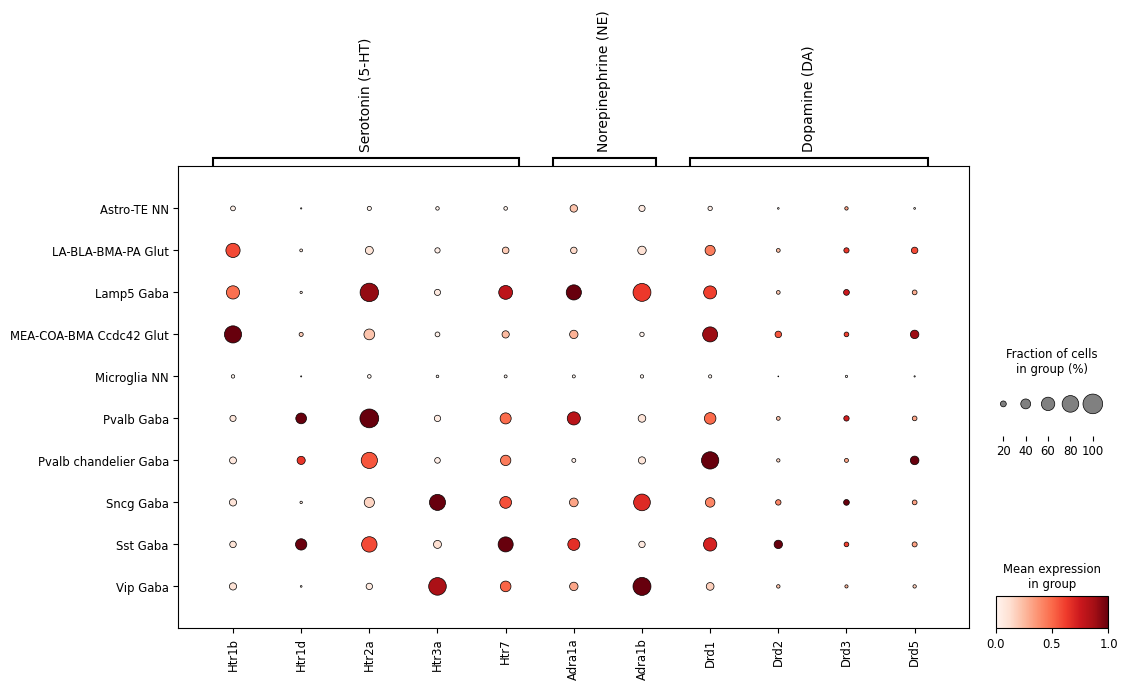

Saved: dotplot_BLA_MERFISH_receptors_by_subclass.png


In [9]:
# Gene groups
receptor_groups = {
    'Serotonin (5-HT)': [g for g in serotonin_receptors if g in receptor_genes],
    'Norepinephrine (NE)': [g for g in norepinephrine_receptors if g in receptor_genes],
    'Dopamine (DA)': [g for g in dopamine_receptors if g in receptor_genes],
}

# Subclass dot plot
dp = sc.pl.dotplot(
    adata_bla,
    var_names=receptor_groups,
    groupby='subclass_short',
    standard_scale='var',
    cmap='Reds',
    figsize=(12, max(6, n_subclasses * 0.5)),
    show=False,
    return_fig=True
)
dp.style(dot_edge_color='black', dot_edge_lw=0.5)
dp.savefig('dotplot_BLA_MERFISH_receptors_by_subclass.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: dotplot_BLA_MERFISH_receptors_by_subclass.png")

## 8. Finer View: Grouped by Supertype

Supertype-level dot plot for BLA cell types with at least 40 cells.

Supertypes with >= 40 cells: 21


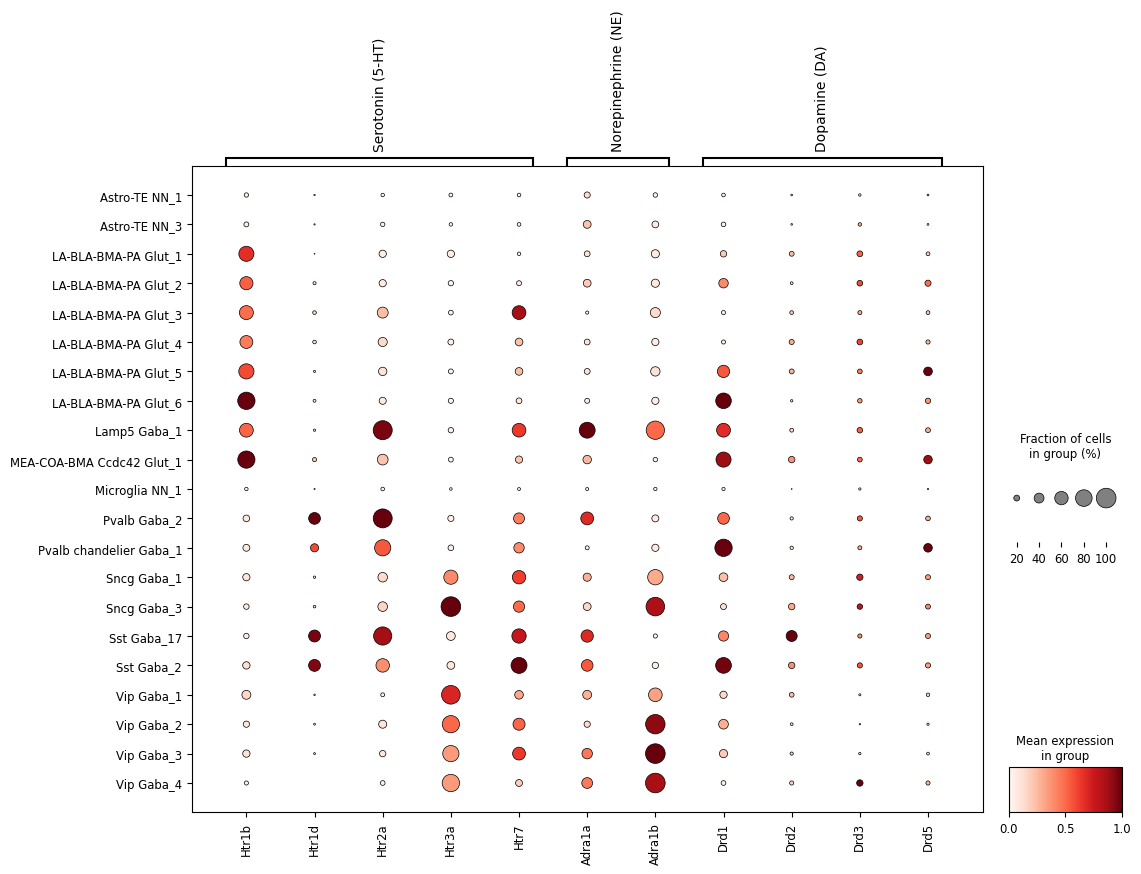

Saved: dotplot_BLA_MERFISH_receptors_by_supertype.png


In [10]:
# Filter to supertypes with sufficient cells
min_cells = 40
supertype_counts = adata_bla.obs.groupby('supertype', observed=True).size()
valid_supertypes = supertype_counts[supertype_counts >= min_cells].index.tolist()

adata_st = adata_bla[adata_bla.obs['supertype'].isin(valid_supertypes)].copy()
adata_st.obs['supertype_short'] = pd.Categorical(adata_st.obs['supertype_short'])

n_st = len(valid_supertypes)
print(f"Supertypes with >= {min_cells} cells: {n_st}")

dp2 = sc.pl.dotplot(
    adata_st,
    var_names=receptor_groups,
    groupby='supertype_short',
    standard_scale='var',
    cmap='Reds',
    figsize=(12, max(6, n_st * 0.4)),
    show=False,
    return_fig=True
)
dp2.style(dot_edge_color='black', dot_edge_lw=0.5)
dp2.savefig('dotplot_BLA_MERFISH_receptors_by_supertype.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: dotplot_BLA_MERFISH_receptors_by_supertype.png")

## 9. Summary Statistics

In [11]:
expr_df = pd.DataFrame(
    adata_bla.X,
    index=adata_bla.obs.index,
    columns=adata_bla.var.index
)
expr_df['subclass'] = adata_bla.obs['subclass_short'].values

mean_expr = expr_df.groupby('subclass', observed=True)[receptor_genes].mean()
frac_expr = expr_df.groupby('subclass', observed=True)[receptor_genes].apply(
    lambda x: (x > 0).mean()
)

print("=" * 70)
print("Mean Expression (log2) by BLA Subclass — MERFISH")
print("=" * 70)
display(mean_expr.round(2))

print("\n" + "=" * 70)
print("Fraction of Expressing Cells by BLA Subclass — MERFISH")
print("=" * 70)
display(frac_expr.round(3))

Mean Expression (log2) by BLA Subclass — MERFISH


,Htr1b,Htr1d,Htr2a,Htr3a,Htr7,Adra1a,Adra1b,Drd1,Drd2,Drd3,Drd5
subclass,,,,,,,,,,,
Astro-TE NN,0.14,0.02,0.12,0.10,0.09,0.27,0.22,0.13,0.03,0.10,0.03
LA-BLA-BMA-PA Glut,1.05,0.06,0.32,0.17,0.25,0.21,0.32,0.61,0.12,0.14,0.23
Lamp5 Gaba,0.89,0.05,2.13,0.26,0.77,0.99,1.41,0.82,0.11,0.16,0.13
MEA-COA-BMA Ccdc42 Glut,1.75,0.12,0.59,0.15,0.29,0.33,0.13,1.16,0.25,0.14,0.33
Microglia NN,0.09,0.02,0.09,0.06,0.07,0.07,0.08,0.08,0.01,0.05,0.02
Pvalb Gaba,0.22,0.54,2.33,0.21,0.50,0.81,0.30,0.68,0.11,0.16,0.13
Pvalb chandelier Gaba,0.21,0.35,1.33,0.17,0.46,0.10,0.28,1.29,0.08,0.09,0.37
Sncg Gaba,0.26,0.06,0.47,2.87,0.57,0.37,1.51,0.59,0.19,0.20,0.14
Sst Gaba,0.25,0.53,1.40,0.41,0.94,0.68,0.23,0.95,0.44,0.14,0.14



Fraction of Expressing Cells by BLA Subclass — MERFISH


,Htr1b,Htr1d,Htr2a,Htr3a,Htr7,Adra1a,Adra1b,Drd1,Drd2,Drd3,Drd5
subclass,,,,,,,,,,,
Astro-TE NN,0.151,0.027,0.126,0.102,0.106,0.275,0.217,0.135,0.038,0.097,0.041
LA-BLA-BMA-PA Glut,0.650,0.076,0.301,0.174,0.236,0.230,0.324,0.413,0.112,0.172,0.229
Lamp5 Gaba,0.591,0.058,0.920,0.212,0.628,0.708,0.883,0.577,0.109,0.197,0.153
MEA-COA-BMA Ccdc42 Glut,0.835,0.125,0.449,0.153,0.265,0.321,0.137,0.701,0.231,0.150,0.327
Microglia NN,0.098,0.023,0.106,0.068,0.079,0.083,0.094,0.091,0.015,0.057,0.026
Pvalb Gaba,0.214,0.447,0.944,0.220,0.466,0.584,0.283,0.494,0.112,0.177,0.149
Pvalb chandelier Gaba,0.250,0.310,0.774,0.190,0.429,0.119,0.262,0.845,0.095,0.119,0.333
Sncg Gaba,0.264,0.062,0.417,0.764,0.507,0.340,0.806,0.382,0.181,0.194,0.153
Sst Gaba,0.230,0.480,0.724,0.301,0.702,0.520,0.225,0.596,0.322,0.149,0.163
